## Malware Visualization

In [ ]:
import os
from math import ceil
import numpy as np
from PIL import Image

def get_image_width(file_size):
    if file_size < 10 * 1024:
        return 32
    elif file_size < 30 * 1024:
        return 64
    elif file_size < 60 * 1024:
        return 128
    elif file_size < 100 * 1024:
        return 256
    elif file_size < 200 * 1024:
        return 384
    elif file_size < 500 * 1024:
        return 512
    elif file_size < 1000 * 1024:
        return 768
    else:
        return 1024

def convert_and_save(array, output_path, image_width):
    print(f'Processing: {output_path}')
    
    height = ceil(array.shape[0] * 16 / image_width)
    padded_array = np.pad(array.flatten(), (0, image_width * height - len(array.flatten())), mode='constant', constant_values=0)
    reshaped_array = padded_array.reshape(height, image_width)
    
    image = Image.fromarray(np.uint8(reshaped_array))
    image.save(output_path)
    print(f'Saved image: {output_path}')
    return image

# 主程序
root = './dataSample'  # 包含 .bytes 文件的資料夾
output_dir = './outputImages' #輸出資料夾
os.makedirs(output_dir, exist_ok=True)

files = os.listdir(root)
print('Processing files:', files)

# 處理 .bytes 文件
for name in files:
    if not name.endswith('.bytes'):
        continue
    
    file_path = os.path.join(root, name)
    output_path = os.path.join(output_dir, f'{os.path.splitext(name)[0]}.png')
    
    file_size = os.path.getsize(file_path)
    image_width = get_image_width(file_size)
    
    array = []
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 17: 
                continue
            array.append([int(i, 16) if i != '??' else 0 for i in parts[1:]])
    
    array = np.array(array)
    convert_and_save(array, output_path, image_width)

Processing files: ['0A32eTdBKayjCWhZqDOQ.asm', '0A32eTdBKayjCWhZqDOQ.bytes', '0ACDbR5M3ZhBJajygTuf.asm', '0ACDbR5M3ZhBJajygTuf.bytes']
Processing: ./outputImages\0A32eTdBKayjCWhZqDOQ.png
Saved image: ./outputImages\0A32eTdBKayjCWhZqDOQ.png
Processing: ./outputImages\0ACDbR5M3ZhBJajygTuf.png
Saved image: ./outputImages\0ACDbR5M3ZhBJajygTuf.png


## GIST特徵

In [108]:
import torch
import numpy as np
from torch.fft import fft2, ifft2, fftshift
from torchvision.transforms import functional as TF
from PIL import Image
import matplotlib.pyplot as plt


class GISTFeatureExtractor:
    def __init__(self, orientations=8, scales=4, blocks=4, boundary_extension=16, device="cuda"):
        """
        初始化 GIST 特徵提取器
        :param orientations: 濾波器方向數
        :param scales: 濾波器尺度數
        :param blocks: 圖像分割的區塊數 (blocks x blocks)
        :param boundary_extension: 圖像邊界填充大小
        :param device: 運算設備 ('cuda' 或 'cpu')
        """
        self.orientations = orientations
        self.scales = scales
        self.blocks = blocks
        self.boundary_extension = boundary_extension
        self.device = device

    def create_gabor_filters(self, image_size):
        """
        創建 Gabor 濾波器組
        """
        filters = []
        fx, fy = torch.meshgrid(
            torch.linspace(-0.5, 0.5, image_size[0], device=self.device),
            torch.linspace(-0.5, 0.5, image_size[1], device=self.device)
        )
        fr = torch.sqrt(fx**2 + fy**2)
        t = torch.atan2(fy, fx)

        for scale in range(self.scales):
            sigma = 0.35 * (0.8 ** scale)
            for orientation in range(self.orientations):
                theta = orientation * np.pi * 2 / self.orientations
                tr = t - theta
                tr = (tr + np.pi) % (2 * np.pi) - np.pi
                gabor = torch.exp(
                    -10 * ((fr / sigma - 1)**2) - 2 * np.pi * (tr**2)
                )
                filters.append(gabor)
        return filters

    def preprocess_image(self, image_tensor):
        """
        圖像預處理：調整大小 + 歸一化 + 邊界填充
        """
        image_tensor = image_tensor - image_tensor.min()
        if image_tensor.max() > 0:
            image_tensor /= image_tensor.max()

        if image_tensor.ndim == 2:
            image_tensor = image_tensor.unsqueeze(0).unsqueeze(0)

        image_tensor = torch.nn.functional.pad(
            image_tensor, (self.boundary_extension,) * 4, mode="reflect"
        )

        return image_tensor.squeeze(0).squeeze(0)


    def downsample_blocks(self, response, blocks):
        """
        計算每個區域的平均值
        """
        h, w = response.shape[-2:]
        grid_h, grid_w = h // blocks, w // blocks
        downsampled = torch.zeros((blocks, blocks), device=self.device)
        for i in range(blocks):
            for j in range(blocks):
                block = response[
                    i * grid_h:(i + 1) * grid_h, j * grid_w:(j + 1) * grid_w
                ]
                downsampled[i, j] = block.mean()
        return downsampled
    
    def visualize_gabor_responses(self, image, filters):
        """
        將 Gabor 濾波器應用於圖像，並以表格形式顯示濾波結果
        """
        fig, axes = plt.subplots(self.scales, self.orientations, figsize=(15, 8))
        fig.suptitle("Gabor Filter Responses: Y-Scales, X-Orientations", fontsize=16)

        scale_labels = [f"Scale {i+1}" for i in range(self.scales)]
        direction_labels = [f"Dir {i+1}" for i in range(self.orientations)]

        for scale in range(self.scales):
            for orientation in range(self.orientations):
                idx = scale * self.orientations + orientation
                gabor_filter = filters[idx]
                response = ifft2(fft2(image) * fft2(gabor_filter)).abs()

                ax = axes[scale, orientation]
                ax.imshow(response.cpu(), cmap="gray")
                
                if orientation == 0:
                    ax.set_ylabel(scale_labels[scale], rotation=90, fontsize=10, labelpad=10)
                
                if scale == self.scales - 1:
                    ax.set_xlabel(direction_labels[orientation], fontsize=10)

                ax.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    def extract_gist_features(self, image):
        """
        提取 GIST 特徵向量
        """
        image = self.preprocess_image(image)
        image_size = image.shape[-2:]
        filters = self.create_gabor_filters(image_size)

        features = []
        for gabor_filter in filters[:20]:
            response = ifft2(fft2(image) * fft2(gabor_filter)).abs()
            response_blocks = self.downsample_blocks(response, self.blocks)
            features.append(response_blocks.flatten())
        
        gist_vector = torch.cat(features)
        return gist_vector



In [109]:
orientations = 8
scales = 4
blocks = 4
boundary_extension = 16
device = "cuda" if torch.cuda.is_available() else "cpu"

In [26]:
image_path = "example.jpg"
image = Image.open(image_path).convert("L")
image_tensor = torch.tensor(np.array(image), dtype=torch.float32, device=device)

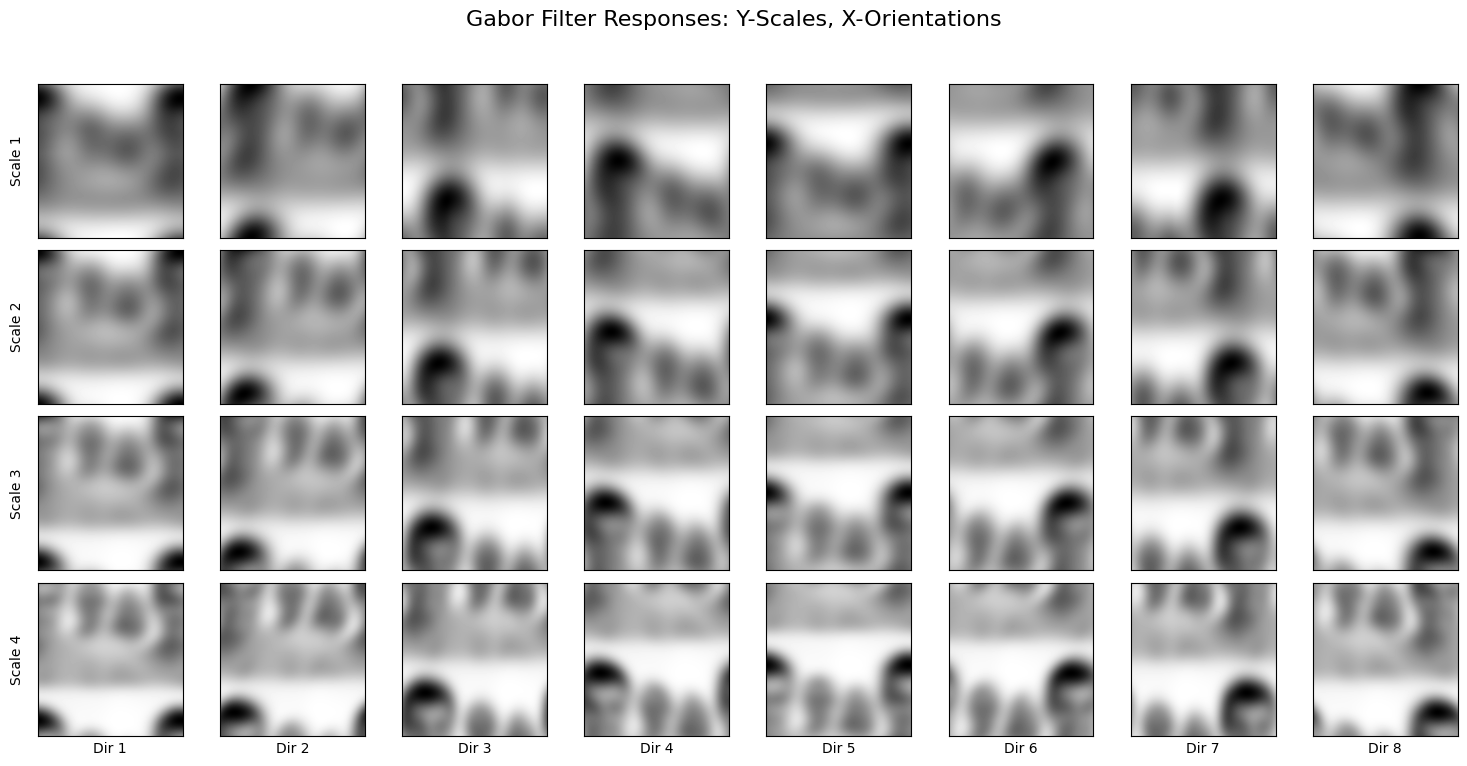

In [ ]:
gist_extractor = GISTFeatureExtractor(orientations, scales, blocks, boundary_extension, device)
preprocessed_image = gist_extractor.preprocess_image(image_tensor)

image_size = preprocessed_image.shape[-2:]
gabor_filters = gist_extractor.create_gabor_filters(image_size)

gist_extractor.visualize_gabor_responses(preprocessed_image, gabor_filters)
del gist_extractor

In [6]:
# 提取 GIST 特徵
gist_extractor = GISTFeatureExtractor(orientations, scales, blocks, boundary_extension, device)
gist_features = gist_extractor.extract_gist_features(image_tensor)

# 打印結果
print("GIST 特徵向量維度:", gist_features.shape)
print("GIST 特徵向量:", gist_features.cpu().numpy())

GIST 特徵向量維度: torch.Size([320])
GIST 特徵向量: [1384.5653   981.6769   927.418   1061.8002   836.28015  799.7992
  900.8886   801.58093  837.33344  792.2143   808.9005   817.6226
 1379.8567   983.9283   893.7002  1139.2727   962.6877  1157.3468
  904.146    938.4155   798.657    814.1577   792.47076  885.9418
  909.3452  1009.5481   873.8012   843.0158  1220.7963  1602.4827
 1033.9174   939.8608   808.36255  821.0698   747.04016  864.17993
  846.5697  1012.979    893.3092   831.21063  929.9194  1611.0212
 1133.4873   966.2389   832.03424 1206.0353   905.67145  967.8434
  940.86115  990.9573   858.917    839.7696  1237.0277  1587.9579
 1041.8177   928.9529   922.95044 1197.5198   925.56494  944.181
  796.72015  819.9852   782.0838   896.7225  1218.5057   934.9599
  867.67584 1051.0123  1509.0426  1021.0075   930.80084 1147.9634
  919.86884  832.31055  910.81824  834.4462   806.5853   774.41925
  824.1934   795.4767   874.7972   842.45764  905.9668  1007.2834
 1037.0083   941.28064 1208.3645 

In [110]:
def load_dataset(dataset_path, gist_extractor):
    data = []
    labels = []
    label_map = {}
    current_label = 0

    for family in os.listdir(dataset_path):
        family_path = os.path.join(dataset_path, family)
        if not os.path.isdir(family_path):
            continue

        if family not in label_map:
            label_map[family] = current_label
            current_label += 1

        for image_file in tqdm(os.listdir(family_path), desc=f"Processing {family}"):
            image_path = os.path.join(family_path, image_file)
            image = Image.open(image_path).convert("L")
            image_tensor = torch.tensor(np.array(image), dtype=torch.float32, device=gist_extractor.device)
            gist_features = gist_extractor.extract_gist_features(image_tensor)
            data.append(gist_features)
            labels.append(label_map[family])

    data = np.array([feature.cpu().numpy() for feature in data])
    labels = np.array(labels)

    return data, labels, label_map


## KNN分類

dataset來源: https://drive.google.com/file/d/1Ebb4OkEeBeh8Q0IAQ5sM9nto1Dhrarm3/view?usp=sharing

In [112]:
import time  # 加入時間模組
import torch
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 假設 load_dataset 和 GISTFeatureExtractor 已經定義
gist_extractor = GISTFeatureExtractor(device="cuda" if torch.cuda.is_available() else "cpu")

# 記錄開始時間
start_time = time.time()

# 加載資料集
dataset_path = "./dataset" 
data, labels, label_map = load_dataset(dataset_path, gist_extractor)

# 分割訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)

# 初始化 KNN 分類器
knn = KNeighborsClassifier(n_neighbors=3, metric="euclidean")

# 訓練 KNN 分類器
knn.fit(X_train, y_train)

# 預測測試集
y_pred = knn.predict(X_test)

# 計算分類準確率
accuracy = accuracy_score(y_test, y_pred)
print("KNN 分類準確率:", accuracy)

# 記錄結束時間並計算總花費時間
end_time = time.time()
elapsed_time = end_time - start_time
print(f"總花費時間: {elapsed_time:.2f} 秒")

Processing Yuner.A: 100%|██████████| 800/800 [00:17<00:00, 46.12it/s]
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


KNN 分類準確率: 0.9707664884135473
總花費時間: 189.28 秒


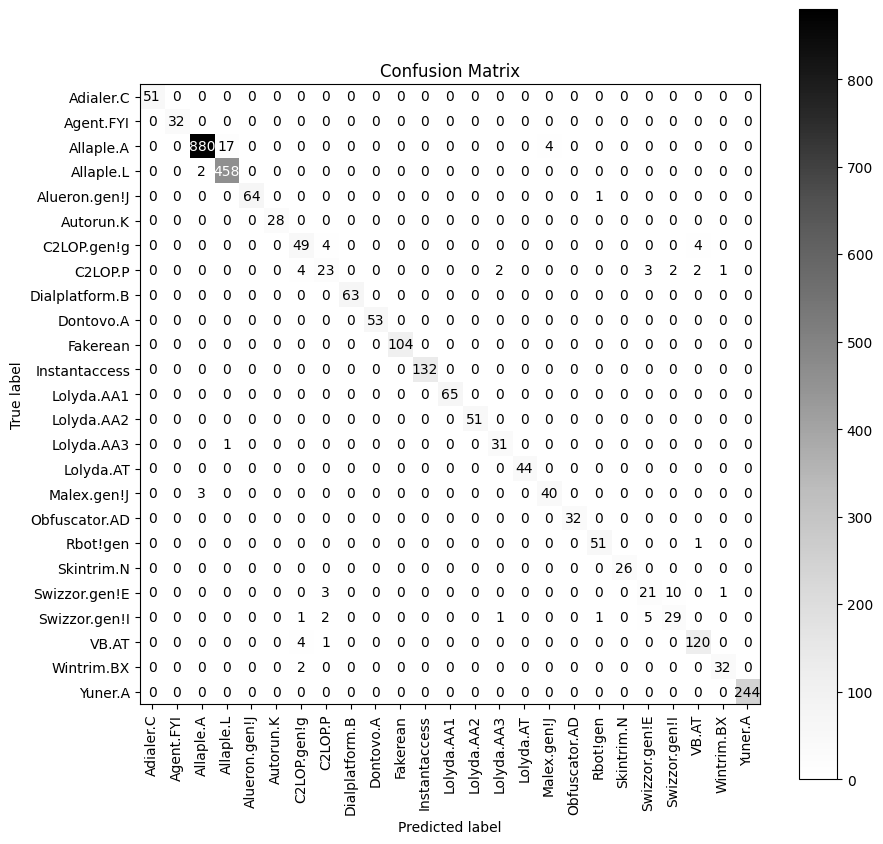

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_map.keys()))

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Greys, ax=ax)

plt.xticks(rotation=90)
plt.title("Confusion Matrix")
plt.show()

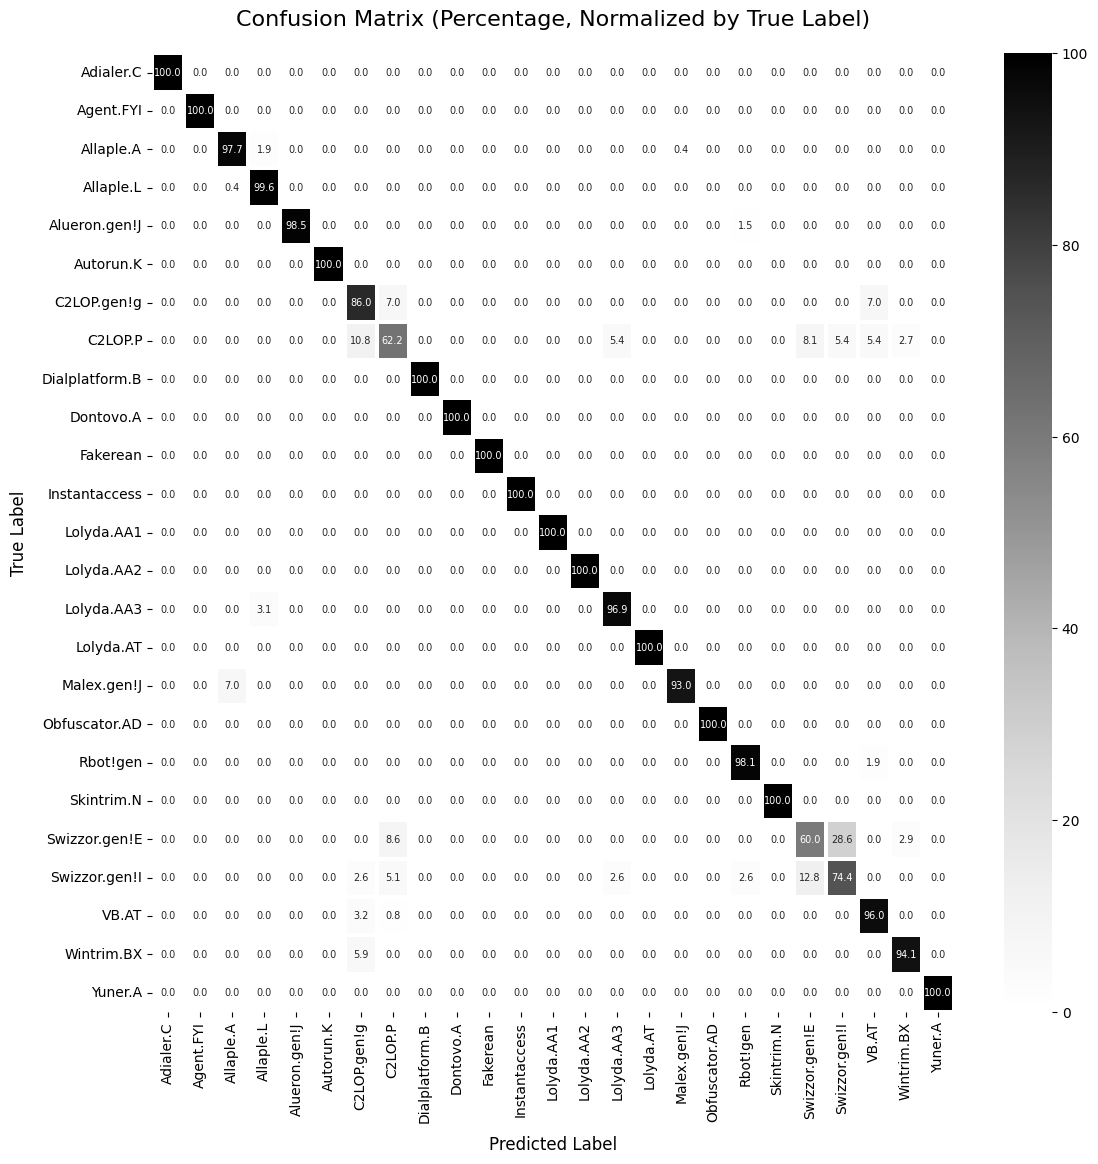

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # 以 True label 行總和歸一化

labels = list(label_map.keys())

fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(cm_percentage, 
            annot=True, 
            fmt=".1f", 
            cmap="Greys", 
            xticklabels=labels, 
            yticklabels=labels, 
            cbar=True, 
            linewidths=1.5,
            linecolor='white',
            annot_kws={"size": 7})

# 調整標籤顯示
plt.title("Confusion Matrix (Percentage, Normalized by True Label)", fontsize=16, pad=20)
plt.xlabel("Predicted Label", fontsize=12, labelpad=10)
plt.ylabel("True Label", fontsize=12, labelpad=10)
plt.xticks(rotation=90, fontsize=10) 
plt.yticks(rotation=0, fontsize=10)

plt.tight_layout(pad=2.0)

plt.show()


## 定義Dataset

In [10]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# 定義自訂 Dataset 類別
class MalwareDataset(Dataset):
    def __init__(self, dataset_path, transform=None):
        self.dataset_path = dataset_path
        self.transform = transform
        self.data = []
        self.labels = []
        self.label_map = {}

        current_label = 0
        for family in os.listdir(dataset_path):
            family_path = os.path.join(dataset_path, family)
            if not os.path.isdir(family_path):
                continue
            if family not in self.label_map:
                self.label_map[family] = current_label
                current_label += 1
            for image_file in os.listdir(family_path):
                image_path = os.path.join(family_path, image_file)
                if image_file.endswith(".png"):
                    self.data.append(image_path)
                    self.labels.append(self.label_map[family])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert("L")
        if self.transform:
            image = self.transform(image)
        return image, label

transform = transforms.Compose([
    transforms.Resize((32, 32)),  # 調整大小
    transforms.ToTensor()
])

dataset_path = r"dataset" 
dataset = MalwareDataset(dataset_path, transform=transform)

train_data, test_data = train_test_split(dataset, test_size=0.3, random_state=42)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

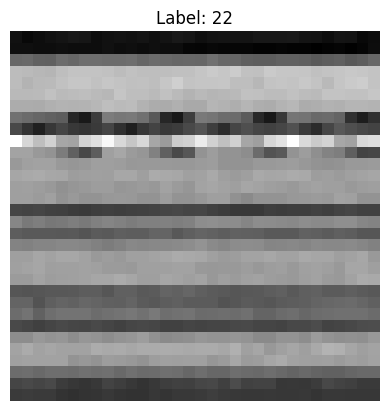

圖像的標籤: 22


In [98]:
data_iter = iter(train_loader)
images, labels = next(data_iter) 

index = 0 
first_image = images[index]
first_label = labels[index]

if isinstance(first_image, torch.Tensor):
    first_image_pil = transforms.ToPILImage()(first_image)

import matplotlib.pyplot as plt

plt.imshow(first_image_pil, cmap="gray")
plt.title(f"Label: {first_label}")
plt.axis("off")
plt.show()

print(f"圖像的標籤: {first_label}")


## 論文提出的CNN模型

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ProposedCNN(nn.Module):
    def __init__(self):
        super(ProposedCNN, self).__init__()
        
        # 第一層卷積
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=50, kernel_size=5, padding=2)  # padding=same
        self.relu1 = nn.LeakyReLU(negative_slope=0.1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # 第二層卷積
        self.conv2 = nn.Conv2d(in_channels=50, out_channels=70, kernel_size=3, padding=1)  # padding=same
        self.relu2 = nn.LeakyReLU(negative_slope=0.1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # 第三層卷積
        self.conv3 = nn.Conv2d(in_channels=70, out_channels=70, kernel_size=3, padding=1)  # padding=same
        self.relu3 = nn.LeakyReLU(negative_slope=0.1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # 全連接層
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(70 * 4 * 4, 256)  # 修正輸入大小
        self.fc2 = nn.Linear(256, 25)  # 輸出 25 個分類
        
    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))  # 第一層卷積 + LeakyReLU + MaxPooling
        x = self.pool2(self.relu2(self.conv2(x)))  # 第二層卷積 + LeakyReLU + MaxPooling
        x = self.pool3(self.relu3(self.conv3(x)))  # 第三層卷積 + LeakyReLU + MaxPooling
        x = self.flatten(x)  # 展平
        x = F.relu(self.fc1(x))  # 第一個全連接層
        x = self.fc2(x)  # 第二個全連接層
        return x

In [100]:
model = ProposedCNN()
print(model)

input_tensor = torch.randn(1, 1, 32, 32)  # (Batch size, Channels, Height, Width)
output = model(input_tensor)

print("輸出形狀:", output.shape)

ProposedCNN(
  (conv1): Conv2d(1, 50, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): LeakyReLU(negative_slope=0.1)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(50, 70, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): LeakyReLU(negative_slope=0.1)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(70, 70, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): LeakyReLU(negative_slope=0.1)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=1120, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=25, bias=True)
)
輸出形狀: torch.Size([1, 25])


## 訓練

Epoch 1/20: 100%|██████████| 205/205 [00:00<00:00, 296.55it/s]


Epoch 1/20, Loss: 1.1304, Train Accuracy: 0.6443, Validation Accuracy: 0.9037


Epoch 2/20: 100%|██████████| 205/205 [00:00<00:00, 512.03it/s]


Epoch 2/20, Loss: 0.2591, Train Accuracy: 0.9208, Validation Accuracy: 0.9476


Epoch 3/20: 100%|██████████| 205/205 [00:00<00:00, 509.09it/s]


Epoch 3/20, Loss: 0.1488, Train Accuracy: 0.9522, Validation Accuracy: 0.9611


Epoch 4/20: 100%|██████████| 205/205 [00:00<00:00, 502.93it/s]


Epoch 4/20, Loss: 0.1218, Train Accuracy: 0.9581, Validation Accuracy: 0.9686


Epoch 5/20: 100%|██████████| 205/205 [00:00<00:00, 508.69it/s]


Epoch 5/20, Loss: 0.1065, Train Accuracy: 0.9635, Validation Accuracy: 0.9529


Epoch 6/20: 100%|██████████| 205/205 [00:00<00:00, 509.49it/s]


Epoch 6/20, Loss: 0.1041, Train Accuracy: 0.9671, Validation Accuracy: 0.9740


Epoch 7/20: 100%|██████████| 205/205 [00:00<00:00, 517.72it/s]


Epoch 7/20, Loss: 0.0914, Train Accuracy: 0.9691, Validation Accuracy: 0.9697


Epoch 8/20: 100%|██████████| 205/205 [00:00<00:00, 514.50it/s]


Epoch 8/20, Loss: 0.0803, Train Accuracy: 0.9705, Validation Accuracy: 0.9772


Epoch 9/20: 100%|██████████| 205/205 [00:00<00:00, 519.34it/s]


Epoch 9/20, Loss: 0.0810, Train Accuracy: 0.9739, Validation Accuracy: 0.9747


Epoch 10/20: 100%|██████████| 205/205 [00:00<00:00, 508.91it/s]


Epoch 10/20, Loss: 0.0782, Train Accuracy: 0.9733, Validation Accuracy: 0.9768


Epoch 11/20: 100%|██████████| 205/205 [00:00<00:00, 501.03it/s]


Epoch 11/20, Loss: 0.0991, Train Accuracy: 0.9681, Validation Accuracy: 0.9768


Epoch 12/20: 100%|██████████| 205/205 [00:00<00:00, 477.87it/s]


Epoch 12/20, Loss: 0.0734, Train Accuracy: 0.9749, Validation Accuracy: 0.9754


Epoch 13/20: 100%|██████████| 205/205 [00:00<00:00, 500.69it/s]


Epoch 13/20, Loss: 0.0682, Train Accuracy: 0.9763, Validation Accuracy: 0.9629


Epoch 14/20: 100%|██████████| 205/205 [00:00<00:00, 508.63it/s]


Epoch 14/20, Loss: 0.0682, Train Accuracy: 0.9757, Validation Accuracy: 0.9790


Epoch 15/20: 100%|██████████| 205/205 [00:00<00:00, 499.75it/s]


Epoch 15/20, Loss: 0.0579, Train Accuracy: 0.9811, Validation Accuracy: 0.9747


Epoch 16/20: 100%|██████████| 205/205 [00:00<00:00, 518.79it/s]


Epoch 16/20, Loss: 0.0722, Train Accuracy: 0.9771, Validation Accuracy: 0.9786


Epoch 17/20: 100%|██████████| 205/205 [00:00<00:00, 494.70it/s]


Epoch 17/20, Loss: 0.0563, Train Accuracy: 0.9806, Validation Accuracy: 0.9800


Epoch 18/20: 100%|██████████| 205/205 [00:00<00:00, 532.23it/s]


Epoch 18/20, Loss: 0.0570, Train Accuracy: 0.9815, Validation Accuracy: 0.9768


Epoch 19/20: 100%|██████████| 205/205 [00:00<00:00, 523.29it/s]


Epoch 19/20, Loss: 0.0615, Train Accuracy: 0.9795, Validation Accuracy: 0.9804


Epoch 20/20: 100%|██████████| 205/205 [00:00<00:00, 528.50it/s]
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 20/20, Loss: 0.0598, Train Accuracy: 0.9806, Validation Accuracy: 0.9768
訓練總時間: 9.63 秒
測試準確率: 97.68%
測試精確率: 96.80%
測試召回率: 97.68%
測試 F1 分數: 97.21%
測試總時間: 0.06 秒


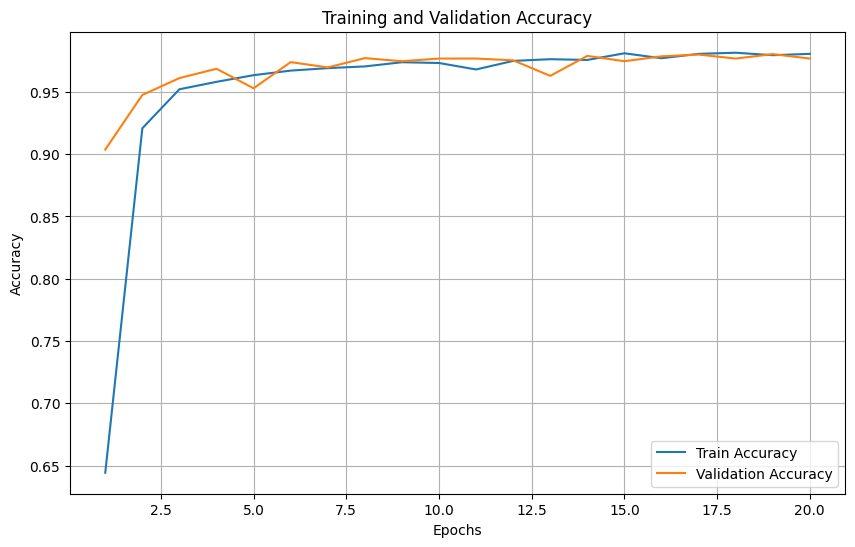

In [101]:
import time
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ProposedCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 20
train_accuracies = []
val_accuracies = []
start_time = time.time()

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_accuracy = correct / total
    train_accuracies.append(train_accuracy)

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_accuracy = correct / total
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

end_time = time.time()
training_time = end_time - start_time
print(f"訓練總時間: {training_time:.2f} 秒")

start_time = time.time()
model.eval()
all_labels = []
all_predictions = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

accuracy = accuracy_score(all_labels, all_predictions) * 100
precision = precision_score(all_labels, all_predictions, average='weighted') * 100
recall = recall_score(all_labels, all_predictions, average='weighted') * 100
f1 = f1_score(all_labels, all_predictions, average='weighted') * 100

print(f"測試準確率: {accuracy:.2f}%")
print(f"測試精確率: {precision:.2f}%")
print(f"測試召回率: {recall:.2f}%")
print(f"測試 F1 分數: {f1:.2f}%")

test_time = time.time() - start_time
print(f"測試總時間: {test_time:.2f} 秒")

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()
plt.show()


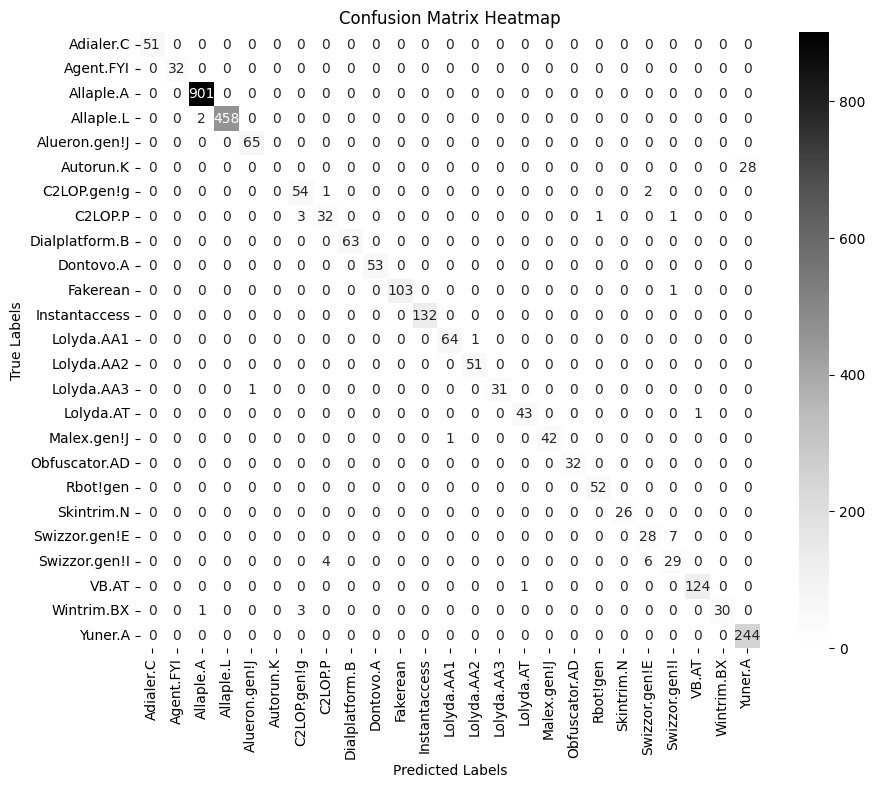

In [102]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(all_labels, all_predictions)

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greys', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix Heatmap')
    plt.show()

class_names = list(dataset.label_map.keys())
plot_confusion_matrix(cm, class_names)

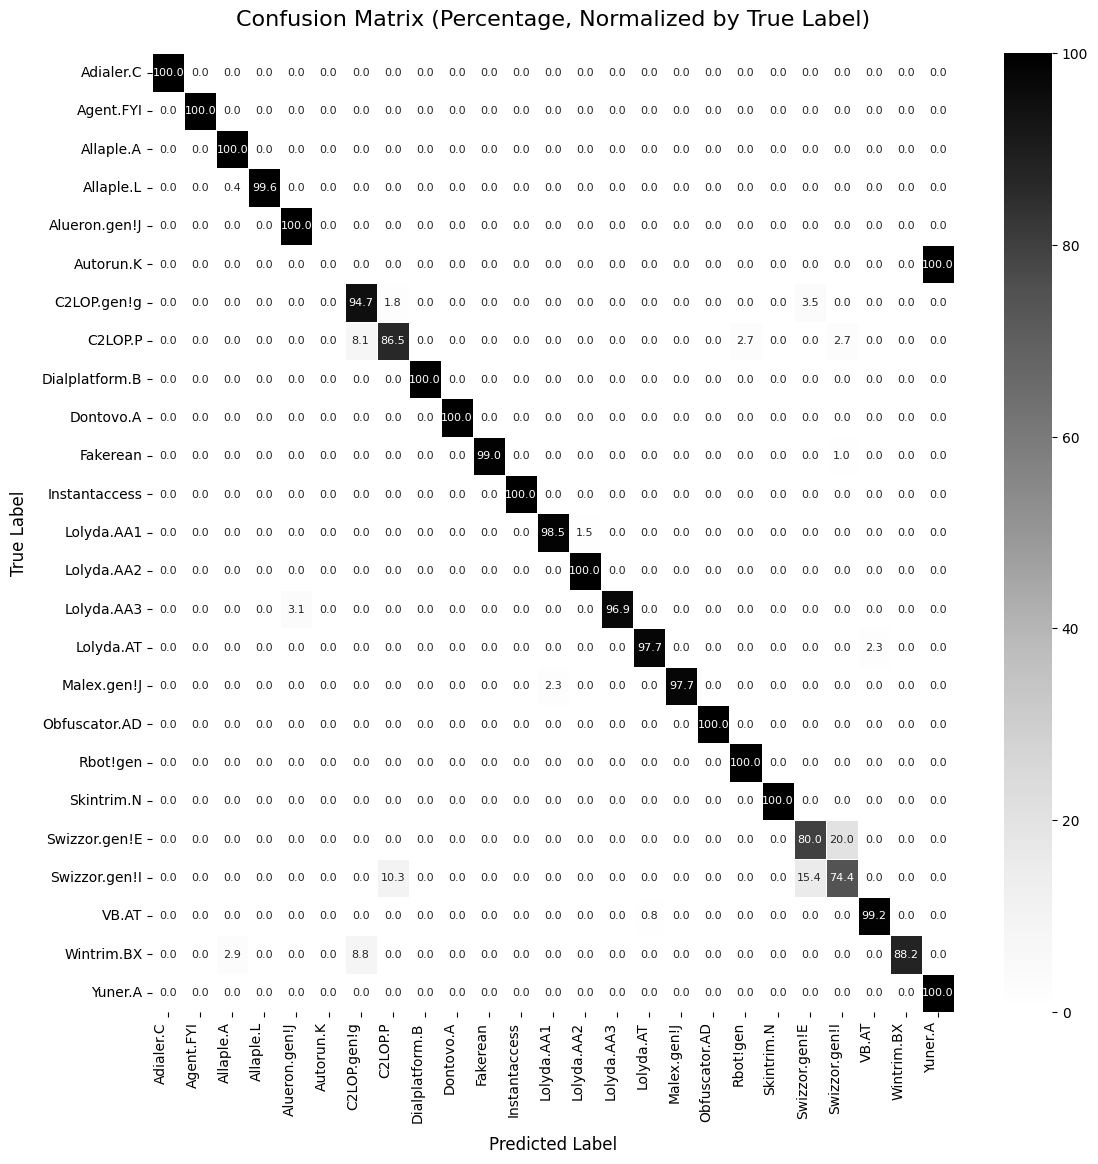

In [103]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(all_labels, all_predictions)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100 

class_names = list(dataset.label_map.keys())

fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(cm_percentage, 
            annot=True, 
            fmt=".1f", 
            cmap="Greys", 
            xticklabels=class_names, 
            yticklabels=class_names, 
            cbar=True, 
            linewidths=0.5,
            linecolor='white',
            annot_kws={"size": 8})

plt.title("Confusion Matrix (Percentage, Normalized by True Label)", fontsize=16, pad=20)
plt.xlabel("Predicted Label", fontsize=12, labelpad=10)
plt.ylabel("True Label", fontsize=12, labelpad=10)
plt.xticks(rotation=90, fontsize=10, ha="right")
plt.yticks(rotation=0, fontsize=10)

plt.tight_layout(pad=2.0)

plt.show()



### CNN + SVM

In [20]:
def extract_features(model, dataloader, device):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for images, lbls in tqdm(dataloader, desc="提取特徵"):
            images = images.to(device)
            features_layer = nn.Sequential(*list(model.children())[:-1])
            features_out = features_layer(images)
            features.append(features_out.cpu().numpy())
            labels.extend(lbls.numpy())
    return np.vstack(features), np.array(labels)

In [105]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

print("提取 CNN 特徵")
train_features, train_labels = extract_features(model, train_loader, device)
test_features, test_labels = extract_features(model, test_loader, device)

print("開始訓練 SVM 分類器")
train_features_flat = train_features.reshape(train_features.shape[0], -1)
test_features_flat = test_features.reshape(test_features.shape[0], -1)
svm_classifier = make_pipeline(StandardScaler(), SVC(kernel='linear'))
svm_classifier.fit(train_features_flat, train_labels)

print("評估 SVM 分類器")
predictions = svm_classifier.predict(test_features_flat)
accuracy = accuracy_score(test_labels, predictions)
precision = precision_score(test_labels, predictions, average='weighted')
recall = recall_score(test_labels, predictions, average='weighted')
f1 = f1_score(test_labels, predictions, average='weighted')

print(f"SVM 測試準確率: {accuracy:.4f}")
print(f"SVM 精確率: {precision:.4f}")
print(f"SVM 召回率: {recall:.4f}")
print(f"SVM F1 分數: {f1:.4f}")

提取 CNN 特徵


提取特徵: 100%|██████████| 88/88 [00:00<00:00, 1655.81it/s]
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


開始訓練 SVM 分類器
評估 SVM 分類器
SVM 測試準確率: 0.9807
SVM 精確率: 0.9718
SVM 召回率: 0.9807
SVM F1 分數: 0.9760


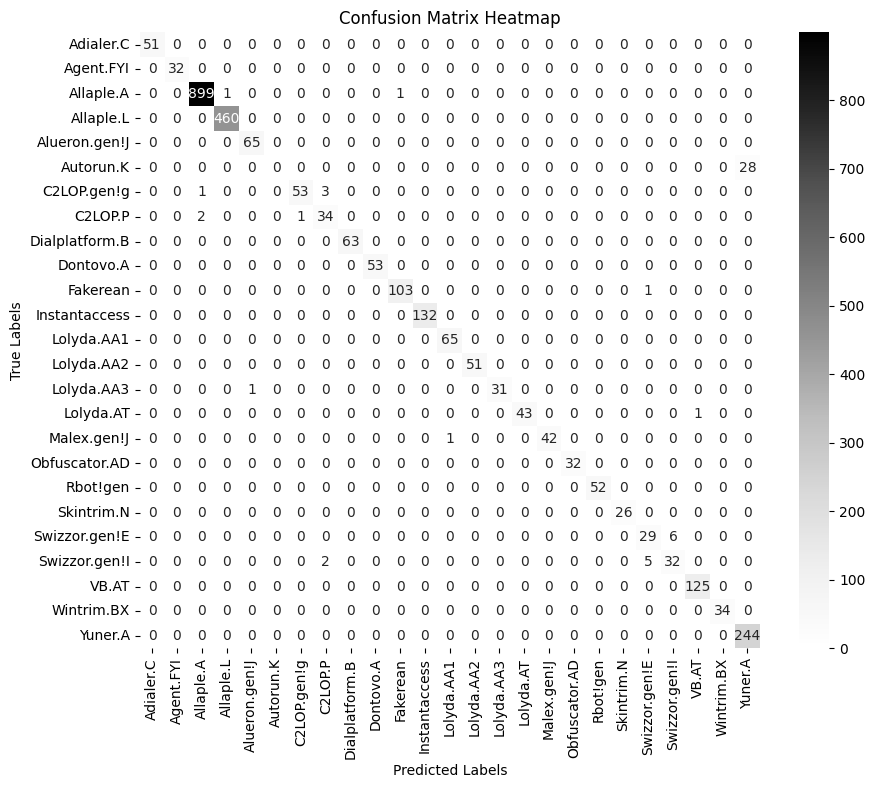

In [106]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(test_labels, predictions)

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greys', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix Heatmap')
    plt.show()

class_names = list(dataset.label_map.keys())
plot_confusion_matrix(cm, class_names)

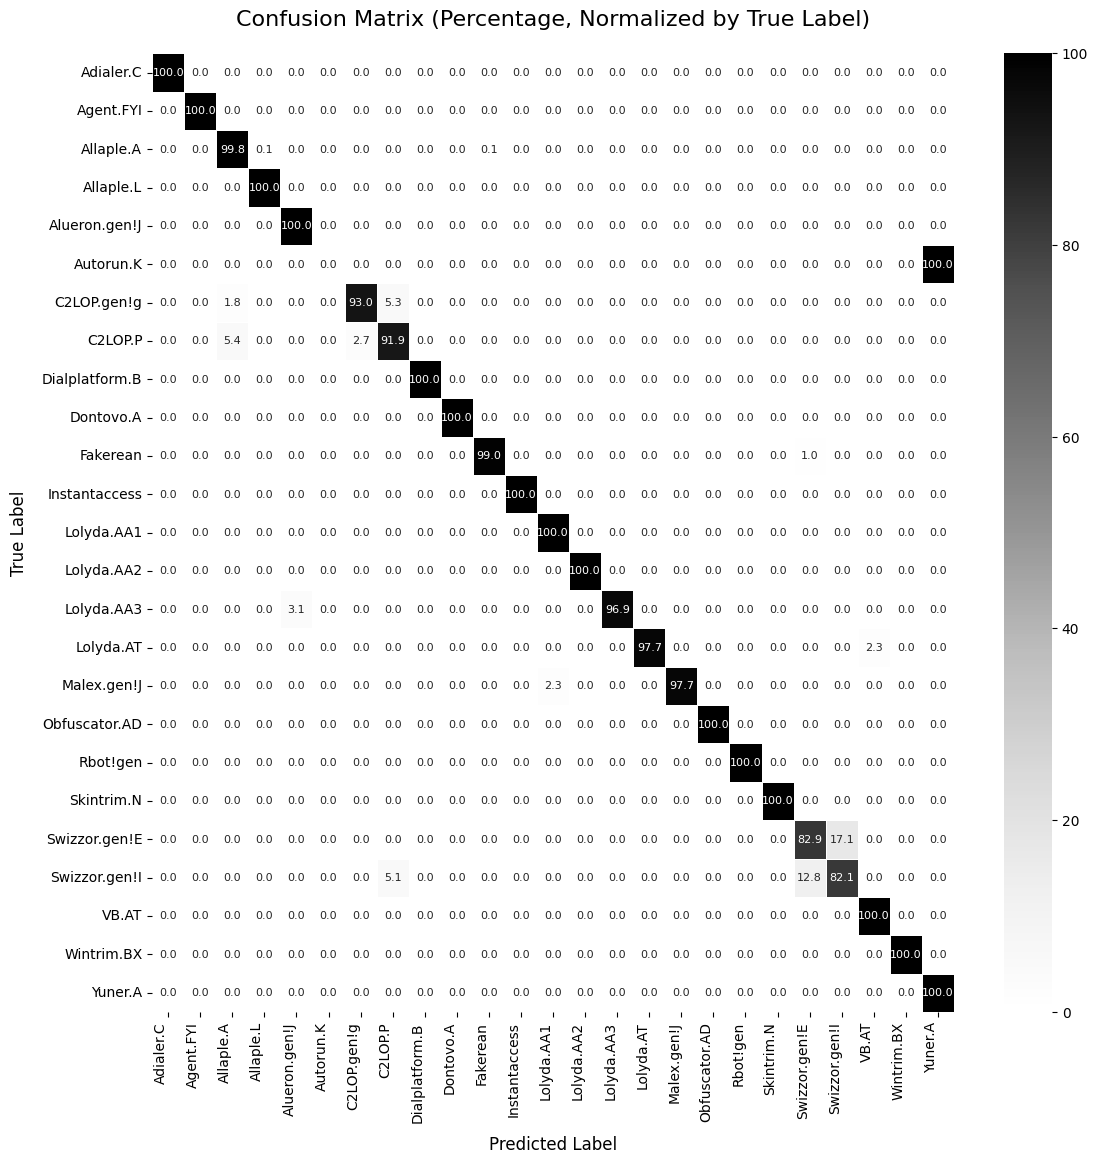

In [107]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(test_labels, predictions)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100 

class_names = list(dataset.label_map.keys())

fig, ax = plt.subplots(figsize=(12, 12)) 
sns.heatmap(cm_percentage, 
            annot=True, 
            fmt=".1f", 
            cmap="Greys", 
            xticklabels=class_names, 
            yticklabels=class_names, 
            cbar=True, 
            linewidths=0.5,
            linecolor='white',
            annot_kws={"size": 8}) 

plt.title("Confusion Matrix (Percentage, Normalized by True Label)", fontsize=16, pad=20)
plt.xlabel("Predicted Label", fontsize=12, labelpad=10)
plt.ylabel("True Label", fontsize=12, labelpad=10)
plt.xticks(rotation=90, fontsize=10, ha="right")
plt.yticks(rotation=0, fontsize=10)

plt.tight_layout(pad=2.0)

plt.show()

### 執行10次，計算平均準確率

In [114]:
import time
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_and_evaluate():
    model = ProposedCNN().to(device)
    criterion = nn.CrossEntropyLoss() 
    optimizer = optim.Adam(model.parameters(), lr=0.001) 

    epochs = 20 
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_accuracy = correct / total
        train_accuracies.append(train_accuracy)

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_accuracy = correct / total
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    model.eval()
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions) * 100
    precision = precision_score(all_labels, all_predictions, average='weighted') * 100
    recall = recall_score(all_labels, all_predictions, average='weighted') * 100
    f1 = f1_score(all_labels, all_predictions, average='weighted') * 100

    return accuracy, precision, recall, f1

num_runs = 10
accuracies = []
precisions = []
recalls = []
f1_scores = []

for run in range(num_runs):
    print(f"\n執行第 {run+1} 次模型訓練與測試")
    accuracy, precision, recall, f1 = train_and_evaluate()
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

avg_accuracy = np.mean(accuracies)
avg_precision = np.mean(precisions)
avg_recall = np.mean(recalls)
avg_f1_score = np.mean(f1_scores)

print(f"\n10 次執行的平均準確率: {avg_accuracy:.2f}%")
print(f"10 次執行的平均精確率: {avg_precision:.2f}%")
print(f"10 次執行的平均召回率: {avg_recall:.2f}%")
print(f"10 次執行的平均 F1 分數: {avg_f1_score:.2f}%")



執行第 1 次模型訓練與測試


Epoch 1/20: 100%|██████████| 205/205 [00:00<00:00, 341.03it/s]


Epoch 1/20, Loss: 1.2028, Train Accuracy: 0.6226, Validation Accuracy: 0.7701


Epoch 2/20: 100%|██████████| 205/205 [00:00<00:00, 508.66it/s]


Epoch 2/20, Loss: 0.2389, Train Accuracy: 0.9254, Validation Accuracy: 0.9558


Epoch 3/20: 100%|██████████| 205/205 [00:00<00:00, 515.09it/s]


Epoch 3/20, Loss: 0.1482, Train Accuracy: 0.9497, Validation Accuracy: 0.9561


Epoch 4/20: 100%|██████████| 205/205 [00:00<00:00, 517.45it/s]


Epoch 4/20, Loss: 0.1298, Train Accuracy: 0.9549, Validation Accuracy: 0.9590


Epoch 5/20: 100%|██████████| 205/205 [00:00<00:00, 462.46it/s]


Epoch 5/20, Loss: 0.1114, Train Accuracy: 0.9610, Validation Accuracy: 0.9622


Epoch 6/20: 100%|██████████| 205/205 [00:00<00:00, 482.50it/s]


Epoch 6/20, Loss: 0.1005, Train Accuracy: 0.9650, Validation Accuracy: 0.9729


Epoch 7/20: 100%|██████████| 205/205 [00:00<00:00, 473.66it/s]


Epoch 7/20, Loss: 0.0972, Train Accuracy: 0.9662, Validation Accuracy: 0.9701


Epoch 8/20: 100%|██████████| 205/205 [00:00<00:00, 468.25it/s]


Epoch 8/20, Loss: 0.0935, Train Accuracy: 0.9679, Validation Accuracy: 0.9711


Epoch 9/20: 100%|██████████| 205/205 [00:00<00:00, 477.61it/s]


Epoch 9/20, Loss: 0.0805, Train Accuracy: 0.9726, Validation Accuracy: 0.9704


Epoch 10/20: 100%|██████████| 205/205 [00:00<00:00, 474.42it/s]


Epoch 10/20, Loss: 0.0722, Train Accuracy: 0.9751, Validation Accuracy: 0.9758


Epoch 11/20: 100%|██████████| 205/205 [00:00<00:00, 452.16it/s]


Epoch 11/20, Loss: 0.0740, Train Accuracy: 0.9751, Validation Accuracy: 0.9729


Epoch 12/20: 100%|██████████| 205/205 [00:00<00:00, 458.47it/s]


Epoch 12/20, Loss: 0.0655, Train Accuracy: 0.9781, Validation Accuracy: 0.9779


Epoch 13/20: 100%|██████████| 205/205 [00:00<00:00, 470.37it/s]


Epoch 13/20, Loss: 0.0667, Train Accuracy: 0.9771, Validation Accuracy: 0.9765


Epoch 14/20: 100%|██████████| 205/205 [00:00<00:00, 489.09it/s]


Epoch 14/20, Loss: 0.0722, Train Accuracy: 0.9766, Validation Accuracy: 0.9740


Epoch 15/20: 100%|██████████| 205/205 [00:00<00:00, 471.64it/s]


Epoch 15/20, Loss: 0.0813, Train Accuracy: 0.9726, Validation Accuracy: 0.9747


Epoch 16/20: 100%|██████████| 205/205 [00:00<00:00, 479.27it/s]


Epoch 16/20, Loss: 0.0639, Train Accuracy: 0.9777, Validation Accuracy: 0.9754


Epoch 17/20: 100%|██████████| 205/205 [00:00<00:00, 475.17it/s]


Epoch 17/20, Loss: 0.0604, Train Accuracy: 0.9797, Validation Accuracy: 0.9758


Epoch 18/20: 100%|██████████| 205/205 [00:00<00:00, 486.93it/s]


Epoch 18/20, Loss: 0.0524, Train Accuracy: 0.9829, Validation Accuracy: 0.9736


Epoch 19/20: 100%|██████████| 205/205 [00:00<00:00, 473.69it/s]


Epoch 19/20, Loss: 0.0590, Train Accuracy: 0.9804, Validation Accuracy: 0.9765


Epoch 20/20: 100%|██████████| 205/205 [00:00<00:00, 493.28it/s]
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 20/20, Loss: 0.0634, Train Accuracy: 0.9781, Validation Accuracy: 0.9715

執行第 2 次模型訓練與測試


Epoch 1/20: 100%|██████████| 205/205 [00:00<00:00, 502.43it/s]


Epoch 1/20, Loss: 1.2603, Train Accuracy: 0.6102, Validation Accuracy: 0.8093


Epoch 2/20: 100%|██████████| 205/205 [00:00<00:00, 497.07it/s]


Epoch 2/20, Loss: 0.3116, Train Accuracy: 0.9069, Validation Accuracy: 0.8478


Epoch 3/20: 100%|██████████| 205/205 [00:00<00:00, 496.53it/s]


Epoch 3/20, Loss: 0.1742, Train Accuracy: 0.9418, Validation Accuracy: 0.9554


Epoch 4/20: 100%|██████████| 205/205 [00:00<00:00, 456.70it/s]


Epoch 4/20, Loss: 0.1225, Train Accuracy: 0.9595, Validation Accuracy: 0.9679


Epoch 5/20: 100%|██████████| 205/205 [00:00<00:00, 498.73it/s]


Epoch 5/20, Loss: 0.1070, Train Accuracy: 0.9635, Validation Accuracy: 0.9690


Epoch 6/20: 100%|██████████| 205/205 [00:00<00:00, 499.13it/s]


Epoch 6/20, Loss: 0.1001, Train Accuracy: 0.9673, Validation Accuracy: 0.9690


Epoch 7/20: 100%|██████████| 205/205 [00:00<00:00, 509.96it/s]


Epoch 7/20, Loss: 0.0857, Train Accuracy: 0.9704, Validation Accuracy: 0.9718


Epoch 8/20: 100%|██████████| 205/205 [00:00<00:00, 493.26it/s]


Epoch 8/20, Loss: 0.0896, Train Accuracy: 0.9693, Validation Accuracy: 0.9715


Epoch 9/20: 100%|██████████| 205/205 [00:00<00:00, 500.83it/s]


Epoch 9/20, Loss: 0.0834, Train Accuracy: 0.9716, Validation Accuracy: 0.9640


Epoch 10/20: 100%|██████████| 205/205 [00:00<00:00, 501.02it/s]


Epoch 10/20, Loss: 0.0780, Train Accuracy: 0.9739, Validation Accuracy: 0.9758


Epoch 11/20: 100%|██████████| 205/205 [00:00<00:00, 504.58it/s]


Epoch 11/20, Loss: 0.0670, Train Accuracy: 0.9768, Validation Accuracy: 0.9736


Epoch 12/20: 100%|██████████| 205/205 [00:00<00:00, 455.50it/s]


Epoch 12/20, Loss: 0.0652, Train Accuracy: 0.9786, Validation Accuracy: 0.9690


Epoch 13/20: 100%|██████████| 205/205 [00:00<00:00, 465.21it/s]


Epoch 13/20, Loss: 0.0726, Train Accuracy: 0.9749, Validation Accuracy: 0.9697


Epoch 14/20: 100%|██████████| 205/205 [00:00<00:00, 492.76it/s]


Epoch 14/20, Loss: 0.0700, Train Accuracy: 0.9777, Validation Accuracy: 0.9758


Epoch 15/20: 100%|██████████| 205/205 [00:00<00:00, 482.71it/s]


Epoch 15/20, Loss: 0.0583, Train Accuracy: 0.9798, Validation Accuracy: 0.9758


Epoch 16/20: 100%|██████████| 205/205 [00:00<00:00, 484.53it/s]


Epoch 16/20, Loss: 0.0612, Train Accuracy: 0.9804, Validation Accuracy: 0.9790


Epoch 17/20: 100%|██████████| 205/205 [00:00<00:00, 494.72it/s]


Epoch 17/20, Loss: 0.0616, Train Accuracy: 0.9801, Validation Accuracy: 0.9761


Epoch 18/20: 100%|██████████| 205/205 [00:00<00:00, 471.20it/s]


Epoch 18/20, Loss: 0.0542, Train Accuracy: 0.9821, Validation Accuracy: 0.9779


Epoch 19/20: 100%|██████████| 205/205 [00:00<00:00, 494.11it/s]


Epoch 19/20, Loss: 0.0603, Train Accuracy: 0.9809, Validation Accuracy: 0.9775


Epoch 20/20: 100%|██████████| 205/205 [00:00<00:00, 472.38it/s]
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 20/20, Loss: 0.0694, Train Accuracy: 0.9762, Validation Accuracy: 0.9768

執行第 3 次模型訓練與測試


Epoch 1/20: 100%|██████████| 205/205 [00:00<00:00, 495.23it/s]


Epoch 1/20, Loss: 1.1389, Train Accuracy: 0.6395, Validation Accuracy: 0.9112


Epoch 2/20: 100%|██████████| 205/205 [00:00<00:00, 486.92it/s]


Epoch 2/20, Loss: 0.2453, Train Accuracy: 0.9251, Validation Accuracy: 0.9540


Epoch 3/20: 100%|██████████| 205/205 [00:00<00:00, 483.97it/s]


Epoch 3/20, Loss: 0.1482, Train Accuracy: 0.9491, Validation Accuracy: 0.9622


Epoch 4/20: 100%|██████████| 205/205 [00:00<00:00, 468.97it/s]


Epoch 4/20, Loss: 0.1257, Train Accuracy: 0.9594, Validation Accuracy: 0.9654


Epoch 5/20: 100%|██████████| 205/205 [00:00<00:00, 503.06it/s]


Epoch 5/20, Loss: 0.1011, Train Accuracy: 0.9675, Validation Accuracy: 0.9758


Epoch 6/20: 100%|██████████| 205/205 [00:00<00:00, 489.67it/s]


Epoch 6/20, Loss: 0.0937, Train Accuracy: 0.9700, Validation Accuracy: 0.9715


Epoch 7/20: 100%|██████████| 205/205 [00:00<00:00, 490.39it/s]


Epoch 7/20, Loss: 0.0889, Train Accuracy: 0.9705, Validation Accuracy: 0.9676


Epoch 8/20: 100%|██████████| 205/205 [00:00<00:00, 509.78it/s]


Epoch 8/20, Loss: 0.0788, Train Accuracy: 0.9745, Validation Accuracy: 0.9729


Epoch 9/20: 100%|██████████| 205/205 [00:00<00:00, 494.55it/s]


Epoch 9/20, Loss: 0.0761, Train Accuracy: 0.9766, Validation Accuracy: 0.9736


Epoch 10/20: 100%|██████████| 205/205 [00:00<00:00, 509.22it/s]


Epoch 10/20, Loss: 0.0762, Train Accuracy: 0.9752, Validation Accuracy: 0.9779


Epoch 11/20: 100%|██████████| 205/205 [00:00<00:00, 522.63it/s]


Epoch 11/20, Loss: 0.0741, Train Accuracy: 0.9759, Validation Accuracy: 0.9783


Epoch 12/20: 100%|██████████| 205/205 [00:00<00:00, 443.20it/s]


Epoch 12/20, Loss: 0.0683, Train Accuracy: 0.9759, Validation Accuracy: 0.9761


Epoch 13/20: 100%|██████████| 205/205 [00:00<00:00, 518.34it/s]


Epoch 13/20, Loss: 0.0749, Train Accuracy: 0.9765, Validation Accuracy: 0.9647


Epoch 14/20: 100%|██████████| 205/205 [00:00<00:00, 512.61it/s]


Epoch 14/20, Loss: 0.0677, Train Accuracy: 0.9783, Validation Accuracy: 0.9783


Epoch 15/20: 100%|██████████| 205/205 [00:00<00:00, 507.64it/s]


Epoch 15/20, Loss: 0.0680, Train Accuracy: 0.9795, Validation Accuracy: 0.9786


Epoch 16/20: 100%|██████████| 205/205 [00:00<00:00, 501.99it/s]


Epoch 16/20, Loss: 0.0668, Train Accuracy: 0.9775, Validation Accuracy: 0.9779


Epoch 17/20: 100%|██████████| 205/205 [00:00<00:00, 519.09it/s]


Epoch 17/20, Loss: 0.0597, Train Accuracy: 0.9818, Validation Accuracy: 0.9758


Epoch 18/20: 100%|██████████| 205/205 [00:00<00:00, 506.00it/s]


Epoch 18/20, Loss: 0.0646, Train Accuracy: 0.9792, Validation Accuracy: 0.9740


Epoch 19/20: 100%|██████████| 205/205 [00:00<00:00, 484.33it/s]


Epoch 19/20, Loss: 0.0640, Train Accuracy: 0.9804, Validation Accuracy: 0.9758


Epoch 20/20: 100%|██████████| 205/205 [00:00<00:00, 465.53it/s]
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 20/20, Loss: 0.0628, Train Accuracy: 0.9801, Validation Accuracy: 0.9779

執行第 4 次模型訓練與測試


Epoch 1/20: 100%|██████████| 205/205 [00:00<00:00, 470.95it/s]


Epoch 1/20, Loss: 1.2675, Train Accuracy: 0.6103, Validation Accuracy: 0.8963


Epoch 2/20: 100%|██████████| 205/205 [00:00<00:00, 455.60it/s]


Epoch 2/20, Loss: 0.2865, Train Accuracy: 0.9172, Validation Accuracy: 0.9529


Epoch 3/20: 100%|██████████| 205/205 [00:00<00:00, 427.28it/s]


Epoch 3/20, Loss: 0.1556, Train Accuracy: 0.9490, Validation Accuracy: 0.9462


Epoch 4/20: 100%|██████████| 205/205 [00:00<00:00, 476.11it/s]


Epoch 4/20, Loss: 0.1282, Train Accuracy: 0.9574, Validation Accuracy: 0.9619


Epoch 5/20: 100%|██████████| 205/205 [00:00<00:00, 457.51it/s]


Epoch 5/20, Loss: 0.1166, Train Accuracy: 0.9604, Validation Accuracy: 0.9661


Epoch 6/20: 100%|██████████| 205/205 [00:00<00:00, 485.82it/s]


Epoch 6/20, Loss: 0.0986, Train Accuracy: 0.9693, Validation Accuracy: 0.9697


Epoch 7/20: 100%|██████████| 205/205 [00:00<00:00, 479.13it/s]


Epoch 7/20, Loss: 0.0847, Train Accuracy: 0.9725, Validation Accuracy: 0.9729


Epoch 8/20: 100%|██████████| 205/205 [00:00<00:00, 448.64it/s]


Epoch 8/20, Loss: 0.0886, Train Accuracy: 0.9700, Validation Accuracy: 0.9754


Epoch 9/20: 100%|██████████| 205/205 [00:00<00:00, 482.46it/s]


Epoch 9/20, Loss: 0.0901, Train Accuracy: 0.9690, Validation Accuracy: 0.9722


Epoch 10/20: 100%|██████████| 205/205 [00:00<00:00, 444.28it/s]


Epoch 10/20, Loss: 0.0738, Train Accuracy: 0.9746, Validation Accuracy: 0.9783


Epoch 11/20: 100%|██████████| 205/205 [00:00<00:00, 479.69it/s]


Epoch 11/20, Loss: 0.0721, Train Accuracy: 0.9757, Validation Accuracy: 0.9790


Epoch 12/20: 100%|██████████| 205/205 [00:00<00:00, 504.20it/s]


Epoch 12/20, Loss: 0.0782, Train Accuracy: 0.9737, Validation Accuracy: 0.9701


Epoch 13/20: 100%|██████████| 205/205 [00:00<00:00, 490.74it/s]


Epoch 13/20, Loss: 0.0803, Train Accuracy: 0.9737, Validation Accuracy: 0.9758


Epoch 14/20: 100%|██████████| 205/205 [00:00<00:00, 521.12it/s]


Epoch 14/20, Loss: 0.0711, Train Accuracy: 0.9771, Validation Accuracy: 0.9743


Epoch 15/20: 100%|██████████| 205/205 [00:00<00:00, 485.93it/s]


Epoch 15/20, Loss: 0.0656, Train Accuracy: 0.9781, Validation Accuracy: 0.9725


Epoch 16/20: 100%|██████████| 205/205 [00:00<00:00, 493.38it/s]


Epoch 16/20, Loss: 0.0869, Train Accuracy: 0.9723, Validation Accuracy: 0.9747


Epoch 17/20: 100%|██████████| 205/205 [00:00<00:00, 477.06it/s]


Epoch 17/20, Loss: 0.0637, Train Accuracy: 0.9791, Validation Accuracy: 0.9804


Epoch 18/20: 100%|██████████| 205/205 [00:00<00:00, 483.17it/s]


Epoch 18/20, Loss: 0.0602, Train Accuracy: 0.9803, Validation Accuracy: 0.9761


Epoch 19/20: 100%|██████████| 205/205 [00:00<00:00, 490.16it/s]


Epoch 19/20, Loss: 0.0604, Train Accuracy: 0.9801, Validation Accuracy: 0.9711


Epoch 20/20: 100%|██████████| 205/205 [00:00<00:00, 497.76it/s]
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 20/20, Loss: 0.0537, Train Accuracy: 0.9833, Validation Accuracy: 0.9790

執行第 5 次模型訓練與測試


Epoch 1/20: 100%|██████████| 205/205 [00:00<00:00, 497.80it/s]


Epoch 1/20, Loss: 1.2379, Train Accuracy: 0.6247, Validation Accuracy: 0.9137


Epoch 2/20: 100%|██████████| 205/205 [00:00<00:00, 514.55it/s]


Epoch 2/20, Loss: 0.2537, Train Accuracy: 0.9248, Validation Accuracy: 0.9569


Epoch 3/20: 100%|██████████| 205/205 [00:00<00:00, 507.33it/s]


Epoch 3/20, Loss: 0.1507, Train Accuracy: 0.9517, Validation Accuracy: 0.9668


Epoch 4/20: 100%|██████████| 205/205 [00:00<00:00, 477.19it/s]


Epoch 4/20, Loss: 0.1198, Train Accuracy: 0.9598, Validation Accuracy: 0.9733


Epoch 5/20: 100%|██████████| 205/205 [00:00<00:00, 485.32it/s]


Epoch 5/20, Loss: 0.0992, Train Accuracy: 0.9676, Validation Accuracy: 0.9693


Epoch 6/20: 100%|██████████| 205/205 [00:00<00:00, 491.44it/s]


Epoch 6/20, Loss: 0.1181, Train Accuracy: 0.9604, Validation Accuracy: 0.9725


Epoch 7/20: 100%|██████████| 205/205 [00:00<00:00, 464.26it/s]


Epoch 7/20, Loss: 0.0913, Train Accuracy: 0.9705, Validation Accuracy: 0.9736


Epoch 8/20: 100%|██████████| 205/205 [00:00<00:00, 440.30it/s]


Epoch 8/20, Loss: 0.0845, Train Accuracy: 0.9720, Validation Accuracy: 0.9697


Epoch 9/20: 100%|██████████| 205/205 [00:00<00:00, 445.96it/s]


Epoch 9/20, Loss: 0.0793, Train Accuracy: 0.9739, Validation Accuracy: 0.9790


Epoch 10/20: 100%|██████████| 205/205 [00:00<00:00, 491.27it/s]


Epoch 10/20, Loss: 0.0768, Train Accuracy: 0.9742, Validation Accuracy: 0.9765


Epoch 11/20: 100%|██████████| 205/205 [00:00<00:00, 486.70it/s]


Epoch 11/20, Loss: 0.0688, Train Accuracy: 0.9777, Validation Accuracy: 0.9704


Epoch 12/20: 100%|██████████| 205/205 [00:00<00:00, 491.58it/s]


Epoch 12/20, Loss: 0.0722, Train Accuracy: 0.9743, Validation Accuracy: 0.9793


Epoch 13/20: 100%|██████████| 205/205 [00:00<00:00, 497.95it/s]


Epoch 13/20, Loss: 0.0608, Train Accuracy: 0.9798, Validation Accuracy: 0.9772


Epoch 14/20: 100%|██████████| 205/205 [00:00<00:00, 497.24it/s]


Epoch 14/20, Loss: 0.0598, Train Accuracy: 0.9806, Validation Accuracy: 0.9711


Epoch 15/20: 100%|██████████| 205/205 [00:00<00:00, 447.94it/s]


Epoch 15/20, Loss: 0.0706, Train Accuracy: 0.9783, Validation Accuracy: 0.9704


Epoch 16/20: 100%|██████████| 205/205 [00:00<00:00, 470.32it/s]


Epoch 16/20, Loss: 0.0653, Train Accuracy: 0.9792, Validation Accuracy: 0.9729


Epoch 17/20: 100%|██████████| 205/205 [00:00<00:00, 442.70it/s]


Epoch 17/20, Loss: 0.0614, Train Accuracy: 0.9795, Validation Accuracy: 0.9718


Epoch 18/20: 100%|██████████| 205/205 [00:00<00:00, 477.81it/s]


Epoch 18/20, Loss: 0.0538, Train Accuracy: 0.9817, Validation Accuracy: 0.9683


Epoch 19/20: 100%|██████████| 205/205 [00:00<00:00, 498.85it/s]


Epoch 19/20, Loss: 0.0647, Train Accuracy: 0.9797, Validation Accuracy: 0.9772


Epoch 20/20: 100%|██████████| 205/205 [00:00<00:00, 457.72it/s]
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 20/20, Loss: 0.0552, Train Accuracy: 0.9823, Validation Accuracy: 0.9768

執行第 6 次模型訓練與測試


Epoch 1/20: 100%|██████████| 205/205 [00:00<00:00, 462.45it/s]


Epoch 1/20, Loss: 1.2079, Train Accuracy: 0.6293, Validation Accuracy: 0.9105


Epoch 2/20: 100%|██████████| 205/205 [00:00<00:00, 491.32it/s]


Epoch 2/20, Loss: 0.2783, Train Accuracy: 0.9105, Validation Accuracy: 0.9526


Epoch 3/20: 100%|██████████| 205/205 [00:00<00:00, 485.29it/s]


Epoch 3/20, Loss: 0.1576, Train Accuracy: 0.9488, Validation Accuracy: 0.9668


Epoch 4/20: 100%|██████████| 205/205 [00:00<00:00, 485.42it/s]


Epoch 4/20, Loss: 0.1292, Train Accuracy: 0.9549, Validation Accuracy: 0.9658


Epoch 5/20: 100%|██████████| 205/205 [00:00<00:00, 488.20it/s]


Epoch 5/20, Loss: 0.1069, Train Accuracy: 0.9630, Validation Accuracy: 0.9658


Epoch 6/20: 100%|██████████| 205/205 [00:00<00:00, 494.11it/s]


Epoch 6/20, Loss: 0.0887, Train Accuracy: 0.9693, Validation Accuracy: 0.9693


Epoch 7/20: 100%|██████████| 205/205 [00:00<00:00, 493.18it/s]


Epoch 7/20, Loss: 0.0926, Train Accuracy: 0.9690, Validation Accuracy: 0.9711


Epoch 8/20: 100%|██████████| 205/205 [00:00<00:00, 484.86it/s]


Epoch 8/20, Loss: 0.0758, Train Accuracy: 0.9728, Validation Accuracy: 0.9747


Epoch 9/20: 100%|██████████| 205/205 [00:00<00:00, 498.92it/s]


Epoch 9/20, Loss: 0.0828, Train Accuracy: 0.9713, Validation Accuracy: 0.9722


Epoch 10/20: 100%|██████████| 205/205 [00:00<00:00, 505.09it/s]


Epoch 10/20, Loss: 0.0786, Train Accuracy: 0.9733, Validation Accuracy: 0.9765


Epoch 11/20: 100%|██████████| 205/205 [00:00<00:00, 491.19it/s]


Epoch 11/20, Loss: 0.0688, Train Accuracy: 0.9772, Validation Accuracy: 0.9740


Epoch 12/20: 100%|██████████| 205/205 [00:00<00:00, 489.05it/s]


Epoch 12/20, Loss: 0.0657, Train Accuracy: 0.9798, Validation Accuracy: 0.9779


Epoch 13/20: 100%|██████████| 205/205 [00:00<00:00, 476.89it/s]


Epoch 13/20, Loss: 0.0600, Train Accuracy: 0.9795, Validation Accuracy: 0.9772


Epoch 14/20: 100%|██████████| 205/205 [00:00<00:00, 477.62it/s]


Epoch 14/20, Loss: 0.0587, Train Accuracy: 0.9795, Validation Accuracy: 0.9736


Epoch 15/20: 100%|██████████| 205/205 [00:00<00:00, 486.70it/s]


Epoch 15/20, Loss: 0.0662, Train Accuracy: 0.9792, Validation Accuracy: 0.9736


Epoch 16/20: 100%|██████████| 205/205 [00:00<00:00, 479.97it/s]


Epoch 16/20, Loss: 0.0682, Train Accuracy: 0.9771, Validation Accuracy: 0.9708


Epoch 17/20: 100%|██████████| 205/205 [00:00<00:00, 474.75it/s]


Epoch 17/20, Loss: 0.0704, Train Accuracy: 0.9786, Validation Accuracy: 0.9733


Epoch 18/20: 100%|██████████| 205/205 [00:00<00:00, 468.65it/s]


Epoch 18/20, Loss: 0.0620, Train Accuracy: 0.9803, Validation Accuracy: 0.9733


Epoch 19/20: 100%|██████████| 205/205 [00:00<00:00, 497.69it/s]


Epoch 19/20, Loss: 0.0511, Train Accuracy: 0.9844, Validation Accuracy: 0.9754


Epoch 20/20: 100%|██████████| 205/205 [00:00<00:00, 473.65it/s]
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 20/20, Loss: 0.0553, Train Accuracy: 0.9820, Validation Accuracy: 0.9783

執行第 7 次模型訓練與測試


Epoch 1/20: 100%|██████████| 205/205 [00:00<00:00, 483.69it/s]


Epoch 1/20, Loss: 1.1605, Train Accuracy: 0.6447, Validation Accuracy: 0.9340


Epoch 2/20: 100%|██████████| 205/205 [00:00<00:00, 463.27it/s]


Epoch 2/20, Loss: 0.2337, Train Accuracy: 0.9279, Validation Accuracy: 0.9344


Epoch 3/20: 100%|██████████| 205/205 [00:00<00:00, 484.07it/s]


Epoch 3/20, Loss: 0.1313, Train Accuracy: 0.9575, Validation Accuracy: 0.9608


Epoch 4/20: 100%|██████████| 205/205 [00:00<00:00, 484.21it/s]


Epoch 4/20, Loss: 0.1038, Train Accuracy: 0.9652, Validation Accuracy: 0.9715


Epoch 5/20: 100%|██████████| 205/205 [00:00<00:00, 497.44it/s]


Epoch 5/20, Loss: 0.1050, Train Accuracy: 0.9667, Validation Accuracy: 0.9729


Epoch 6/20: 100%|██████████| 205/205 [00:00<00:00, 480.23it/s]


Epoch 6/20, Loss: 0.0883, Train Accuracy: 0.9705, Validation Accuracy: 0.9668


Epoch 7/20: 100%|██████████| 205/205 [00:00<00:00, 470.81it/s]


Epoch 7/20, Loss: 0.0893, Train Accuracy: 0.9714, Validation Accuracy: 0.9772


Epoch 8/20: 100%|██████████| 205/205 [00:00<00:00, 507.77it/s]


Epoch 8/20, Loss: 0.0861, Train Accuracy: 0.9725, Validation Accuracy: 0.9765


Epoch 9/20: 100%|██████████| 205/205 [00:00<00:00, 500.41it/s]


Epoch 9/20, Loss: 0.0843, Train Accuracy: 0.9717, Validation Accuracy: 0.9747


Epoch 10/20: 100%|██████████| 205/205 [00:00<00:00, 493.12it/s]


Epoch 10/20, Loss: 0.0720, Train Accuracy: 0.9756, Validation Accuracy: 0.9754


Epoch 11/20: 100%|██████████| 205/205 [00:00<00:00, 490.17it/s]


Epoch 11/20, Loss: 0.0739, Train Accuracy: 0.9772, Validation Accuracy: 0.9733


Epoch 12/20: 100%|██████████| 205/205 [00:00<00:00, 488.74it/s]


Epoch 12/20, Loss: 0.0608, Train Accuracy: 0.9815, Validation Accuracy: 0.9775


Epoch 13/20: 100%|██████████| 205/205 [00:00<00:00, 494.06it/s]


Epoch 13/20, Loss: 0.0600, Train Accuracy: 0.9811, Validation Accuracy: 0.9683


Epoch 14/20: 100%|██████████| 205/205 [00:00<00:00, 498.52it/s]


Epoch 14/20, Loss: 0.0787, Train Accuracy: 0.9731, Validation Accuracy: 0.9768


Epoch 15/20: 100%|██████████| 205/205 [00:00<00:00, 463.99it/s]


Epoch 15/20, Loss: 0.0675, Train Accuracy: 0.9781, Validation Accuracy: 0.9743


Epoch 16/20: 100%|██████████| 205/205 [00:00<00:00, 499.11it/s]


Epoch 16/20, Loss: 0.0577, Train Accuracy: 0.9809, Validation Accuracy: 0.9740


Epoch 17/20: 100%|██████████| 205/205 [00:00<00:00, 499.67it/s]


Epoch 17/20, Loss: 0.0603, Train Accuracy: 0.9798, Validation Accuracy: 0.9761


Epoch 18/20: 100%|██████████| 205/205 [00:00<00:00, 469.94it/s]


Epoch 18/20, Loss: 0.0559, Train Accuracy: 0.9817, Validation Accuracy: 0.9775


Epoch 19/20: 100%|██████████| 205/205 [00:00<00:00, 393.05it/s]


Epoch 19/20, Loss: 0.0618, Train Accuracy: 0.9800, Validation Accuracy: 0.9775


Epoch 20/20: 100%|██████████| 205/205 [00:00<00:00, 477.78it/s]
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 20/20, Loss: 0.0617, Train Accuracy: 0.9814, Validation Accuracy: 0.9686

執行第 8 次模型訓練與測試


Epoch 1/20: 100%|██████████| 205/205 [00:00<00:00, 478.41it/s]


Epoch 1/20, Loss: 1.2757, Train Accuracy: 0.6002, Validation Accuracy: 0.8984


Epoch 2/20: 100%|██████████| 205/205 [00:00<00:00, 495.13it/s]


Epoch 2/20, Loss: 0.3134, Train Accuracy: 0.9063, Validation Accuracy: 0.9262


Epoch 3/20: 100%|██████████| 205/205 [00:00<00:00, 496.95it/s]


Epoch 3/20, Loss: 0.1808, Train Accuracy: 0.9395, Validation Accuracy: 0.9633


Epoch 4/20: 100%|██████████| 205/205 [00:00<00:00, 504.95it/s]


Epoch 4/20, Loss: 0.1244, Train Accuracy: 0.9586, Validation Accuracy: 0.9661


Epoch 5/20: 100%|██████████| 205/205 [00:00<00:00, 473.21it/s]


Epoch 5/20, Loss: 0.1025, Train Accuracy: 0.9655, Validation Accuracy: 0.9729


Epoch 6/20: 100%|██████████| 205/205 [00:00<00:00, 470.08it/s]


Epoch 6/20, Loss: 0.1111, Train Accuracy: 0.9629, Validation Accuracy: 0.9743


Epoch 7/20: 100%|██████████| 205/205 [00:00<00:00, 490.86it/s]


Epoch 7/20, Loss: 0.0946, Train Accuracy: 0.9697, Validation Accuracy: 0.9750


Epoch 8/20: 100%|██████████| 205/205 [00:00<00:00, 501.97it/s]


Epoch 8/20, Loss: 0.0831, Train Accuracy: 0.9717, Validation Accuracy: 0.9668


Epoch 9/20: 100%|██████████| 205/205 [00:00<00:00, 489.00it/s]


Epoch 9/20, Loss: 0.0855, Train Accuracy: 0.9730, Validation Accuracy: 0.9758


Epoch 10/20: 100%|██████████| 205/205 [00:00<00:00, 492.68it/s]


Epoch 10/20, Loss: 0.0754, Train Accuracy: 0.9749, Validation Accuracy: 0.9711


Epoch 11/20: 100%|██████████| 205/205 [00:00<00:00, 481.22it/s]


Epoch 11/20, Loss: 0.0728, Train Accuracy: 0.9751, Validation Accuracy: 0.9750


Epoch 12/20: 100%|██████████| 205/205 [00:00<00:00, 483.96it/s]


Epoch 12/20, Loss: 0.0630, Train Accuracy: 0.9801, Validation Accuracy: 0.9743


Epoch 13/20: 100%|██████████| 205/205 [00:00<00:00, 477.76it/s]


Epoch 13/20, Loss: 0.0791, Train Accuracy: 0.9737, Validation Accuracy: 0.9729


Epoch 14/20: 100%|██████████| 205/205 [00:00<00:00, 483.50it/s]


Epoch 14/20, Loss: 0.0969, Train Accuracy: 0.9682, Validation Accuracy: 0.9786


Epoch 15/20: 100%|██████████| 205/205 [00:00<00:00, 475.81it/s]


Epoch 15/20, Loss: 0.0652, Train Accuracy: 0.9788, Validation Accuracy: 0.9750


Epoch 16/20: 100%|██████████| 205/205 [00:00<00:00, 478.35it/s]


Epoch 16/20, Loss: 0.0657, Train Accuracy: 0.9785, Validation Accuracy: 0.9790


Epoch 17/20: 100%|██████████| 205/205 [00:00<00:00, 482.97it/s]


Epoch 17/20, Loss: 0.0561, Train Accuracy: 0.9814, Validation Accuracy: 0.9761


Epoch 18/20: 100%|██████████| 205/205 [00:00<00:00, 475.25it/s]


Epoch 18/20, Loss: 0.0620, Train Accuracy: 0.9794, Validation Accuracy: 0.9772


Epoch 19/20: 100%|██████████| 205/205 [00:00<00:00, 490.53it/s]


Epoch 19/20, Loss: 0.0569, Train Accuracy: 0.9820, Validation Accuracy: 0.9786


Epoch 20/20: 100%|██████████| 205/205 [00:00<00:00, 508.55it/s]
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 20/20, Loss: 0.0528, Train Accuracy: 0.9830, Validation Accuracy: 0.9800

執行第 9 次模型訓練與測試


Epoch 1/20: 100%|██████████| 205/205 [00:00<00:00, 498.14it/s]


Epoch 1/20, Loss: 1.2152, Train Accuracy: 0.6311, Validation Accuracy: 0.9012


Epoch 2/20: 100%|██████████| 205/205 [00:00<00:00, 474.86it/s]


Epoch 2/20, Loss: 0.2628, Train Accuracy: 0.9218, Validation Accuracy: 0.9497


Epoch 3/20: 100%|██████████| 205/205 [00:00<00:00, 440.97it/s]


Epoch 3/20, Loss: 0.1534, Train Accuracy: 0.9476, Validation Accuracy: 0.9572


Epoch 4/20: 100%|██████████| 205/205 [00:00<00:00, 419.10it/s]


Epoch 4/20, Loss: 0.1301, Train Accuracy: 0.9601, Validation Accuracy: 0.9658


Epoch 5/20: 100%|██████████| 205/205 [00:00<00:00, 416.98it/s]


Epoch 5/20, Loss: 0.1126, Train Accuracy: 0.9629, Validation Accuracy: 0.9665


Epoch 6/20: 100%|██████████| 205/205 [00:00<00:00, 463.74it/s]


Epoch 6/20, Loss: 0.1113, Train Accuracy: 0.9629, Validation Accuracy: 0.9758


Epoch 7/20: 100%|██████████| 205/205 [00:00<00:00, 480.61it/s]


Epoch 7/20, Loss: 0.0963, Train Accuracy: 0.9670, Validation Accuracy: 0.9786


Epoch 8/20: 100%|██████████| 205/205 [00:00<00:00, 435.66it/s]


Epoch 8/20, Loss: 0.0846, Train Accuracy: 0.9723, Validation Accuracy: 0.9686


Epoch 9/20: 100%|██████████| 205/205 [00:00<00:00, 399.84it/s]


Epoch 9/20, Loss: 0.0886, Train Accuracy: 0.9705, Validation Accuracy: 0.9718


Epoch 10/20: 100%|██████████| 205/205 [00:00<00:00, 463.34it/s]


Epoch 10/20, Loss: 0.0862, Train Accuracy: 0.9694, Validation Accuracy: 0.9790


Epoch 11/20: 100%|██████████| 205/205 [00:00<00:00, 494.28it/s]


Epoch 11/20, Loss: 0.0853, Train Accuracy: 0.9705, Validation Accuracy: 0.9758


Epoch 12/20: 100%|██████████| 205/205 [00:00<00:00, 449.15it/s]


Epoch 12/20, Loss: 0.0717, Train Accuracy: 0.9743, Validation Accuracy: 0.9747


Epoch 13/20: 100%|██████████| 205/205 [00:00<00:00, 414.92it/s]


Epoch 13/20, Loss: 0.0774, Train Accuracy: 0.9733, Validation Accuracy: 0.9672


Epoch 14/20: 100%|██████████| 205/205 [00:00<00:00, 467.50it/s]


Epoch 14/20, Loss: 0.0862, Train Accuracy: 0.9714, Validation Accuracy: 0.9765


Epoch 15/20: 100%|██████████| 205/205 [00:00<00:00, 461.97it/s]


Epoch 15/20, Loss: 0.0745, Train Accuracy: 0.9756, Validation Accuracy: 0.9768


Epoch 16/20: 100%|██████████| 205/205 [00:00<00:00, 519.66it/s]


Epoch 16/20, Loss: 0.0648, Train Accuracy: 0.9788, Validation Accuracy: 0.9775


Epoch 17/20: 100%|██████████| 205/205 [00:00<00:00, 503.13it/s]


Epoch 17/20, Loss: 0.0595, Train Accuracy: 0.9801, Validation Accuracy: 0.9768


Epoch 18/20: 100%|██████████| 205/205 [00:00<00:00, 502.98it/s]


Epoch 18/20, Loss: 0.0669, Train Accuracy: 0.9786, Validation Accuracy: 0.9775


Epoch 19/20: 100%|██████████| 205/205 [00:00<00:00, 509.51it/s]


Epoch 19/20, Loss: 0.0614, Train Accuracy: 0.9794, Validation Accuracy: 0.9797


Epoch 20/20: 100%|██████████| 205/205 [00:00<00:00, 490.89it/s]
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 20/20, Loss: 0.0556, Train Accuracy: 0.9821, Validation Accuracy: 0.9822

執行第 10 次模型訓練與測試


Epoch 1/20: 100%|██████████| 205/205 [00:00<00:00, 503.19it/s]


Epoch 1/20, Loss: 1.2603, Train Accuracy: 0.6169, Validation Accuracy: 0.8734


Epoch 2/20: 100%|██████████| 205/205 [00:00<00:00, 495.24it/s]


Epoch 2/20, Loss: 0.2421, Train Accuracy: 0.9236, Validation Accuracy: 0.9508


Epoch 3/20: 100%|██████████| 205/205 [00:00<00:00, 418.04it/s]


Epoch 3/20, Loss: 0.1471, Train Accuracy: 0.9496, Validation Accuracy: 0.9647


Epoch 4/20: 100%|██████████| 205/205 [00:00<00:00, 437.51it/s]


Epoch 4/20, Loss: 0.1200, Train Accuracy: 0.9601, Validation Accuracy: 0.9708


Epoch 5/20: 100%|██████████| 205/205 [00:00<00:00, 459.12it/s]


Epoch 5/20, Loss: 0.1022, Train Accuracy: 0.9676, Validation Accuracy: 0.9676


Epoch 6/20: 100%|██████████| 205/205 [00:00<00:00, 442.51it/s]


Epoch 6/20, Loss: 0.0890, Train Accuracy: 0.9722, Validation Accuracy: 0.9704


Epoch 7/20: 100%|██████████| 205/205 [00:00<00:00, 425.27it/s]


Epoch 7/20, Loss: 0.0947, Train Accuracy: 0.9687, Validation Accuracy: 0.9750


Epoch 8/20: 100%|██████████| 205/205 [00:00<00:00, 453.22it/s]


Epoch 8/20, Loss: 0.0861, Train Accuracy: 0.9719, Validation Accuracy: 0.9743


Epoch 9/20: 100%|██████████| 205/205 [00:00<00:00, 445.05it/s]


Epoch 9/20, Loss: 0.0829, Train Accuracy: 0.9720, Validation Accuracy: 0.9729


Epoch 10/20: 100%|██████████| 205/205 [00:00<00:00, 461.32it/s]


Epoch 10/20, Loss: 0.0686, Train Accuracy: 0.9772, Validation Accuracy: 0.9768


Epoch 11/20: 100%|██████████| 205/205 [00:00<00:00, 417.74it/s]


Epoch 11/20, Loss: 0.0715, Train Accuracy: 0.9757, Validation Accuracy: 0.9679


Epoch 12/20: 100%|██████████| 205/205 [00:00<00:00, 396.21it/s]


Epoch 12/20, Loss: 0.0693, Train Accuracy: 0.9762, Validation Accuracy: 0.9754


Epoch 13/20: 100%|██████████| 205/205 [00:00<00:00, 455.26it/s]


Epoch 13/20, Loss: 0.0629, Train Accuracy: 0.9795, Validation Accuracy: 0.9693


Epoch 14/20: 100%|██████████| 205/205 [00:00<00:00, 498.94it/s]


Epoch 14/20, Loss: 0.0731, Train Accuracy: 0.9765, Validation Accuracy: 0.9711


Epoch 15/20: 100%|██████████| 205/205 [00:00<00:00, 486.88it/s]


Epoch 15/20, Loss: 0.0722, Train Accuracy: 0.9751, Validation Accuracy: 0.9758


Epoch 16/20: 100%|██████████| 205/205 [00:00<00:00, 474.47it/s]


Epoch 16/20, Loss: 0.0619, Train Accuracy: 0.9792, Validation Accuracy: 0.9750


Epoch 17/20: 100%|██████████| 205/205 [00:00<00:00, 450.46it/s]


Epoch 17/20, Loss: 0.0564, Train Accuracy: 0.9797, Validation Accuracy: 0.9754


Epoch 18/20: 100%|██████████| 205/205 [00:00<00:00, 437.43it/s]


Epoch 18/20, Loss: 0.0527, Train Accuracy: 0.9836, Validation Accuracy: 0.9758


Epoch 19/20: 100%|██████████| 205/205 [00:00<00:00, 441.13it/s]


Epoch 19/20, Loss: 0.0523, Train Accuracy: 0.9843, Validation Accuracy: 0.9765


Epoch 20/20: 100%|██████████| 205/205 [00:00<00:00, 479.06it/s]


Epoch 20/20, Loss: 0.0508, Train Accuracy: 0.9836, Validation Accuracy: 0.9736

10 次執行的平均準確率: 97.65%
10 次執行的平均精確率: 96.83%
10 次執行的平均召回率: 97.65%
10 次執行的平均 F1 分數: 97.17%


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Data with Augmentation

In [90]:
class MalwareDatasetWithAugmentation(Dataset):
    def __init__(self, dataset_path, base_transform=None, augment_transform=None):
        self.dataset_path = dataset_path
        self.base_transform = base_transform
        self.augment_transform = augment_transform
        self.data = []
        self.labels = []
        self.label_map = {}

        current_label = 0
        for family in os.listdir(dataset_path):
            family_path = os.path.join(dataset_path, family)
            if not os.path.isdir(family_path):
                continue
            if family not in self.label_map:
                self.label_map[family] = current_label
                current_label += 1
            for image_file in os.listdir(family_path):
                image_path = os.path.join(family_path, image_file)
                if image_file.endswith(".png"):
                    self.data.append(image_path)
                    self.labels.append(self.label_map[family])

    def __len__(self):
        return len(self.data) * 2

    def __getitem__(self, idx):
        original_idx = idx // 2 
        is_augmented = idx % 2 

        image_path = self.data[original_idx]
        label = self.labels[original_idx]
        image = Image.open(image_path).convert("L") 

        if is_augmented:
            if self.augment_transform:
                image = self.augment_transform(image)
        else:
            if self.base_transform:
                image = self.base_transform(image)

        return image, label

In [91]:
from torchvision import transforms

base_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

augment_transform = transforms.Compose([
    transforms.RandomRotation(degrees=10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(size=(32, 32), scale=(0.8, 1.0)),
    transforms.ToTensor(),
])

In [92]:
malware_dataset_path = r"dataset"
augmented_malware_dataset = MalwareDatasetWithAugmentation(
    malware_dataset_path, 
    base_transform=base_transform, 
    augment_transform=augment_transform
)

augmented_train_dataset, standard_test_dataset = train_test_split(augmented_malware_dataset, test_size=0.3, random_state=42)

augmented_train_loader = DataLoader(augmented_train_dataset, batch_size=32, shuffle=True)
standard_test_loader = DataLoader(standard_test_dataset, batch_size=32, shuffle=False)

Epoch 1/20: 100%|██████████| 409/409 [00:00<00:00, 411.80it/s]


Epoch 1/20, Loss: 0.5967, Train Accuracy: 0.8226, Validation Accuracy: 0.9414


Epoch 2/20: 100%|██████████| 409/409 [00:00<00:00, 498.34it/s]


Epoch 2/20, Loss: 0.1632, Train Accuracy: 0.9509, Validation Accuracy: 0.9520


Epoch 3/20: 100%|██████████| 409/409 [00:00<00:00, 511.82it/s]


Epoch 3/20, Loss: 0.1172, Train Accuracy: 0.9644, Validation Accuracy: 0.9642


Epoch 4/20: 100%|██████████| 409/409 [00:00<00:00, 474.84it/s]


Epoch 4/20, Loss: 0.0947, Train Accuracy: 0.9693, Validation Accuracy: 0.9597


Epoch 5/20: 100%|██████████| 409/409 [00:00<00:00, 446.26it/s]


Epoch 5/20, Loss: 0.0830, Train Accuracy: 0.9726, Validation Accuracy: 0.9661


Epoch 6/20: 100%|██████████| 409/409 [00:00<00:00, 491.13it/s]


Epoch 6/20, Loss: 0.0905, Train Accuracy: 0.9721, Validation Accuracy: 0.9660


Epoch 7/20: 100%|██████████| 409/409 [00:00<00:00, 480.51it/s]


Epoch 7/20, Loss: 0.0782, Train Accuracy: 0.9756, Validation Accuracy: 0.9688


Epoch 8/20: 100%|██████████| 409/409 [00:00<00:00, 519.01it/s]


Epoch 8/20, Loss: 0.0702, Train Accuracy: 0.9790, Validation Accuracy: 0.9740


Epoch 9/20: 100%|██████████| 409/409 [00:00<00:00, 490.83it/s]


Epoch 9/20, Loss: 0.0596, Train Accuracy: 0.9809, Validation Accuracy: 0.9702


Epoch 10/20: 100%|██████████| 409/409 [00:00<00:00, 474.49it/s]


Epoch 10/20, Loss: 0.0581, Train Accuracy: 0.9823, Validation Accuracy: 0.9715


Epoch 11/20: 100%|██████████| 409/409 [00:00<00:00, 490.65it/s]


Epoch 11/20, Loss: 0.0522, Train Accuracy: 0.9835, Validation Accuracy: 0.9668


Epoch 12/20: 100%|██████████| 409/409 [00:00<00:00, 489.94it/s]


Epoch 12/20, Loss: 0.0722, Train Accuracy: 0.9783, Validation Accuracy: 0.9633


Epoch 13/20: 100%|██████████| 409/409 [00:00<00:00, 484.88it/s]


Epoch 13/20, Loss: 0.0587, Train Accuracy: 0.9826, Validation Accuracy: 0.9750


Epoch 14/20: 100%|██████████| 409/409 [00:00<00:00, 517.76it/s]


Epoch 14/20, Loss: 0.0432, Train Accuracy: 0.9861, Validation Accuracy: 0.9727


Epoch 15/20: 100%|██████████| 409/409 [00:00<00:00, 509.43it/s]


Epoch 15/20, Loss: 0.0402, Train Accuracy: 0.9875, Validation Accuracy: 0.9742


Epoch 16/20: 100%|██████████| 409/409 [00:00<00:00, 514.67it/s]


Epoch 16/20, Loss: 0.0727, Train Accuracy: 0.9788, Validation Accuracy: 0.9715


Epoch 17/20: 100%|██████████| 409/409 [00:00<00:00, 521.71it/s]


Epoch 17/20, Loss: 0.0433, Train Accuracy: 0.9863, Validation Accuracy: 0.9656


Epoch 18/20: 100%|██████████| 409/409 [00:00<00:00, 496.09it/s]


Epoch 18/20, Loss: 0.0522, Train Accuracy: 0.9842, Validation Accuracy: 0.9756


Epoch 19/20: 100%|██████████| 409/409 [00:00<00:00, 516.38it/s]


Epoch 19/20, Loss: 0.0395, Train Accuracy: 0.9877, Validation Accuracy: 0.9766


Epoch 20/20: 100%|██████████| 409/409 [00:00<00:00, 531.88it/s]


Epoch 20/20, Loss: 0.0410, Train Accuracy: 0.9873, Validation Accuracy: 0.9754
訓練總時間: 18.96 秒
測試準確率: 97.54%
測試精確率: 96.55%
測試召回率: 97.54%
測試 F1 分數: 96.98%
測試總時間: 0.12 秒


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


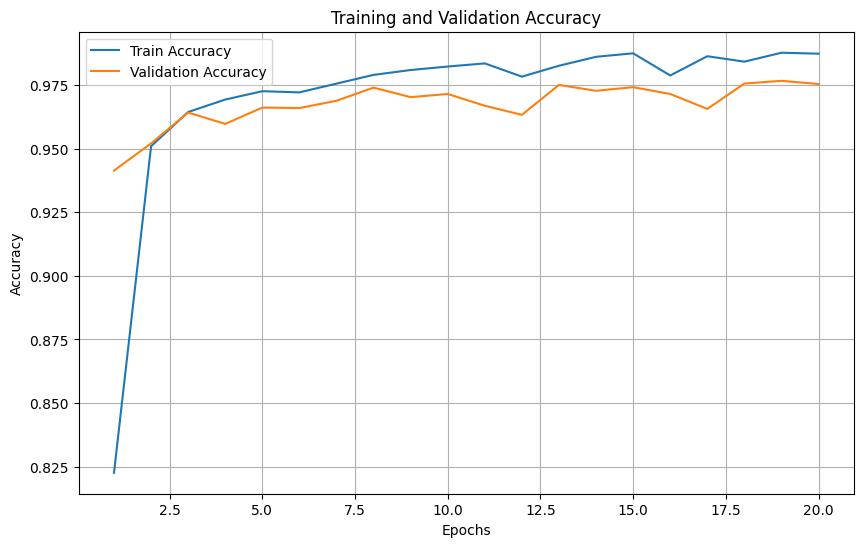

In [93]:
import time
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ProposedCNN().to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001) 

epochs = 20 
train_accuracies = []
val_accuracies = []
start_time = time.time() 

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(augmented_train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_accuracy = correct / total
    train_accuracies.append(train_accuracy)

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in standard_test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_accuracy = correct / total
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(augmented_train_loader):.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

end_time = time.time()
training_time = end_time - start_time
print(f"訓練總時間: {training_time:.2f} 秒")

start_time = time.time()
model.eval()
all_labels = []
all_predictions = []
with torch.no_grad():
    for images, labels in standard_test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

accuracy = accuracy_score(all_labels, all_predictions) * 100
precision = precision_score(all_labels, all_predictions, average='weighted') * 100
recall = recall_score(all_labels, all_predictions, average='weighted') * 100
f1 = f1_score(all_labels, all_predictions, average='weighted') * 100

print(f"測試準確率: {accuracy:.2f}%")
print(f"測試精確率: {precision:.2f}%")
print(f"測試召回率: {recall:.2f}%")
print(f"測試 F1 分數: {f1:.2f}%")

test_time = time.time() - start_time
print(f"測試總時間: {test_time:.2f} 秒")

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

Run 1/10


Run 1, Epoch 1/20: 100%|██████████| 526/526 [00:28<00:00, 18.63it/s]


Epoch 1/20, Loss: 0.5489, Train Accuracy: 0.8382, Validation Accuracy: 0.9401


Run 1, Epoch 2/20: 100%|██████████| 526/526 [00:29<00:00, 17.92it/s]


Epoch 2/20, Loss: 0.1479, Train Accuracy: 0.9537, Validation Accuracy: 0.9556


Run 1, Epoch 3/20: 100%|██████████| 526/526 [00:28<00:00, 18.21it/s]


Epoch 3/20, Loss: 0.1154, Train Accuracy: 0.9637, Validation Accuracy: 0.9604


Run 1, Epoch 4/20: 100%|██████████| 526/526 [00:28<00:00, 18.56it/s]


Epoch 4/20, Loss: 0.1051, Train Accuracy: 0.9677, Validation Accuracy: 0.9535


Run 1, Epoch 5/20: 100%|██████████| 526/526 [00:28<00:00, 18.14it/s]


Epoch 5/20, Loss: 0.1008, Train Accuracy: 0.9695, Validation Accuracy: 0.9690


Run 1, Epoch 6/20: 100%|██████████| 526/526 [00:29<00:00, 17.91it/s]


Epoch 6/20, Loss: 0.0749, Train Accuracy: 0.9756, Validation Accuracy: 0.9594


Run 1, Epoch 7/20: 100%|██████████| 526/526 [00:28<00:00, 18.20it/s]


Epoch 7/20, Loss: 0.0723, Train Accuracy: 0.9768, Validation Accuracy: 0.9706


Run 1, Epoch 8/20: 100%|██████████| 526/526 [00:28<00:00, 18.35it/s]


Epoch 8/20, Loss: 0.0717, Train Accuracy: 0.9773, Validation Accuracy: 0.9759


Run 1, Epoch 9/20: 100%|██████████| 526/526 [00:28<00:00, 18.76it/s]


Epoch 9/20, Loss: 0.0683, Train Accuracy: 0.9782, Validation Accuracy: 0.9786


Run 1, Epoch 10/20: 100%|██████████| 526/526 [00:28<00:00, 18.49it/s]


Epoch 10/20, Loss: 0.0664, Train Accuracy: 0.9796, Validation Accuracy: 0.9717


Run 1, Epoch 11/20: 100%|██████████| 526/526 [00:28<00:00, 18.25it/s]


Epoch 11/20, Loss: 0.0624, Train Accuracy: 0.9809, Validation Accuracy: 0.9754


Run 1, Epoch 12/20: 100%|██████████| 526/526 [00:28<00:00, 18.37it/s]


Epoch 12/20, Loss: 0.0634, Train Accuracy: 0.9803, Validation Accuracy: 0.9824


Run 1, Epoch 13/20: 100%|██████████| 526/526 [00:28<00:00, 18.52it/s]


Epoch 13/20, Loss: 0.0581, Train Accuracy: 0.9824, Validation Accuracy: 0.9797


Run 1, Epoch 14/20: 100%|██████████| 526/526 [00:29<00:00, 17.60it/s]


Epoch 14/20, Loss: 0.0563, Train Accuracy: 0.9824, Validation Accuracy: 0.9791


Run 1, Epoch 15/20: 100%|██████████| 526/526 [00:24<00:00, 21.60it/s]


Epoch 15/20, Loss: 0.0593, Train Accuracy: 0.9819, Validation Accuracy: 0.9791


Run 1, Epoch 16/20: 100%|██████████| 526/526 [00:24<00:00, 21.70it/s]


Epoch 16/20, Loss: 0.0592, Train Accuracy: 0.9824, Validation Accuracy: 0.9770


Run 1, Epoch 17/20: 100%|██████████| 526/526 [00:24<00:00, 21.64it/s]


Epoch 17/20, Loss: 0.0526, Train Accuracy: 0.9834, Validation Accuracy: 0.9797


Run 1, Epoch 18/20: 100%|██████████| 526/526 [00:24<00:00, 21.74it/s]


Epoch 18/20, Loss: 0.0513, Train Accuracy: 0.9843, Validation Accuracy: 0.9743


Run 1, Epoch 19/20: 100%|██████████| 526/526 [00:24<00:00, 21.75it/s]


Epoch 19/20, Loss: 0.0501, Train Accuracy: 0.9841, Validation Accuracy: 0.9829


Run 1, Epoch 20/20: 100%|██████████| 526/526 [00:24<00:00, 21.77it/s]


Epoch 20/20, Loss: 0.0817, Train Accuracy: 0.9794, Validation Accuracy: 0.9770


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Run 1 Results - Accuracy: 97.65%, Precision: 96.59%, Recall: 97.65%, F1 Score: 97.06%
Run 2/10


Run 2, Epoch 1/20: 100%|██████████| 526/526 [00:24<00:00, 21.67it/s]


Epoch 1/20, Loss: 0.5349, Train Accuracy: 0.8450, Validation Accuracy: 0.9390


Run 2, Epoch 2/20: 100%|██████████| 526/526 [00:24<00:00, 21.78it/s]


Epoch 2/20, Loss: 0.1594, Train Accuracy: 0.9506, Validation Accuracy: 0.9433


Run 2, Epoch 3/20: 100%|██████████| 526/526 [00:24<00:00, 21.52it/s]


Epoch 3/20, Loss: 0.1070, Train Accuracy: 0.9655, Validation Accuracy: 0.9722


Run 2, Epoch 4/20: 100%|██████████| 526/526 [00:24<00:00, 21.57it/s]


Epoch 4/20, Loss: 0.0997, Train Accuracy: 0.9683, Validation Accuracy: 0.9706


Run 2, Epoch 5/20: 100%|██████████| 526/526 [00:23<00:00, 21.92it/s]


Epoch 5/20, Loss: 0.0820, Train Accuracy: 0.9732, Validation Accuracy: 0.9711


Run 2, Epoch 6/20: 100%|██████████| 526/526 [00:23<00:00, 21.92it/s]


Epoch 6/20, Loss: 0.0762, Train Accuracy: 0.9765, Validation Accuracy: 0.9733


Run 2, Epoch 7/20: 100%|██████████| 526/526 [00:23<00:00, 21.95it/s]


Epoch 7/20, Loss: 0.0895, Train Accuracy: 0.9724, Validation Accuracy: 0.9743


Run 2, Epoch 8/20: 100%|██████████| 526/526 [00:24<00:00, 21.90it/s]


Epoch 8/20, Loss: 0.0684, Train Accuracy: 0.9791, Validation Accuracy: 0.9759


Run 2, Epoch 9/20: 100%|██████████| 526/526 [00:24<00:00, 21.91it/s]


Epoch 9/20, Loss: 0.0693, Train Accuracy: 0.9783, Validation Accuracy: 0.9749


Run 2, Epoch 10/20: 100%|██████████| 526/526 [00:24<00:00, 21.86it/s]


Epoch 10/20, Loss: 0.0608, Train Accuracy: 0.9812, Validation Accuracy: 0.9797


Run 2, Epoch 11/20: 100%|██████████| 526/526 [00:23<00:00, 22.03it/s]


Epoch 11/20, Loss: 0.0660, Train Accuracy: 0.9788, Validation Accuracy: 0.9786


Run 2, Epoch 12/20: 100%|██████████| 526/526 [00:24<00:00, 21.88it/s]


Epoch 12/20, Loss: 0.0617, Train Accuracy: 0.9807, Validation Accuracy: 0.9754


Run 2, Epoch 13/20: 100%|██████████| 526/526 [00:23<00:00, 21.93it/s]


Epoch 13/20, Loss: 0.0685, Train Accuracy: 0.9794, Validation Accuracy: 0.9781


Run 2, Epoch 14/20: 100%|██████████| 526/526 [00:23<00:00, 21.98it/s]


Epoch 14/20, Loss: 0.0592, Train Accuracy: 0.9826, Validation Accuracy: 0.9770


Run 2, Epoch 15/20: 100%|██████████| 526/526 [00:23<00:00, 21.94it/s]


Epoch 15/20, Loss: 0.0583, Train Accuracy: 0.9829, Validation Accuracy: 0.9818


Run 2, Epoch 16/20: 100%|██████████| 526/526 [00:23<00:00, 22.06it/s]


Epoch 16/20, Loss: 0.0567, Train Accuracy: 0.9827, Validation Accuracy: 0.9770


Run 2, Epoch 17/20: 100%|██████████| 526/526 [00:23<00:00, 21.95it/s]


Epoch 17/20, Loss: 0.0535, Train Accuracy: 0.9829, Validation Accuracy: 0.9786


Run 2, Epoch 18/20: 100%|██████████| 526/526 [00:24<00:00, 21.88it/s]


Epoch 18/20, Loss: 0.0522, Train Accuracy: 0.9837, Validation Accuracy: 0.9775


Run 2, Epoch 19/20: 100%|██████████| 526/526 [00:23<00:00, 22.07it/s]


Epoch 19/20, Loss: 0.0682, Train Accuracy: 0.9805, Validation Accuracy: 0.9765


Run 2, Epoch 20/20: 100%|██████████| 526/526 [00:24<00:00, 21.89it/s]


Epoch 20/20, Loss: 0.0519, Train Accuracy: 0.9837, Validation Accuracy: 0.9797


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Run 2 Results - Accuracy: 97.81%, Precision: 96.73%, Recall: 97.81%, F1 Score: 97.20%
Run 3/10


Run 3, Epoch 1/20: 100%|██████████| 526/526 [00:23<00:00, 21.93it/s]


Epoch 1/20, Loss: 0.5821, Train Accuracy: 0.8317, Validation Accuracy: 0.9481


Run 3, Epoch 2/20: 100%|██████████| 526/526 [00:23<00:00, 22.03it/s]


Epoch 2/20, Loss: 0.1492, Train Accuracy: 0.9535, Validation Accuracy: 0.9556


Run 3, Epoch 3/20: 100%|██████████| 526/526 [00:24<00:00, 21.89it/s]


Epoch 3/20, Loss: 0.1173, Train Accuracy: 0.9632, Validation Accuracy: 0.9658


Run 3, Epoch 4/20: 100%|██████████| 526/526 [00:23<00:00, 21.93it/s]


Epoch 4/20, Loss: 0.1028, Train Accuracy: 0.9674, Validation Accuracy: 0.9642


Run 3, Epoch 5/20: 100%|██████████| 526/526 [00:24<00:00, 21.82it/s]


Epoch 5/20, Loss: 0.0927, Train Accuracy: 0.9712, Validation Accuracy: 0.9717


Run 3, Epoch 6/20: 100%|██████████| 526/526 [00:24<00:00, 21.90it/s]


Epoch 6/20, Loss: 0.0787, Train Accuracy: 0.9744, Validation Accuracy: 0.9722


Run 3, Epoch 7/20: 100%|██████████| 526/526 [00:23<00:00, 22.06it/s]


Epoch 7/20, Loss: 0.0747, Train Accuracy: 0.9767, Validation Accuracy: 0.9786


Run 3, Epoch 8/20: 100%|██████████| 526/526 [00:23<00:00, 21.99it/s]


Epoch 8/20, Loss: 0.0683, Train Accuracy: 0.9781, Validation Accuracy: 0.9807


Run 3, Epoch 9/20: 100%|██████████| 526/526 [00:23<00:00, 22.09it/s]


Epoch 9/20, Loss: 0.0753, Train Accuracy: 0.9773, Validation Accuracy: 0.9765


Run 3, Epoch 10/20: 100%|██████████| 526/526 [00:23<00:00, 22.01it/s]


Epoch 10/20, Loss: 0.0664, Train Accuracy: 0.9799, Validation Accuracy: 0.9759


Run 3, Epoch 11/20: 100%|██████████| 526/526 [00:24<00:00, 21.86it/s]


Epoch 11/20, Loss: 0.0570, Train Accuracy: 0.9815, Validation Accuracy: 0.9770


Run 3, Epoch 12/20: 100%|██████████| 526/526 [00:23<00:00, 21.96it/s]


Epoch 12/20, Loss: 0.0611, Train Accuracy: 0.9809, Validation Accuracy: 0.9749


Run 3, Epoch 13/20: 100%|██████████| 526/526 [00:23<00:00, 22.07it/s]


Epoch 13/20, Loss: 0.0610, Train Accuracy: 0.9808, Validation Accuracy: 0.9781


Run 3, Epoch 14/20: 100%|██████████| 526/526 [00:23<00:00, 21.98it/s]


Epoch 14/20, Loss: 0.0645, Train Accuracy: 0.9802, Validation Accuracy: 0.9813


Run 3, Epoch 15/20: 100%|██████████| 526/526 [00:24<00:00, 21.90it/s]


Epoch 15/20, Loss: 0.0682, Train Accuracy: 0.9798, Validation Accuracy: 0.9690


Run 3, Epoch 16/20: 100%|██████████| 526/526 [00:23<00:00, 22.13it/s]


Epoch 16/20, Loss: 0.0630, Train Accuracy: 0.9825, Validation Accuracy: 0.9807


Run 3, Epoch 17/20: 100%|██████████| 526/526 [00:23<00:00, 22.06it/s]


Epoch 17/20, Loss: 0.0519, Train Accuracy: 0.9832, Validation Accuracy: 0.9818


Run 3, Epoch 18/20: 100%|██████████| 526/526 [00:24<00:00, 21.79it/s]


Epoch 18/20, Loss: 0.0536, Train Accuracy: 0.9843, Validation Accuracy: 0.9797


Run 3, Epoch 19/20: 100%|██████████| 526/526 [00:23<00:00, 21.99it/s]


Epoch 19/20, Loss: 0.0574, Train Accuracy: 0.9822, Validation Accuracy: 0.9695


Run 3, Epoch 20/20: 100%|██████████| 526/526 [00:23<00:00, 21.99it/s]


Epoch 20/20, Loss: 0.0560, Train Accuracy: 0.9822, Validation Accuracy: 0.9583


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Run 3 Results - Accuracy: 95.83%, Precision: 95.54%, Recall: 95.83%, F1 Score: 95.34%
Run 4/10


Run 4, Epoch 1/20: 100%|██████████| 526/526 [00:24<00:00, 21.67it/s]


Epoch 1/20, Loss: 0.4903, Train Accuracy: 0.8529, Validation Accuracy: 0.9535


Run 4, Epoch 2/20: 100%|██████████| 526/526 [00:28<00:00, 18.28it/s]


Epoch 2/20, Loss: 0.1448, Train Accuracy: 0.9546, Validation Accuracy: 0.9626


Run 4, Epoch 3/20: 100%|██████████| 526/526 [00:28<00:00, 18.39it/s]


Epoch 3/20, Loss: 0.1062, Train Accuracy: 0.9659, Validation Accuracy: 0.9588


Run 4, Epoch 4/20: 100%|██████████| 526/526 [00:28<00:00, 18.49it/s]


Epoch 4/20, Loss: 0.0947, Train Accuracy: 0.9703, Validation Accuracy: 0.9690


Run 4, Epoch 5/20: 100%|██████████| 526/526 [00:28<00:00, 18.31it/s]


Epoch 5/20, Loss: 0.0887, Train Accuracy: 0.9729, Validation Accuracy: 0.9706


Run 4, Epoch 6/20: 100%|██████████| 526/526 [00:28<00:00, 18.35it/s]


Epoch 6/20, Loss: 0.0829, Train Accuracy: 0.9752, Validation Accuracy: 0.9733


Run 4, Epoch 7/20: 100%|██████████| 526/526 [00:28<00:00, 18.63it/s]


Epoch 7/20, Loss: 0.0736, Train Accuracy: 0.9766, Validation Accuracy: 0.9743


Run 4, Epoch 8/20: 100%|██████████| 526/526 [00:31<00:00, 16.91it/s]


Epoch 8/20, Loss: 0.0740, Train Accuracy: 0.9775, Validation Accuracy: 0.9802


Run 4, Epoch 9/20: 100%|██████████| 526/526 [00:24<00:00, 21.91it/s]


Epoch 9/20, Loss: 0.0679, Train Accuracy: 0.9794, Validation Accuracy: 0.9674


Run 4, Epoch 10/20: 100%|██████████| 526/526 [00:24<00:00, 21.80it/s]


Epoch 10/20, Loss: 0.0753, Train Accuracy: 0.9768, Validation Accuracy: 0.9775


Run 4, Epoch 11/20: 100%|██████████| 526/526 [00:24<00:00, 21.72it/s]


Epoch 11/20, Loss: 0.0578, Train Accuracy: 0.9811, Validation Accuracy: 0.9802


Run 4, Epoch 12/20: 100%|██████████| 526/526 [00:24<00:00, 21.57it/s]


Epoch 12/20, Loss: 0.0551, Train Accuracy: 0.9825, Validation Accuracy: 0.9733


Run 4, Epoch 13/20: 100%|██████████| 526/526 [00:24<00:00, 21.69it/s]


Epoch 13/20, Loss: 0.0636, Train Accuracy: 0.9807, Validation Accuracy: 0.9818


Run 4, Epoch 14/20: 100%|██████████| 526/526 [00:24<00:00, 21.58it/s]


Epoch 14/20, Loss: 0.0685, Train Accuracy: 0.9801, Validation Accuracy: 0.9791


Run 4, Epoch 15/20: 100%|██████████| 526/526 [00:24<00:00, 21.65it/s]


Epoch 15/20, Loss: 0.0580, Train Accuracy: 0.9829, Validation Accuracy: 0.9813


Run 4, Epoch 16/20: 100%|██████████| 526/526 [00:24<00:00, 21.69it/s]


Epoch 16/20, Loss: 0.0540, Train Accuracy: 0.9832, Validation Accuracy: 0.9754


Run 4, Epoch 17/20: 100%|██████████| 526/526 [00:24<00:00, 21.59it/s]


Epoch 17/20, Loss: 0.0527, Train Accuracy: 0.9838, Validation Accuracy: 0.9802


Run 4, Epoch 18/20: 100%|██████████| 526/526 [00:24<00:00, 21.62it/s]


Epoch 18/20, Loss: 0.0485, Train Accuracy: 0.9849, Validation Accuracy: 0.9807


Run 4, Epoch 19/20: 100%|██████████| 526/526 [00:24<00:00, 21.60it/s]


Epoch 19/20, Loss: 0.0530, Train Accuracy: 0.9839, Validation Accuracy: 0.9824


Run 4, Epoch 20/20: 100%|██████████| 526/526 [00:24<00:00, 21.79it/s]


Epoch 20/20, Loss: 0.0529, Train Accuracy: 0.9838, Validation Accuracy: 0.9818


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Run 4 Results - Accuracy: 98.13%, Precision: 97.06%, Recall: 98.13%, F1 Score: 97.54%
Run 5/10


Run 5, Epoch 1/20: 100%|██████████| 526/526 [00:24<00:00, 21.47it/s]


Epoch 1/20, Loss: 0.5629, Train Accuracy: 0.8252, Validation Accuracy: 0.9471


Run 5, Epoch 2/20: 100%|██████████| 526/526 [00:24<00:00, 21.61it/s]


Epoch 2/20, Loss: 0.1456, Train Accuracy: 0.9543, Validation Accuracy: 0.9599


Run 5, Epoch 3/20: 100%|██████████| 526/526 [00:24<00:00, 21.72it/s]


Epoch 3/20, Loss: 0.1085, Train Accuracy: 0.9665, Validation Accuracy: 0.9695


Run 5, Epoch 4/20: 100%|██████████| 526/526 [00:24<00:00, 21.75it/s]


Epoch 4/20, Loss: 0.0923, Train Accuracy: 0.9712, Validation Accuracy: 0.9642


Run 5, Epoch 5/20: 100%|██████████| 526/526 [00:24<00:00, 21.72it/s]


Epoch 5/20, Loss: 0.0869, Train Accuracy: 0.9724, Validation Accuracy: 0.9679


Run 5, Epoch 6/20: 100%|██████████| 526/526 [00:24<00:00, 21.64it/s]


Epoch 6/20, Loss: 0.0762, Train Accuracy: 0.9759, Validation Accuracy: 0.9717


Run 5, Epoch 7/20: 100%|██████████| 526/526 [00:24<00:00, 21.71it/s]


Epoch 7/20, Loss: 0.0661, Train Accuracy: 0.9792, Validation Accuracy: 0.9749


Run 5, Epoch 8/20: 100%|██████████| 526/526 [00:24<00:00, 21.70it/s]


Epoch 8/20, Loss: 0.0719, Train Accuracy: 0.9781, Validation Accuracy: 0.9743


Run 5, Epoch 9/20: 100%|██████████| 526/526 [00:24<00:00, 21.67it/s]


Epoch 9/20, Loss: 0.0637, Train Accuracy: 0.9807, Validation Accuracy: 0.9813


Run 5, Epoch 10/20: 100%|██████████| 526/526 [00:24<00:00, 21.72it/s]


Epoch 10/20, Loss: 0.0648, Train Accuracy: 0.9800, Validation Accuracy: 0.9754


Run 5, Epoch 11/20: 100%|██████████| 526/526 [00:24<00:00, 21.67it/s]


Epoch 11/20, Loss: 0.0679, Train Accuracy: 0.9800, Validation Accuracy: 0.9722


Run 5, Epoch 12/20: 100%|██████████| 526/526 [00:24<00:00, 21.56it/s]


Epoch 12/20, Loss: 0.0571, Train Accuracy: 0.9817, Validation Accuracy: 0.9791


Run 5, Epoch 13/20: 100%|██████████| 526/526 [00:24<00:00, 21.65it/s]


Epoch 13/20, Loss: 0.0539, Train Accuracy: 0.9839, Validation Accuracy: 0.9759


Run 5, Epoch 14/20: 100%|██████████| 526/526 [00:24<00:00, 21.58it/s]


Epoch 14/20, Loss: 0.0582, Train Accuracy: 0.9817, Validation Accuracy: 0.9759


Run 5, Epoch 15/20: 100%|██████████| 526/526 [00:24<00:00, 21.63it/s]


Epoch 15/20, Loss: 0.0592, Train Accuracy: 0.9822, Validation Accuracy: 0.9754


Run 5, Epoch 16/20: 100%|██████████| 526/526 [00:24<00:00, 21.57it/s]


Epoch 16/20, Loss: 0.0614, Train Accuracy: 0.9812, Validation Accuracy: 0.9818


Run 5, Epoch 17/20: 100%|██████████| 526/526 [00:24<00:00, 21.48it/s]


Epoch 17/20, Loss: 0.0522, Train Accuracy: 0.9830, Validation Accuracy: 0.9807


Run 5, Epoch 18/20: 100%|██████████| 526/526 [00:24<00:00, 21.74it/s]


Epoch 18/20, Loss: 0.0517, Train Accuracy: 0.9838, Validation Accuracy: 0.9797


Run 5, Epoch 19/20: 100%|██████████| 526/526 [00:24<00:00, 21.68it/s]


Epoch 19/20, Loss: 0.0491, Train Accuracy: 0.9850, Validation Accuracy: 0.9791


Run 5, Epoch 20/20: 100%|██████████| 526/526 [00:24<00:00, 21.65it/s]


Epoch 20/20, Loss: 0.0516, Train Accuracy: 0.9841, Validation Accuracy: 0.9802


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Run 5 Results - Accuracy: 97.81%, Precision: 96.81%, Recall: 97.81%, F1 Score: 97.22%
Run 6/10


Run 6, Epoch 1/20: 100%|██████████| 526/526 [00:24<00:00, 21.55it/s]


Epoch 1/20, Loss: 0.4957, Train Accuracy: 0.8517, Validation Accuracy: 0.9513


Run 6, Epoch 2/20: 100%|██████████| 526/526 [00:24<00:00, 21.66it/s]


Epoch 2/20, Loss: 0.1524, Train Accuracy: 0.9528, Validation Accuracy: 0.9636


Run 6, Epoch 3/20: 100%|██████████| 526/526 [00:24<00:00, 21.57it/s]


Epoch 3/20, Loss: 0.1087, Train Accuracy: 0.9655, Validation Accuracy: 0.9647


Run 6, Epoch 4/20: 100%|██████████| 526/526 [00:24<00:00, 21.59it/s]


Epoch 4/20, Loss: 0.0974, Train Accuracy: 0.9684, Validation Accuracy: 0.9706


Run 6, Epoch 5/20: 100%|██████████| 526/526 [00:24<00:00, 21.61it/s]


Epoch 5/20, Loss: 0.0850, Train Accuracy: 0.9731, Validation Accuracy: 0.9610


Run 6, Epoch 6/20: 100%|██████████| 526/526 [00:24<00:00, 21.74it/s]


Epoch 6/20, Loss: 0.0854, Train Accuracy: 0.9737, Validation Accuracy: 0.9695


Run 6, Epoch 7/20: 100%|██████████| 526/526 [00:24<00:00, 21.73it/s]


Epoch 7/20, Loss: 0.0770, Train Accuracy: 0.9765, Validation Accuracy: 0.9668


Run 6, Epoch 8/20: 100%|██████████| 526/526 [00:24<00:00, 21.59it/s]


Epoch 8/20, Loss: 0.0705, Train Accuracy: 0.9772, Validation Accuracy: 0.9754


Run 6, Epoch 9/20: 100%|██████████| 526/526 [00:24<00:00, 21.62it/s]


Epoch 9/20, Loss: 0.0795, Train Accuracy: 0.9755, Validation Accuracy: 0.9711


Run 6, Epoch 10/20: 100%|██████████| 526/526 [00:24<00:00, 21.66it/s]


Epoch 10/20, Loss: 0.0734, Train Accuracy: 0.9780, Validation Accuracy: 0.9749


Run 6, Epoch 11/20: 100%|██████████| 526/526 [00:24<00:00, 21.68it/s]


Epoch 11/20, Loss: 0.0623, Train Accuracy: 0.9804, Validation Accuracy: 0.9770


Run 6, Epoch 12/20: 100%|██████████| 526/526 [00:24<00:00, 21.72it/s]


Epoch 12/20, Loss: 0.0614, Train Accuracy: 0.9809, Validation Accuracy: 0.9754


Run 6, Epoch 13/20: 100%|██████████| 526/526 [00:24<00:00, 21.61it/s]


Epoch 13/20, Loss: 0.0603, Train Accuracy: 0.9815, Validation Accuracy: 0.9727


Run 6, Epoch 14/20: 100%|██████████| 526/526 [00:24<00:00, 21.42it/s]


Epoch 14/20, Loss: 0.0534, Train Accuracy: 0.9835, Validation Accuracy: 0.9807


Run 6, Epoch 15/20: 100%|██████████| 526/526 [00:24<00:00, 21.57it/s]


Epoch 15/20, Loss: 0.0555, Train Accuracy: 0.9834, Validation Accuracy: 0.9749


Run 6, Epoch 16/20: 100%|██████████| 526/526 [00:24<00:00, 21.68it/s]


Epoch 16/20, Loss: 0.0576, Train Accuracy: 0.9826, Validation Accuracy: 0.9759


Run 6, Epoch 17/20: 100%|██████████| 526/526 [00:24<00:00, 21.59it/s]


Epoch 17/20, Loss: 0.0609, Train Accuracy: 0.9828, Validation Accuracy: 0.9775


Run 6, Epoch 18/20: 100%|██████████| 526/526 [00:27<00:00, 19.19it/s]


Epoch 18/20, Loss: 0.0572, Train Accuracy: 0.9822, Validation Accuracy: 0.9834


Run 6, Epoch 19/20: 100%|██████████| 526/526 [00:28<00:00, 18.51it/s]


Epoch 19/20, Loss: 0.0516, Train Accuracy: 0.9838, Validation Accuracy: 0.9786


Run 6, Epoch 20/20: 100%|██████████| 526/526 [00:28<00:00, 18.70it/s]


Epoch 20/20, Loss: 0.0529, Train Accuracy: 0.9837, Validation Accuracy: 0.9781


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Run 6 Results - Accuracy: 98.02%, Precision: 96.96%, Recall: 98.02%, F1 Score: 97.43%
Run 7/10


Run 7, Epoch 1/20: 100%|██████████| 526/526 [00:28<00:00, 18.43it/s]


Epoch 1/20, Loss: 0.5542, Train Accuracy: 0.8332, Validation Accuracy: 0.9513


Run 7, Epoch 2/20: 100%|██████████| 526/526 [00:28<00:00, 18.53it/s]


Epoch 2/20, Loss: 0.1508, Train Accuracy: 0.9545, Validation Accuracy: 0.9652


Run 7, Epoch 3/20: 100%|██████████| 526/526 [00:28<00:00, 18.64it/s]


Epoch 3/20, Loss: 0.1187, Train Accuracy: 0.9635, Validation Accuracy: 0.9695


Run 7, Epoch 4/20: 100%|██████████| 526/526 [00:28<00:00, 18.73it/s]


Epoch 4/20, Loss: 0.0945, Train Accuracy: 0.9692, Validation Accuracy: 0.9706


Run 7, Epoch 5/20: 100%|██████████| 526/526 [00:27<00:00, 18.83it/s]


Epoch 5/20, Loss: 0.0797, Train Accuracy: 0.9743, Validation Accuracy: 0.9759


Run 7, Epoch 6/20: 100%|██████████| 526/526 [00:27<00:00, 18.90it/s]


Epoch 6/20, Loss: 0.0740, Train Accuracy: 0.9767, Validation Accuracy: 0.9674


Run 7, Epoch 7/20: 100%|██████████| 526/526 [00:27<00:00, 18.89it/s]


Epoch 7/20, Loss: 0.0829, Train Accuracy: 0.9759, Validation Accuracy: 0.9658


Run 7, Epoch 8/20: 100%|██████████| 526/526 [00:28<00:00, 18.60it/s]


Epoch 8/20, Loss: 0.0708, Train Accuracy: 0.9781, Validation Accuracy: 0.9743


Run 7, Epoch 9/20: 100%|██████████| 526/526 [00:28<00:00, 18.30it/s]


Epoch 9/20, Loss: 0.0712, Train Accuracy: 0.9772, Validation Accuracy: 0.9781


Run 7, Epoch 10/20: 100%|██████████| 526/526 [00:28<00:00, 18.53it/s]


Epoch 10/20, Loss: 0.0588, Train Accuracy: 0.9829, Validation Accuracy: 0.9690


Run 7, Epoch 11/20: 100%|██████████| 526/526 [00:27<00:00, 18.81it/s]


Epoch 11/20, Loss: 0.0576, Train Accuracy: 0.9821, Validation Accuracy: 0.9770


Run 7, Epoch 12/20: 100%|██████████| 526/526 [00:27<00:00, 18.94it/s]


Epoch 12/20, Loss: 0.0752, Train Accuracy: 0.9788, Validation Accuracy: 0.9733


Run 7, Epoch 13/20: 100%|██████████| 526/526 [00:27<00:00, 18.92it/s]


Epoch 13/20, Loss: 0.0656, Train Accuracy: 0.9815, Validation Accuracy: 0.9791


Run 7, Epoch 14/20: 100%|██████████| 526/526 [00:27<00:00, 18.90it/s]


Epoch 14/20, Loss: 0.0502, Train Accuracy: 0.9845, Validation Accuracy: 0.9824


Run 7, Epoch 15/20: 100%|██████████| 526/526 [00:27<00:00, 18.97it/s]


Epoch 15/20, Loss: 0.0553, Train Accuracy: 0.9825, Validation Accuracy: 0.9759


Run 7, Epoch 16/20: 100%|██████████| 526/526 [00:27<00:00, 18.87it/s]


Epoch 16/20, Loss: 0.0594, Train Accuracy: 0.9821, Validation Accuracy: 0.9668


Run 7, Epoch 17/20: 100%|██████████| 526/526 [00:29<00:00, 17.68it/s]


Epoch 17/20, Loss: 0.0536, Train Accuracy: 0.9834, Validation Accuracy: 0.9738


Run 7, Epoch 18/20: 100%|██████████| 526/526 [00:28<00:00, 18.65it/s]


Epoch 18/20, Loss: 0.0514, Train Accuracy: 0.9839, Validation Accuracy: 0.9834


Run 7, Epoch 19/20: 100%|██████████| 526/526 [00:27<00:00, 18.89it/s]


Epoch 19/20, Loss: 0.0453, Train Accuracy: 0.9859, Validation Accuracy: 0.9749


Run 7, Epoch 20/20: 100%|██████████| 526/526 [00:27<00:00, 18.81it/s]


Epoch 20/20, Loss: 0.0617, Train Accuracy: 0.9807, Validation Accuracy: 0.9701


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Run 7 Results - Accuracy: 97.33%, Precision: 96.62%, Recall: 97.33%, F1 Score: 96.70%
Run 8/10


Run 8, Epoch 1/20: 100%|██████████| 526/526 [00:28<00:00, 18.71it/s]


Epoch 1/20, Loss: 0.5601, Train Accuracy: 0.8329, Validation Accuracy: 0.9176


Run 8, Epoch 2/20: 100%|██████████| 526/526 [00:27<00:00, 18.84it/s]


Epoch 2/20, Loss: 0.1508, Train Accuracy: 0.9551, Validation Accuracy: 0.9626


Run 8, Epoch 3/20: 100%|██████████| 526/526 [00:27<00:00, 18.86it/s]


Epoch 3/20, Loss: 0.1111, Train Accuracy: 0.9643, Validation Accuracy: 0.9647


Run 8, Epoch 4/20: 100%|██████████| 526/526 [00:28<00:00, 18.75it/s]


Epoch 4/20, Loss: 0.0899, Train Accuracy: 0.9722, Validation Accuracy: 0.9701


Run 8, Epoch 5/20: 100%|██████████| 526/526 [00:27<00:00, 18.85it/s]


Epoch 5/20, Loss: 0.0957, Train Accuracy: 0.9698, Validation Accuracy: 0.9615


Run 8, Epoch 6/20: 100%|██████████| 526/526 [00:27<00:00, 18.79it/s]


Epoch 6/20, Loss: 0.0830, Train Accuracy: 0.9746, Validation Accuracy: 0.9706


Run 8, Epoch 7/20: 100%|██████████| 526/526 [00:27<00:00, 18.88it/s]


Epoch 7/20, Loss: 0.0721, Train Accuracy: 0.9768, Validation Accuracy: 0.9781


Run 8, Epoch 8/20: 100%|██████████| 526/526 [00:27<00:00, 18.89it/s]


Epoch 8/20, Loss: 0.0720, Train Accuracy: 0.9768, Validation Accuracy: 0.9781


Run 8, Epoch 9/20: 100%|██████████| 526/526 [00:27<00:00, 18.88it/s]


Epoch 9/20, Loss: 0.0772, Train Accuracy: 0.9759, Validation Accuracy: 0.9749


Run 8, Epoch 10/20: 100%|██████████| 526/526 [00:28<00:00, 18.66it/s]


Epoch 10/20, Loss: 0.0638, Train Accuracy: 0.9799, Validation Accuracy: 0.9786


Run 8, Epoch 11/20: 100%|██████████| 526/526 [00:28<00:00, 18.73it/s]


Epoch 11/20, Loss: 0.0655, Train Accuracy: 0.9804, Validation Accuracy: 0.9759


Run 8, Epoch 12/20: 100%|██████████| 526/526 [00:27<00:00, 18.82it/s]


Epoch 12/20, Loss: 0.0585, Train Accuracy: 0.9822, Validation Accuracy: 0.9775


Run 8, Epoch 13/20: 100%|██████████| 526/526 [00:27<00:00, 18.79it/s]


Epoch 13/20, Loss: 0.0527, Train Accuracy: 0.9835, Validation Accuracy: 0.9818


Run 8, Epoch 14/20: 100%|██████████| 526/526 [00:27<00:00, 18.86it/s]


Epoch 14/20, Loss: 0.0556, Train Accuracy: 0.9827, Validation Accuracy: 0.9759


Run 8, Epoch 15/20: 100%|██████████| 526/526 [00:27<00:00, 18.79it/s]


Epoch 15/20, Loss: 0.0609, Train Accuracy: 0.9819, Validation Accuracy: 0.9802


Run 8, Epoch 16/20: 100%|██████████| 526/526 [00:27<00:00, 18.80it/s]


Epoch 16/20, Loss: 0.0561, Train Accuracy: 0.9828, Validation Accuracy: 0.9791


Run 8, Epoch 17/20: 100%|██████████| 526/526 [00:26<00:00, 19.55it/s]


Epoch 17/20, Loss: 0.0552, Train Accuracy: 0.9828, Validation Accuracy: 0.9786


Run 8, Epoch 18/20: 100%|██████████| 526/526 [00:27<00:00, 18.82it/s]


Epoch 18/20, Loss: 0.0591, Train Accuracy: 0.9822, Validation Accuracy: 0.9791


Run 8, Epoch 19/20: 100%|██████████| 526/526 [00:27<00:00, 18.87it/s]


Epoch 19/20, Loss: 0.0508, Train Accuracy: 0.9841, Validation Accuracy: 0.9824


Run 8, Epoch 20/20: 100%|██████████| 526/526 [00:27<00:00, 18.86it/s]


Epoch 20/20, Loss: 0.0444, Train Accuracy: 0.9865, Validation Accuracy: 0.9797


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Run 8 Results - Accuracy: 97.91%, Precision: 96.85%, Recall: 97.91%, F1 Score: 97.33%
Run 9/10


Run 9, Epoch 1/20: 100%|██████████| 526/526 [00:27<00:00, 18.89it/s]


Epoch 1/20, Loss: 0.5136, Train Accuracy: 0.8486, Validation Accuracy: 0.9219


Run 9, Epoch 2/20: 100%|██████████| 526/526 [00:27<00:00, 18.86it/s]


Epoch 2/20, Loss: 0.1543, Train Accuracy: 0.9541, Validation Accuracy: 0.9663


Run 9, Epoch 3/20: 100%|██████████| 526/526 [00:27<00:00, 18.79it/s]


Epoch 3/20, Loss: 0.1150, Train Accuracy: 0.9635, Validation Accuracy: 0.9631


Run 9, Epoch 4/20: 100%|██████████| 526/526 [00:27<00:00, 18.84it/s]


Epoch 4/20, Loss: 0.1003, Train Accuracy: 0.9687, Validation Accuracy: 0.9727


Run 9, Epoch 5/20: 100%|██████████| 526/526 [00:28<00:00, 18.77it/s]


Epoch 5/20, Loss: 0.0891, Train Accuracy: 0.9718, Validation Accuracy: 0.9615


Run 9, Epoch 6/20: 100%|██████████| 526/526 [00:27<00:00, 18.85it/s]


Epoch 6/20, Loss: 0.0815, Train Accuracy: 0.9746, Validation Accuracy: 0.9765


Run 9, Epoch 7/20: 100%|██████████| 526/526 [00:28<00:00, 18.78it/s]


Epoch 7/20, Loss: 0.0730, Train Accuracy: 0.9777, Validation Accuracy: 0.9668


Run 9, Epoch 8/20: 100%|██████████| 526/526 [00:28<00:00, 18.76it/s]


Epoch 8/20, Loss: 0.0695, Train Accuracy: 0.9773, Validation Accuracy: 0.9727


Run 9, Epoch 9/20: 100%|██████████| 526/526 [00:28<00:00, 18.73it/s]


Epoch 9/20, Loss: 0.0681, Train Accuracy: 0.9790, Validation Accuracy: 0.9717


Run 9, Epoch 10/20: 100%|██████████| 526/526 [00:28<00:00, 18.69it/s]


Epoch 10/20, Loss: 0.0679, Train Accuracy: 0.9793, Validation Accuracy: 0.9786


Run 9, Epoch 11/20: 100%|██████████| 526/526 [00:28<00:00, 18.68it/s]


Epoch 11/20, Loss: 0.0669, Train Accuracy: 0.9808, Validation Accuracy: 0.9818


Run 9, Epoch 12/20: 100%|██████████| 526/526 [00:27<00:00, 18.94it/s]


Epoch 12/20, Loss: 0.0601, Train Accuracy: 0.9816, Validation Accuracy: 0.9807


Run 9, Epoch 13/20: 100%|██████████| 526/526 [00:27<00:00, 18.90it/s]


Epoch 13/20, Loss: 0.0670, Train Accuracy: 0.9791, Validation Accuracy: 0.9759


Run 9, Epoch 14/20: 100%|██████████| 526/526 [00:27<00:00, 18.87it/s]


Epoch 14/20, Loss: 0.0788, Train Accuracy: 0.9794, Validation Accuracy: 0.9797


Run 9, Epoch 15/20: 100%|██████████| 526/526 [00:27<00:00, 18.90it/s]


Epoch 15/20, Loss: 0.0523, Train Accuracy: 0.9834, Validation Accuracy: 0.9802


Run 9, Epoch 16/20: 100%|██████████| 526/526 [00:27<00:00, 18.90it/s]


Epoch 16/20, Loss: 0.0569, Train Accuracy: 0.9831, Validation Accuracy: 0.9791


Run 9, Epoch 17/20: 100%|██████████| 526/526 [00:28<00:00, 18.54it/s]


Epoch 17/20, Loss: 0.0569, Train Accuracy: 0.9825, Validation Accuracy: 0.9786


Run 9, Epoch 18/20: 100%|██████████| 526/526 [00:28<00:00, 18.67it/s]


Epoch 18/20, Loss: 0.0563, Train Accuracy: 0.9829, Validation Accuracy: 0.9781


Run 9, Epoch 19/20: 100%|██████████| 526/526 [00:28<00:00, 18.78it/s]


Epoch 19/20, Loss: 0.0517, Train Accuracy: 0.9844, Validation Accuracy: 0.9765


Run 9, Epoch 20/20: 100%|██████████| 526/526 [00:27<00:00, 18.87it/s]


Epoch 20/20, Loss: 0.0553, Train Accuracy: 0.9836, Validation Accuracy: 0.9829


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Run 9 Results - Accuracy: 98.18%, Precision: 97.10%, Recall: 98.18%, F1 Score: 97.59%
Run 10/10


Run 10, Epoch 1/20: 100%|██████████| 526/526 [00:27<00:00, 18.84it/s]


Epoch 1/20, Loss: 0.5582, Train Accuracy: 0.8311, Validation Accuracy: 0.9353


Run 10, Epoch 2/20: 100%|██████████| 526/526 [00:27<00:00, 18.86it/s]


Epoch 2/20, Loss: 0.1558, Train Accuracy: 0.9516, Validation Accuracy: 0.9487


Run 10, Epoch 3/20: 100%|██████████| 526/526 [00:27<00:00, 18.85it/s]


Epoch 3/20, Loss: 0.1151, Train Accuracy: 0.9635, Validation Accuracy: 0.9604


Run 10, Epoch 4/20: 100%|██████████| 526/526 [00:27<00:00, 18.81it/s]


Epoch 4/20, Loss: 0.0913, Train Accuracy: 0.9715, Validation Accuracy: 0.9551


Run 10, Epoch 5/20: 100%|██████████| 526/526 [00:28<00:00, 18.70it/s]


Epoch 5/20, Loss: 0.0903, Train Accuracy: 0.9714, Validation Accuracy: 0.9668


Run 10, Epoch 6/20: 100%|██████████| 526/526 [00:28<00:00, 18.70it/s]


Epoch 6/20, Loss: 0.0755, Train Accuracy: 0.9768, Validation Accuracy: 0.9706


Run 10, Epoch 7/20: 100%|██████████| 526/526 [00:28<00:00, 18.72it/s]


Epoch 7/20, Loss: 0.0845, Train Accuracy: 0.9732, Validation Accuracy: 0.9636


Run 10, Epoch 8/20: 100%|██████████| 526/526 [00:27<00:00, 18.79it/s]


Epoch 8/20, Loss: 0.0677, Train Accuracy: 0.9791, Validation Accuracy: 0.9754


Run 10, Epoch 9/20: 100%|██████████| 526/526 [00:27<00:00, 18.93it/s]


Epoch 9/20, Loss: 0.0797, Train Accuracy: 0.9765, Validation Accuracy: 0.9765


Run 10, Epoch 10/20: 100%|██████████| 526/526 [00:27<00:00, 18.85it/s]


Epoch 10/20, Loss: 0.0633, Train Accuracy: 0.9804, Validation Accuracy: 0.9807


Run 10, Epoch 11/20: 100%|██████████| 526/526 [00:28<00:00, 18.76it/s]


Epoch 11/20, Loss: 0.0614, Train Accuracy: 0.9815, Validation Accuracy: 0.9807


Run 10, Epoch 12/20: 100%|██████████| 526/526 [00:28<00:00, 18.78it/s]


Epoch 12/20, Loss: 0.0538, Train Accuracy: 0.9827, Validation Accuracy: 0.9797


Run 10, Epoch 13/20: 100%|██████████| 526/526 [00:28<00:00, 18.75it/s]


Epoch 13/20, Loss: 0.0686, Train Accuracy: 0.9802, Validation Accuracy: 0.9706


Run 10, Epoch 14/20: 100%|██████████| 526/526 [00:28<00:00, 18.77it/s]


Epoch 14/20, Loss: 0.0718, Train Accuracy: 0.9799, Validation Accuracy: 0.9797


Run 10, Epoch 15/20: 100%|██████████| 526/526 [00:28<00:00, 18.76it/s]


Epoch 15/20, Loss: 0.0547, Train Accuracy: 0.9821, Validation Accuracy: 0.9727


Run 10, Epoch 16/20: 100%|██████████| 526/526 [00:27<00:00, 18.81it/s]


Epoch 16/20, Loss: 0.0829, Train Accuracy: 0.9751, Validation Accuracy: 0.9754


Run 10, Epoch 17/20: 100%|██████████| 526/526 [00:28<00:00, 18.53it/s]


Epoch 17/20, Loss: 0.0685, Train Accuracy: 0.9808, Validation Accuracy: 0.9781


Run 10, Epoch 18/20: 100%|██████████| 526/526 [00:28<00:00, 18.57it/s]


Epoch 18/20, Loss: 0.0462, Train Accuracy: 0.9854, Validation Accuracy: 0.9813


Run 10, Epoch 19/20: 100%|██████████| 526/526 [00:27<00:00, 18.83it/s]


Epoch 19/20, Loss: 0.0494, Train Accuracy: 0.9851, Validation Accuracy: 0.9754


Run 10, Epoch 20/20: 100%|██████████| 526/526 [00:27<00:00, 18.82it/s]


Epoch 20/20, Loss: 0.0482, Train Accuracy: 0.9847, Validation Accuracy: 0.9759
Run 10 Results - Accuracy: 97.70%, Precision: 96.69%, Recall: 97.70%, F1 Score: 97.10%

Final Results (Average over 10 runs):
Average Accuracy: 97.64%
Average Precision: 96.69%
Average Recall: 97.64%
Average F1 Score: 97.05%


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


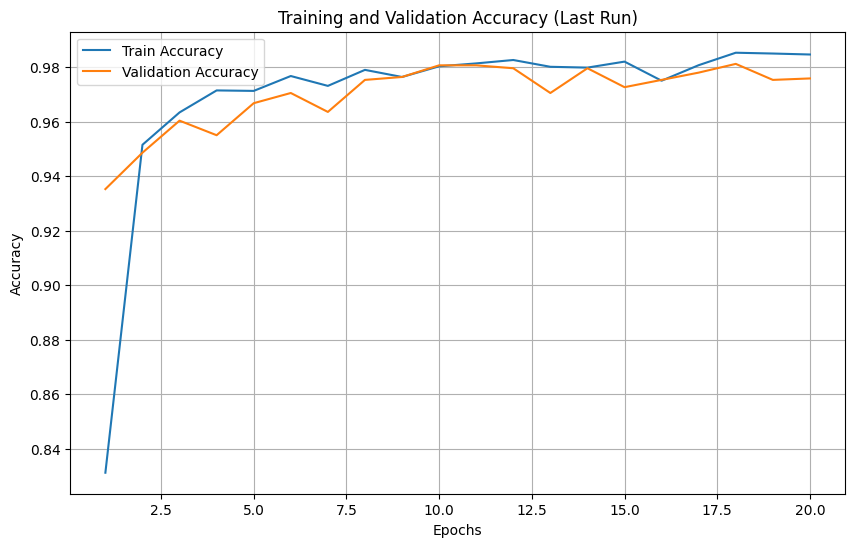

In [96]:
import time
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

epochs = 20 
num_runs = 10 
run_accuracies = []
run_precisions = []
run_recalls = []
run_f1_scores = []

for run in range(num_runs):
    print(f"Run {run + 1}/{num_runs}")
    model = ProposedCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(augmented_train_loader, desc=f"Run {run + 1}, Epoch {epoch + 1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_accuracy = correct / total
        train_accuracies.append(train_accuracy)

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in standard_test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_accuracy = correct / total
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(augmented_train_loader):.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in standard_test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions) * 100
    precision = precision_score(all_labels, all_predictions, average='weighted') * 100
    recall = recall_score(all_labels, all_predictions, average='weighted') * 100
    f1 = f1_score(all_labels, all_predictions, average='weighted') * 100

    print(f"Run {run + 1} Results - Accuracy: {accuracy:.2f}%, Precision: {precision:.2f}%, Recall: {recall:.2f}%, F1 Score: {f1:.2f}%")

    run_accuracies.append(accuracy)
    run_precisions.append(precision)
    run_recalls.append(recall)
    run_f1_scores.append(f1)

avg_accuracy = np.mean(run_accuracies)
avg_precision = np.mean(run_precisions)
avg_recall = np.mean(run_recalls)
avg_f1 = np.mean(run_f1_scores)

print("\nFinal Results (Average over 10 runs):")
print(f"Average Accuracy: {avg_accuracy:.2f}%")
print(f"Average Precision: {avg_precision:.2f}%")
print(f"Average Recall: {avg_recall:.2f}%")
print(f"Average F1 Score: {avg_f1:.2f}%")

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (Last Run)')
plt.legend()
plt.grid()
plt.show()

## CNN + SVM

In [62]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, models
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
kf = KFold(n_splits=10, shuffle=True, random_state=42)
fold_accuracies_cnn = []
fold_accuracies_svm = []

for fold, (train_idx, test_idx) in enumerate(kf.split(dataset)):
    print(f"\nFold {fold+1}/10")

    train_subset = Subset(dataset, train_idx)
    test_subset = Subset(dataset, test_idx)
    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

    model = ProposedCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(10):
        model.train()
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader, desc=f"Fold {fold+1} Epoch {epoch+1}/10"):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_accuracy = correct / total
        print(f"Epoch {epoch+1}, Train Accuracy: {train_accuracy:.4f}")

    # 測試模型 (CNN)
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    fold_accuracy_cnn = correct / total
    fold_accuracies_cnn.append(fold_accuracy_cnn)
    print(f"Fold {fold+1} CNN Accuracy: {fold_accuracy_cnn:.4f}")

    model.classifier = nn.Identity()
    def extract_features(model, dataloader):
        model.eval()
        features = []
        labels = []
        with torch.no_grad():
            for images, lbls in dataloader:
                images = images.to(device)
                outputs = model(images)
                features.append(outputs.cpu().numpy())
                labels.extend(lbls.numpy())
        return np.vstack(features), np.array(labels)

    train_features, train_labels = extract_features(model, train_loader)
    test_features, test_labels = extract_features(model, test_loader)

    train_features_flat = train_features.reshape(train_features.shape[0], -1)
    test_features_flat = test_features.reshape(test_features.shape[0], -1)
    svm_classifier = make_pipeline(StandardScaler(), SVC(kernel='linear'))
    svm_classifier.fit(train_features_flat, train_labels)

    predictions = svm_classifier.predict(test_features_flat)
    fold_accuracy_svm = accuracy_score(test_labels, predictions)
    fold_accuracies_svm.append(fold_accuracy_svm)
    print(f"Fold {fold+1} SVM Accuracy: {fold_accuracy_svm:.4f}")

average_accuracy_cnn = np.mean(fold_accuracies_cnn) * 100
average_accuracy_svm = np.mean(fold_accuracies_svm) * 100
print(f"\n10-Fold Cross-Validation Average CNN Accuracy: {average_accuracy_cnn:.2f}%")
print(f"10-Fold Cross-Validation Average SVM Accuracy: {average_accuracy_svm:.2f}%")


Fold 1/10


Fold 1 Epoch 1/10: 100%|██████████| 263/263 [00:12<00:00, 21.35it/s]


Epoch 1, Train Accuracy: 0.7156


Fold 1 Epoch 2/10: 100%|██████████| 263/263 [00:12<00:00, 21.35it/s]


Epoch 2, Train Accuracy: 0.9395


Fold 1 Epoch 3/10: 100%|██████████| 263/263 [00:12<00:00, 21.19it/s]


Epoch 3, Train Accuracy: 0.9541


Fold 1 Epoch 4/10: 100%|██████████| 263/263 [00:12<00:00, 21.43it/s]


Epoch 4, Train Accuracy: 0.9635


Fold 1 Epoch 5/10: 100%|██████████| 263/263 [00:12<00:00, 21.56it/s]


Epoch 5, Train Accuracy: 0.9666


Fold 1 Epoch 6/10: 100%|██████████| 263/263 [00:12<00:00, 21.44it/s]


Epoch 6, Train Accuracy: 0.9695


Fold 1 Epoch 7/10: 100%|██████████| 263/263 [00:12<00:00, 21.46it/s]


Epoch 7, Train Accuracy: 0.9733


Fold 1 Epoch 8/10: 100%|██████████| 263/263 [00:12<00:00, 21.47it/s]


Epoch 8, Train Accuracy: 0.9740


Fold 1 Epoch 9/10: 100%|██████████| 263/263 [00:12<00:00, 21.37it/s]


Epoch 9, Train Accuracy: 0.9783


Fold 1 Epoch 10/10: 100%|██████████| 263/263 [00:12<00:00, 21.40it/s]


Epoch 10, Train Accuracy: 0.9746
Fold 1 CNN Accuracy: 0.9775
Fold 1 SVM Accuracy: 0.9743

Fold 2/10


Fold 2 Epoch 1/10: 100%|██████████| 263/263 [00:11<00:00, 21.93it/s]


Epoch 1, Train Accuracy: 0.6666


Fold 2 Epoch 2/10: 100%|██████████| 263/263 [00:11<00:00, 21.95it/s]


Epoch 2, Train Accuracy: 0.9359


Fold 2 Epoch 3/10: 100%|██████████| 263/263 [00:11<00:00, 22.07it/s]


Epoch 3, Train Accuracy: 0.9554


Fold 2 Epoch 4/10: 100%|██████████| 263/263 [00:12<00:00, 21.90it/s]


Epoch 4, Train Accuracy: 0.9623


Fold 2 Epoch 5/10: 100%|██████████| 263/263 [00:12<00:00, 21.75it/s]


Epoch 5, Train Accuracy: 0.9721


Fold 2 Epoch 6/10: 100%|██████████| 263/263 [00:11<00:00, 22.07it/s]


Epoch 6, Train Accuracy: 0.9712


Fold 2 Epoch 7/10: 100%|██████████| 263/263 [00:12<00:00, 21.68it/s]


Epoch 7, Train Accuracy: 0.9693


Fold 2 Epoch 8/10: 100%|██████████| 263/263 [00:12<00:00, 21.45it/s]


Epoch 8, Train Accuracy: 0.9736


Fold 2 Epoch 9/10: 100%|██████████| 263/263 [00:12<00:00, 21.47it/s]


Epoch 9, Train Accuracy: 0.9750


Fold 2 Epoch 10/10: 100%|██████████| 263/263 [00:12<00:00, 21.38it/s]


Epoch 10, Train Accuracy: 0.9771
Fold 2 CNN Accuracy: 0.9690
Fold 2 SVM Accuracy: 0.9797

Fold 3/10


Fold 3 Epoch 1/10: 100%|██████████| 263/263 [00:12<00:00, 20.97it/s]


Epoch 1, Train Accuracy: 0.6641


Fold 3 Epoch 2/10: 100%|██████████| 263/263 [00:12<00:00, 21.25it/s]


Epoch 2, Train Accuracy: 0.9344


Fold 3 Epoch 3/10: 100%|██████████| 263/263 [00:12<00:00, 21.37it/s]


Epoch 3, Train Accuracy: 0.9569


Fold 3 Epoch 4/10: 100%|██████████| 263/263 [00:12<00:00, 21.50it/s]


Epoch 4, Train Accuracy: 0.9626


Fold 3 Epoch 5/10: 100%|██████████| 263/263 [00:12<00:00, 21.83it/s]


Epoch 5, Train Accuracy: 0.9698


Fold 3 Epoch 6/10: 100%|██████████| 263/263 [00:12<00:00, 21.76it/s]


Epoch 6, Train Accuracy: 0.9717


Fold 3 Epoch 7/10: 100%|██████████| 263/263 [00:12<00:00, 21.78it/s]


Epoch 7, Train Accuracy: 0.9735


Fold 3 Epoch 8/10: 100%|██████████| 263/263 [00:12<00:00, 21.77it/s]


Epoch 8, Train Accuracy: 0.9703


Fold 3 Epoch 9/10: 100%|██████████| 263/263 [00:12<00:00, 21.52it/s]


Epoch 9, Train Accuracy: 0.9735


Fold 3 Epoch 10/10: 100%|██████████| 263/263 [00:12<00:00, 21.66it/s]


Epoch 10, Train Accuracy: 0.9771
Fold 3 CNN Accuracy: 0.9829
Fold 3 SVM Accuracy: 0.9850

Fold 4/10


Fold 4 Epoch 1/10: 100%|██████████| 263/263 [00:11<00:00, 21.99it/s]


Epoch 1, Train Accuracy: 0.6755


Fold 4 Epoch 2/10: 100%|██████████| 263/263 [00:11<00:00, 22.00it/s]


Epoch 2, Train Accuracy: 0.9372


Fold 4 Epoch 3/10: 100%|██████████| 263/263 [00:12<00:00, 21.57it/s]


Epoch 3, Train Accuracy: 0.9602


Fold 4 Epoch 4/10: 100%|██████████| 263/263 [00:12<00:00, 21.10it/s]


Epoch 4, Train Accuracy: 0.9664


Fold 4 Epoch 5/10: 100%|██████████| 263/263 [00:12<00:00, 21.05it/s]


Epoch 5, Train Accuracy: 0.9712


Fold 4 Epoch 6/10: 100%|██████████| 263/263 [00:12<00:00, 21.24it/s]


Epoch 6, Train Accuracy: 0.9733


Fold 4 Epoch 7/10: 100%|██████████| 263/263 [00:12<00:00, 21.25it/s]


Epoch 7, Train Accuracy: 0.9750


Fold 4 Epoch 8/10: 100%|██████████| 263/263 [00:12<00:00, 21.30it/s]


Epoch 8, Train Accuracy: 0.9793


Fold 4 Epoch 9/10: 100%|██████████| 263/263 [00:12<00:00, 21.39it/s]


Epoch 9, Train Accuracy: 0.9771


Fold 4 Epoch 10/10: 100%|██████████| 263/263 [00:12<00:00, 21.64it/s]


Epoch 10, Train Accuracy: 0.9772
Fold 4 CNN Accuracy: 0.9679
Fold 4 SVM Accuracy: 0.9754

Fold 5/10


Fold 5 Epoch 1/10: 100%|██████████| 263/263 [00:12<00:00, 21.47it/s]


Epoch 1, Train Accuracy: 0.6608


Fold 5 Epoch 2/10: 100%|██████████| 263/263 [00:12<00:00, 21.58it/s]


Epoch 2, Train Accuracy: 0.9211


Fold 5 Epoch 3/10: 100%|██████████| 263/263 [00:12<00:00, 21.52it/s]


Epoch 3, Train Accuracy: 0.9521


Fold 5 Epoch 4/10: 100%|██████████| 263/263 [00:12<00:00, 21.51it/s]


Epoch 4, Train Accuracy: 0.9665


Fold 5 Epoch 5/10: 100%|██████████| 263/263 [00:12<00:00, 21.50it/s]


Epoch 5, Train Accuracy: 0.9687


Fold 5 Epoch 6/10: 100%|██████████| 263/263 [00:12<00:00, 21.49it/s]


Epoch 6, Train Accuracy: 0.9727


Fold 5 Epoch 7/10: 100%|██████████| 263/263 [00:12<00:00, 21.31it/s]


Epoch 7, Train Accuracy: 0.9743


Fold 5 Epoch 8/10: 100%|██████████| 263/263 [00:12<00:00, 21.49it/s]


Epoch 8, Train Accuracy: 0.9727


Fold 5 Epoch 9/10: 100%|██████████| 263/263 [00:12<00:00, 21.59it/s]


Epoch 9, Train Accuracy: 0.9762


Fold 5 Epoch 10/10: 100%|██████████| 263/263 [00:12<00:00, 21.63it/s]


Epoch 10, Train Accuracy: 0.9771
Fold 5 CNN Accuracy: 0.9401
Fold 5 SVM Accuracy: 0.9733

Fold 6/10


Fold 6 Epoch 1/10: 100%|██████████| 263/263 [00:11<00:00, 22.05it/s]


Epoch 1, Train Accuracy: 0.6816


Fold 6 Epoch 2/10: 100%|██████████| 263/263 [00:12<00:00, 21.78it/s]


Epoch 2, Train Accuracy: 0.9325


Fold 6 Epoch 3/10: 100%|██████████| 263/263 [00:12<00:00, 21.47it/s]


Epoch 3, Train Accuracy: 0.9605


Fold 6 Epoch 4/10: 100%|██████████| 263/263 [00:12<00:00, 20.50it/s]


Epoch 4, Train Accuracy: 0.9640


Fold 6 Epoch 5/10: 100%|██████████| 263/263 [00:12<00:00, 20.41it/s]


Epoch 5, Train Accuracy: 0.9666


Fold 6 Epoch 6/10: 100%|██████████| 263/263 [00:12<00:00, 20.34it/s]


Epoch 6, Train Accuracy: 0.9718


Fold 6 Epoch 7/10: 100%|██████████| 263/263 [00:12<00:00, 20.52it/s]


Epoch 7, Train Accuracy: 0.9729


Fold 6 Epoch 8/10: 100%|██████████| 263/263 [00:12<00:00, 20.40it/s]


Epoch 8, Train Accuracy: 0.9740


Fold 6 Epoch 9/10: 100%|██████████| 263/263 [00:12<00:00, 20.49it/s]


Epoch 9, Train Accuracy: 0.9777


Fold 6 Epoch 10/10: 100%|██████████| 263/263 [00:12<00:00, 20.44it/s]


Epoch 10, Train Accuracy: 0.9786
Fold 6 CNN Accuracy: 0.9711
Fold 6 SVM Accuracy: 0.9711

Fold 7/10


Fold 7 Epoch 1/10: 100%|██████████| 263/263 [00:12<00:00, 21.33it/s]


Epoch 1, Train Accuracy: 0.6765


Fold 7 Epoch 2/10: 100%|██████████| 263/263 [00:12<00:00, 21.43it/s]


Epoch 2, Train Accuracy: 0.9308


Fold 7 Epoch 3/10: 100%|██████████| 263/263 [00:12<00:00, 21.56it/s]


Epoch 3, Train Accuracy: 0.9559


Fold 7 Epoch 4/10: 100%|██████████| 263/263 [00:12<00:00, 21.48it/s]


Epoch 4, Train Accuracy: 0.9617


Fold 7 Epoch 5/10: 100%|██████████| 263/263 [00:12<00:00, 21.45it/s]


Epoch 5, Train Accuracy: 0.9658


Fold 7 Epoch 6/10: 100%|██████████| 263/263 [00:12<00:00, 21.52it/s]


Epoch 6, Train Accuracy: 0.9676


Fold 7 Epoch 7/10: 100%|██████████| 263/263 [00:12<00:00, 21.61it/s]


Epoch 7, Train Accuracy: 0.9725


Fold 7 Epoch 8/10: 100%|██████████| 263/263 [00:12<00:00, 21.45it/s]


Epoch 8, Train Accuracy: 0.9729


Fold 7 Epoch 9/10: 100%|██████████| 263/263 [00:12<00:00, 21.48it/s]


Epoch 9, Train Accuracy: 0.9750


Fold 7 Epoch 10/10: 100%|██████████| 263/263 [00:12<00:00, 21.57it/s]


Epoch 10, Train Accuracy: 0.9746
Fold 7 CNN Accuracy: 0.9701
Fold 7 SVM Accuracy: 0.9765

Fold 8/10


Fold 8 Epoch 1/10: 100%|██████████| 263/263 [00:12<00:00, 21.88it/s]


Epoch 1, Train Accuracy: 0.6676


Fold 8 Epoch 2/10: 100%|██████████| 263/263 [00:12<00:00, 21.82it/s]


Epoch 2, Train Accuracy: 0.9281


Fold 8 Epoch 3/10: 100%|██████████| 263/263 [00:12<00:00, 21.83it/s]


Epoch 3, Train Accuracy: 0.9571


Fold 8 Epoch 4/10: 100%|██████████| 263/263 [00:12<00:00, 21.87it/s]


Epoch 4, Train Accuracy: 0.9654


Fold 8 Epoch 5/10: 100%|██████████| 263/263 [00:12<00:00, 21.71it/s]


Epoch 5, Train Accuracy: 0.9696


Fold 8 Epoch 6/10: 100%|██████████| 263/263 [00:11<00:00, 22.02it/s]


Epoch 6, Train Accuracy: 0.9691


Fold 8 Epoch 7/10: 100%|██████████| 263/263 [00:11<00:00, 22.00it/s]


Epoch 7, Train Accuracy: 0.9727


Fold 8 Epoch 8/10: 100%|██████████| 263/263 [00:12<00:00, 21.76it/s]


Epoch 8, Train Accuracy: 0.9737


Fold 8 Epoch 9/10: 100%|██████████| 263/263 [00:12<00:00, 21.83it/s]


Epoch 9, Train Accuracy: 0.9724


Fold 8 Epoch 10/10: 100%|██████████| 263/263 [00:12<00:00, 21.77it/s]


Epoch 10, Train Accuracy: 0.9783
Fold 8 CNN Accuracy: 0.9701
Fold 8 SVM Accuracy: 0.9797

Fold 9/10


Fold 9 Epoch 1/10: 100%|██████████| 263/263 [00:12<00:00, 21.50it/s]


Epoch 1, Train Accuracy: 0.6569


Fold 9 Epoch 2/10: 100%|██████████| 263/263 [00:12<00:00, 21.51it/s]


Epoch 2, Train Accuracy: 0.9320


Fold 9 Epoch 3/10: 100%|██████████| 263/263 [00:12<00:00, 21.63it/s]


Epoch 3, Train Accuracy: 0.9556


Fold 9 Epoch 4/10: 100%|██████████| 263/263 [00:12<00:00, 21.55it/s]


Epoch 4, Train Accuracy: 0.9632


Fold 9 Epoch 5/10: 100%|██████████| 263/263 [00:12<00:00, 21.62it/s]


Epoch 5, Train Accuracy: 0.9647


Fold 9 Epoch 6/10: 100%|██████████| 263/263 [00:12<00:00, 21.48it/s]


Epoch 6, Train Accuracy: 0.9702


Fold 9 Epoch 7/10: 100%|██████████| 263/263 [00:12<00:00, 21.41it/s]


Epoch 7, Train Accuracy: 0.9734


Fold 9 Epoch 8/10: 100%|██████████| 263/263 [00:12<00:00, 21.55it/s]


Epoch 8, Train Accuracy: 0.9763


Fold 9 Epoch 9/10: 100%|██████████| 263/263 [00:12<00:00, 21.41it/s]


Epoch 9, Train Accuracy: 0.9752


Fold 9 Epoch 10/10: 100%|██████████| 263/263 [00:12<00:00, 21.66it/s]


Epoch 10, Train Accuracy: 0.9748
Fold 9 CNN Accuracy: 0.9765
Fold 9 SVM Accuracy: 0.9754

Fold 10/10


Fold 10 Epoch 1/10: 100%|██████████| 263/263 [00:11<00:00, 22.02it/s]


Epoch 1, Train Accuracy: 0.6772


Fold 10 Epoch 2/10: 100%|██████████| 263/263 [00:11<00:00, 22.17it/s]


Epoch 2, Train Accuracy: 0.9426


Fold 10 Epoch 3/10: 100%|██████████| 263/263 [00:12<00:00, 21.74it/s]


Epoch 3, Train Accuracy: 0.9582


Fold 10 Epoch 4/10: 100%|██████████| 263/263 [00:12<00:00, 21.86it/s]


Epoch 4, Train Accuracy: 0.9671


Fold 10 Epoch 5/10: 100%|██████████| 263/263 [00:12<00:00, 21.63it/s]


Epoch 5, Train Accuracy: 0.9679


Fold 10 Epoch 6/10: 100%|██████████| 263/263 [00:12<00:00, 21.73it/s]


Epoch 6, Train Accuracy: 0.9716


Fold 10 Epoch 7/10: 100%|██████████| 263/263 [00:12<00:00, 21.86it/s]


Epoch 7, Train Accuracy: 0.9741


Fold 10 Epoch 8/10: 100%|██████████| 263/263 [00:12<00:00, 21.72it/s]


Epoch 8, Train Accuracy: 0.9745


Fold 10 Epoch 9/10: 100%|██████████| 263/263 [00:12<00:00, 21.83it/s]


Epoch 9, Train Accuracy: 0.9734


Fold 10 Epoch 10/10: 100%|██████████| 263/263 [00:12<00:00, 21.76it/s]


Epoch 10, Train Accuracy: 0.9733
Fold 10 CNN Accuracy: 0.9668
Fold 10 SVM Accuracy: 0.9743

10-Fold Cross-Validation Average CNN Accuracy: 96.92%
10-Fold Cross-Validation Average SVM Accuracy: 97.65%


##  Different Split Ratios

In [67]:
import time
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def test_different_ratios(dataset, ratios, runs_per_ratio=10, epochs=10, batch_size=32):
    results = []

    for ratio in ratios:
        print(f"\nTesting train/test ratio: {ratio:.2f}")
        accuracies, precisions, recalls, f1_scores = [], [], [], []

        for run in range(runs_per_ratio):
            print(f"Run {run+1}/{runs_per_ratio}")

            train_data, test_data = train_test_split(dataset, test_size=1-ratio, random_state=run)
            train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
            test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

            model = ProposedCNN().to(device)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=0.001)

            for epoch in range(epochs):
                model.train()
                for images, labels in train_loader:
                    images, labels = images.to(device), labels.to(device)

                    outputs = model(images)
                    loss = criterion(outputs, labels)

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            def extract_features(model, dataloader):
                model.eval()
                features, labels = [], []
                with torch.no_grad():
                    for images, lbls in dataloader:
                        images = images.to(device)
                        features_layer = nn.Sequential(*list(model.children())[:-1])
                        features_out = features_layer(images)
                        features.append(features_out.cpu().numpy())
                        labels.extend(lbls.numpy())
                return np.vstack(features), np.array(labels)

            train_features, train_labels = extract_features(model, train_loader)
            test_features, test_labels = extract_features(model, test_loader)

            train_features_flat = train_features.reshape(train_features.shape[0], -1)
            test_features_flat = test_features.reshape(test_features.shape[0], -1)
            svm_classifier = make_pipeline(StandardScaler(), SVC(kernel='linear'))
            svm_classifier.fit(train_features_flat, train_labels)

            predictions = svm_classifier.predict(test_features_flat)
            accuracy = accuracy_score(test_labels, predictions)
            precision = precision_score(test_labels, predictions, average='weighted')
            recall = recall_score(test_labels, predictions, average='weighted')
            f1 = f1_score(test_labels, predictions, average='weighted')

            accuracies.append(accuracy)
            precisions.append(precision)
            recalls.append(recall)
            f1_scores.append(f1)

        results.append({
            "train_ratio": ratio,
            "accuracy": np.mean(accuracies),
            "precision": np.mean(precisions),
            "recall": np.mean(recalls),
            "f1_score": np.mean(f1_scores)
        })

    return results


ratios = [0.6, 0.7, 0.8, 0.9]
results = test_different_ratios(dataset, ratios)

for result in results:
    print(f"\nTrain/Test Ratio: {result['train_ratio']:.2f}")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print(f"Precision: {result['precision']:.4f}")
    print(f"Recall: {result['recall']:.4f}")
    print(f"F1 Score: {result['f1_score']:.4f}")



Testing train/test ratio: 0.60
Run 1/10


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Run 2/10


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Run 3/10


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Run 4/10


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Run 5/10


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Run 6/10


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Run 7/10


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Run 8/10


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Run 9/10


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Run 10/10


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Testing train/test ratio: 0.70
Run 1/10


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Run 2/10


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Run 3/10


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Run 4/10


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Run 5/10


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Run 6/10


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Run 7/10


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Run 8/10


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Run 9/10


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Run 10/10


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Testing train/test ratio: 0.80
Run 1/10


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Run 2/10


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Run 3/10


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Run 4/10


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Run 5/10


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Run 6/10
Run 7/10


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Run 8/10


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Run 9/10


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Run 10/10


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Testing train/test ratio: 0.90
Run 1/10


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Run 2/10


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Run 3/10


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Run 4/10


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Run 5/10


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Run 6/10


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Run 7/10


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Run 8/10


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Run 9/10


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Run 10/10

Train/Test Ratio: 0.60
Accuracy: 0.9753
Precision: 0.9656
Recall: 0.9753
F1 Score: 0.9700

Train/Test Ratio: 0.70
Accuracy: 0.9768
Precision: 0.9671
Recall: 0.9768
F1 Score: 0.9716

Train/Test Ratio: 0.80
Accuracy: 0.9772
Precision: 0.9680
Recall: 0.9772
F1 Score: 0.9721

Train/Test Ratio: 0.90
Accuracy: 0.9784
Precision: 0.9697
Recall: 0.9784
F1 Score: 0.9734


c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split

class ProposedCNN(nn.Module):
    def __init__(self, input_size):
        super(ProposedCNN, self).__init__()
        
        self.input_size = input_size
        
        # 第一層卷積
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=50, kernel_size=5, padding=2)  # padding=same
        self.relu1 = nn.LeakyReLU(negative_slope=0.1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # 第二層卷積
        self.conv2 = nn.Conv2d(in_channels=50, out_channels=70, kernel_size=3, padding=1)  # padding=same
        self.relu2 = nn.LeakyReLU(negative_slope=0.1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # 第三層卷積
        self.conv3 = nn.Conv2d(in_channels=70, out_channels=70, kernel_size=3, padding=1)  # padding=same
        self.relu3 = nn.LeakyReLU(negative_slope=0.1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # 計算展平層的大小
        flatten_size = (input_size // 8) * (input_size // 8) * 70
        
        # 全連接層
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(flatten_size, 256)
        self.fc2 = nn.Linear(256, 25)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
def train_and_evaluate(input_size):
    transform = transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor()
    ])

    dataset_path = r"dataset"
    dataset = MalwareDataset(dataset_path, transform=transform)

    train_data, test_data = train_test_split(dataset, test_size=0.3, random_state=42)
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=32, shuffle=False)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ProposedCNN(input_size).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    epochs = 10
    for epoch in range(epochs):
        model.train()
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}, Image Size {input_size}"):
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    model.eval()
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions) * 100
    precision = precision_score(all_labels, all_predictions, average='weighted') * 100
    recall = recall_score(all_labels, all_predictions, average='weighted') * 100
    f1 = f1_score(all_labels, all_predictions, average='weighted') * 100

    return accuracy, precision, recall, f1

In [7]:
image_sizes = [32, 64, 128, 256]
num_runs = 10
results = []

for size in image_sizes:
    accuracies, precisions, recalls, f1_scores = [], [], [], []
    for run in range(num_runs):
        print(f"\nTesting Image Size: {size}, Run {run+1}/{num_runs}")
        accuracy, precision, recall, f1 = train_and_evaluate(size)
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

    results.append({
        "Image Size": size,
        "Accuracy": np.mean(accuracies),
        "Precision": np.mean(precisions),
        "Recall": np.mean(recalls),
        "F1 Score": np.mean(f1_scores)
    })

for result in results:
    print(f"\nImage Size: {result['Image Size']}")
    print(f"Average Accuracy: {result['Accuracy']:.2f}%")
    print(f"Average Precision: {result['Precision']:.2f}%")
    print(f"Average Recall: {result['Recall']:.2f}%")
    print(f"Average F1 Score: {result['F1 Score']:.2f}%")


Testing Image Size: 32, Run 1/10


Epoch 10/10, Image Size 32: 100%|██████████| 205/205 [00:00<00:00, 600.22it/s]
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Testing Image Size: 32, Run 2/10


Epoch 10/10, Image Size 32: 100%|██████████| 205/205 [00:00<00:00, 595.47it/s]
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Testing Image Size: 32, Run 3/10


Epoch 10/10, Image Size 32: 100%|██████████| 205/205 [00:00<00:00, 521.91it/s]
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Testing Image Size: 32, Run 4/10


Epoch 10/10, Image Size 32: 100%|██████████| 205/205 [00:00<00:00, 605.83it/s]
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Testing Image Size: 32, Run 5/10


Epoch 10/10, Image Size 32: 100%|██████████| 205/205 [00:00<00:00, 463.06it/s]
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Testing Image Size: 32, Run 6/10


Epoch 10/10, Image Size 32: 100%|██████████| 205/205 [00:00<00:00, 475.08it/s]
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Testing Image Size: 32, Run 7/10


Epoch 10/10, Image Size 32: 100%|██████████| 205/205 [00:00<00:00, 602.43it/s]
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Testing Image Size: 32, Run 8/10


Epoch 10/10, Image Size 32: 100%|██████████| 205/205 [00:00<00:00, 576.41it/s]
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Testing Image Size: 32, Run 9/10


Epoch 10/10, Image Size 32: 100%|██████████| 205/205 [00:00<00:00, 601.87it/s]
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Testing Image Size: 32, Run 10/10


Epoch 10/10, Image Size 32: 100%|██████████| 205/205 [00:00<00:00, 602.03it/s]
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Testing Image Size: 64, Run 1/10


Epoch 10/10, Image Size 64: 100%|██████████| 205/205 [00:00<00:00, 274.87it/s]
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Testing Image Size: 64, Run 2/10


Epoch 10/10, Image Size 64: 100%|██████████| 205/205 [00:00<00:00, 274.36it/s]
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Testing Image Size: 64, Run 3/10


Epoch 10/10, Image Size 64: 100%|██████████| 205/205 [00:00<00:00, 280.74it/s]
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Testing Image Size: 64, Run 4/10


Epoch 10/10, Image Size 64: 100%|██████████| 205/205 [00:00<00:00, 280.63it/s]
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Testing Image Size: 64, Run 5/10


Epoch 10/10, Image Size 64: 100%|██████████| 205/205 [00:00<00:00, 282.22it/s]
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Testing Image Size: 64, Run 6/10


Epoch 10/10, Image Size 64: 100%|██████████| 205/205 [00:00<00:00, 281.39it/s]
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Testing Image Size: 64, Run 7/10


Epoch 10/10, Image Size 64: 100%|██████████| 205/205 [00:00<00:00, 282.08it/s]
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Testing Image Size: 64, Run 8/10


Epoch 10/10, Image Size 64: 100%|██████████| 205/205 [00:00<00:00, 282.67it/s]
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Testing Image Size: 64, Run 9/10


Epoch 10/10, Image Size 64: 100%|██████████| 205/205 [00:00<00:00, 282.49it/s]
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Testing Image Size: 64, Run 10/10


Epoch 10/10, Image Size 64: 100%|██████████| 205/205 [00:00<00:00, 281.79it/s]
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Testing Image Size: 128, Run 1/10


Epoch 10/10, Image Size 128: 100%|██████████| 205/205 [00:03<00:00, 65.28it/s]
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Testing Image Size: 128, Run 2/10


Epoch 10/10, Image Size 128: 100%|██████████| 205/205 [00:03<00:00, 65.36it/s]



Testing Image Size: 128, Run 3/10


Epoch 10/10, Image Size 128: 100%|██████████| 205/205 [00:03<00:00, 65.24it/s]
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Testing Image Size: 128, Run 4/10


Epoch 10/10, Image Size 128: 100%|██████████| 205/205 [00:03<00:00, 65.25it/s]
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Testing Image Size: 128, Run 5/10


Epoch 10/10, Image Size 128: 100%|██████████| 205/205 [00:03<00:00, 65.19it/s]
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Testing Image Size: 128, Run 6/10


Epoch 10/10, Image Size 128: 100%|██████████| 205/205 [00:03<00:00, 65.24it/s]
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Testing Image Size: 128, Run 7/10


Epoch 10/10, Image Size 128: 100%|██████████| 205/205 [00:03<00:00, 65.26it/s]
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Testing Image Size: 128, Run 8/10


Epoch 10/10, Image Size 128: 100%|██████████| 205/205 [00:03<00:00, 65.26it/s]
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Testing Image Size: 128, Run 9/10


Epoch 10/10, Image Size 128: 100%|██████████| 205/205 [00:03<00:00, 65.27it/s]
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Testing Image Size: 128, Run 10/10


Epoch 10/10, Image Size 128: 100%|██████████| 205/205 [00:03<00:00, 65.26it/s]
c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Testing Image Size: 256, Run 1/10


Epoch 10/10, Image Size 256: 100%|██████████| 205/205 [00:12<00:00, 15.86it/s]



Testing Image Size: 256, Run 2/10


Epoch 10/10, Image Size 256: 100%|██████████| 205/205 [00:12<00:00, 15.86it/s]



Testing Image Size: 256, Run 3/10


Epoch 10/10, Image Size 256: 100%|██████████| 205/205 [00:12<00:00, 15.86it/s]



Testing Image Size: 256, Run 4/10


Epoch 10/10, Image Size 256: 100%|██████████| 205/205 [00:12<00:00, 15.85it/s]



Testing Image Size: 256, Run 5/10


Epoch 10/10, Image Size 256: 100%|██████████| 205/205 [00:12<00:00, 15.85it/s]



Testing Image Size: 256, Run 6/10


Epoch 10/10, Image Size 256: 100%|██████████| 205/205 [00:12<00:00, 15.86it/s]



Testing Image Size: 256, Run 7/10


Epoch 10/10, Image Size 256: 100%|██████████| 205/205 [00:12<00:00, 15.85it/s]



Testing Image Size: 256, Run 8/10


Epoch 10/10, Image Size 256: 100%|██████████| 205/205 [00:12<00:00, 15.86it/s]



Testing Image Size: 256, Run 9/10


Epoch 10/10, Image Size 256: 100%|██████████| 205/205 [00:12<00:00, 15.85it/s]



Testing Image Size: 256, Run 10/10


Epoch 10/10, Image Size 256: 100%|██████████| 205/205 [00:12<00:00, 15.85it/s]



Image Size: 32
Average Accuracy: 97.22%
Average Precision: 96.45%
Average Recall: 97.22%
Average F1 Score: 96.70%

Image Size: 64
Average Accuracy: 97.55%
Average Precision: 96.76%
Average Recall: 97.55%
Average F1 Score: 97.05%

Image Size: 128
Average Accuracy: 97.73%
Average Precision: 96.98%
Average Recall: 97.73%
Average F1 Score: 97.25%

Image Size: 256
Average Accuracy: 98.50%
Average Precision: 98.54%
Average Recall: 98.50%
Average F1 Score: 98.49%


## BIG 2015分類
僅使用BIG 2015的train資料，下載位址: https://www.kaggle.com/c/malware-classification

In [8]:
import os
from math import ceil
import numpy as np
from PIL import Image
from tqdm import tqdm

def get_image_width(file_size):
    if file_size < 10 * 1024:
        return 32
    elif file_size < 30 * 1024:
        return 64
    elif file_size < 60 * 1024:
        return 128
    elif file_size < 100 * 1024:
        return 256
    elif file_size < 200 * 1024:
        return 384
    elif file_size < 500 * 1024:
        return 512
    elif file_size < 1000 * 1024:
        return 768
    else:
        return 1024

def convert_and_save(array, output_path, image_width):
    height = ceil(array.shape[0] * 16 / image_width)
    padded_array = np.pad(array.flatten(), (0, image_width * height - len(array.flatten())), mode='constant', constant_values=0)
    reshaped_array = padded_array.reshape(height, image_width)

    image = Image.fromarray(np.uint8(reshaped_array))
    image.save(output_path)
    return image

root = 'test/train'
output_dir = './FinalOutPutImages'
os.makedirs(output_dir, exist_ok=True)

files = [f for f in os.listdir(root) if f.endswith('.bytes')]
print(f'共有 {len(files)} 個 .bytes 文件需要處理.')

with tqdm(total=len(files), desc="處理進度") as pbar:
    for idx, name in enumerate(files):
        file_path = os.path.join(root, name)
        output_path = os.path.join(output_dir, f'{os.path.splitext(name)[0]}.png')

        file_size = os.path.getsize(file_path)
        image_width = get_image_width(file_size)

        array = []
        with open(file_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 17:
                    continue
                array.append([int(i, 16) if i != '??' else 0 for i in parts[1:]])

        array = np.array(array)
        convert_and_save(array, output_path, image_width)

        pbar.update(1)

print('所有 .bytes 文件處理完成！')

共有 10868 個 .bytes 文件需要處理.


處理進度: 100%|██████████| 10868/10868 [51:29<00:00,  3.52it/s] 

所有 .bytes 文件處理完成！


In [9]:
import os
import pandas as pd
from shutil import move
from tqdm import tqdm

class_map = {
    1: "Ramnit",
    2: "Lollipop",
    3: "Kelihos_ver3",
    4: "Vundo",
    5: "Simda",
    6: "Tracur",
    7: "Kelihos_ver1",
    8: "Obfuscator.ACY",
    9: "Gatak"
}

image_dir = './FinalOutPutImages' 
label_csv_path = 'test/trainLabels.csv'
output_dir = './ClassifiedImages'
os.makedirs(output_dir, exist_ok=True)

labels = pd.read_csv(label_csv_path)

for class_name in class_map.values():
    class_dir = os.path.join(output_dir, class_name)
    os.makedirs(class_dir, exist_ok=True)

# 分類圖片
for _, row in tqdm(labels.iterrows(), total=labels.shape[0], desc="分類圖片"):
    image_id = row['Id']
    class_label = row['Class']
    class_name = class_map[class_label]

    src_path = os.path.join(image_dir, f'{image_id}.png')
    dst_dir = os.path.join(output_dir, class_name)
    dst_path = os.path.join(dst_dir, f'{image_id}.png')

    if os.path.exists(src_path):
        move(src_path, dst_path)
    else:
        print(f"未找到圖片: {src_path}")

print("圖片分類完成！")

分類圖片: 100%|██████████| 10868/10868 [00:04<00:00, 2201.83it/s]

圖片分類完成！


In [37]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

dataset_path = r"ClassifiedImages" 
dataset = MalwareDataset(dataset_path, transform=transform)

train_data, test_data = train_test_split(dataset, test_size=0.3, random_state=42)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

Epoch 1/20: 100%|██████████| 238/238 [00:00<00:00, 355.88it/s]


Epoch 1/20, Loss: 0.7668, Train Accuracy: 0.7580, Validation Accuracy: 0.8927


Epoch 2/20: 100%|██████████| 238/238 [00:00<00:00, 549.12it/s]


Epoch 2/20, Loss: 0.3081, Train Accuracy: 0.9051, Validation Accuracy: 0.9197


Epoch 3/20: 100%|██████████| 238/238 [00:00<00:00, 567.14it/s]


Epoch 3/20, Loss: 0.2243, Train Accuracy: 0.9327, Validation Accuracy: 0.9408


Epoch 4/20: 100%|██████████| 238/238 [00:00<00:00, 556.83it/s]


Epoch 4/20, Loss: 0.1859, Train Accuracy: 0.9453, Validation Accuracy: 0.9463


Epoch 5/20: 100%|██████████| 238/238 [00:00<00:00, 534.35it/s]


Epoch 5/20, Loss: 0.1519, Train Accuracy: 0.9544, Validation Accuracy: 0.9515


Epoch 6/20: 100%|██████████| 238/238 [00:00<00:00, 548.46it/s]


Epoch 6/20, Loss: 0.1307, Train Accuracy: 0.9602, Validation Accuracy: 0.9614


Epoch 7/20: 100%|██████████| 238/238 [00:00<00:00, 548.03it/s]


Epoch 7/20, Loss: 0.1107, Train Accuracy: 0.9666, Validation Accuracy: 0.9592


Epoch 8/20: 100%|██████████| 238/238 [00:00<00:00, 552.16it/s]


Epoch 8/20, Loss: 0.0962, Train Accuracy: 0.9717, Validation Accuracy: 0.9620


Epoch 9/20: 100%|██████████| 238/238 [00:00<00:00, 554.21it/s]


Epoch 9/20, Loss: 0.0877, Train Accuracy: 0.9740, Validation Accuracy: 0.9657


Epoch 10/20: 100%|██████████| 238/238 [00:00<00:00, 542.59it/s]


Epoch 10/20, Loss: 0.0797, Train Accuracy: 0.9773, Validation Accuracy: 0.9653


Epoch 11/20: 100%|██████████| 238/238 [00:00<00:00, 545.42it/s]


Epoch 11/20, Loss: 0.0729, Train Accuracy: 0.9784, Validation Accuracy: 0.9611


Epoch 12/20: 100%|██████████| 238/238 [00:00<00:00, 551.17it/s]


Epoch 12/20, Loss: 0.0720, Train Accuracy: 0.9787, Validation Accuracy: 0.9687


Epoch 13/20: 100%|██████████| 238/238 [00:00<00:00, 558.83it/s]


Epoch 13/20, Loss: 0.0627, Train Accuracy: 0.9813, Validation Accuracy: 0.9669


Epoch 14/20: 100%|██████████| 238/238 [00:00<00:00, 546.54it/s]


Epoch 14/20, Loss: 0.0471, Train Accuracy: 0.9870, Validation Accuracy: 0.9635


Epoch 15/20: 100%|██████████| 238/238 [00:00<00:00, 521.91it/s]


Epoch 15/20, Loss: 0.0547, Train Accuracy: 0.9838, Validation Accuracy: 0.9660


Epoch 16/20: 100%|██████████| 238/238 [00:00<00:00, 536.32it/s]


Epoch 16/20, Loss: 0.0551, Train Accuracy: 0.9837, Validation Accuracy: 0.9663


Epoch 17/20: 100%|██████████| 238/238 [00:00<00:00, 541.42it/s]


Epoch 17/20, Loss: 0.0548, Train Accuracy: 0.9837, Validation Accuracy: 0.9663


Epoch 18/20: 100%|██████████| 238/238 [00:00<00:00, 504.19it/s]


Epoch 18/20, Loss: 0.0468, Train Accuracy: 0.9853, Validation Accuracy: 0.9650


Epoch 19/20: 100%|██████████| 238/238 [00:00<00:00, 540.00it/s]


Epoch 19/20, Loss: 0.0417, Train Accuracy: 0.9872, Validation Accuracy: 0.9672


Epoch 20/20: 100%|██████████| 238/238 [00:00<00:00, 546.55it/s]


Epoch 20/20, Loss: 0.0380, Train Accuracy: 0.9879, Validation Accuracy: 0.9669
訓練總時間: 10.45 秒
測試準確率: 96.69%
測試精確率: 96.67%
測試召回率: 96.69%
測試 F1 分數: 96.66%
測試總時間: 0.07 秒


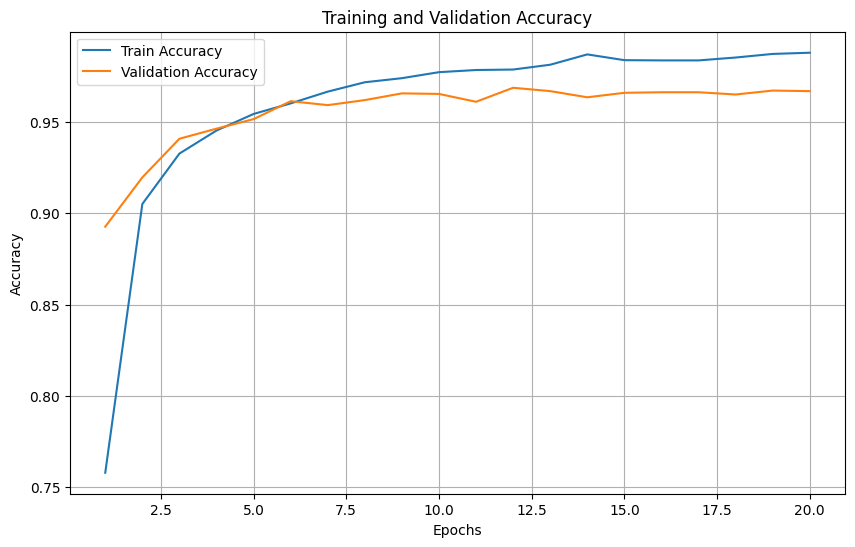

In [48]:
import time
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ProposedCNN(32).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) 

epochs = 20 
train_accuracies = []
val_accuracies = []
start_time = time.time()

for epoch in range(epochs):
    model.train() 
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_accuracy = correct / total
    train_accuracies.append(train_accuracy)

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_accuracy = correct / total
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

end_time = time.time()
training_time = end_time - start_time
print(f"訓練總時間: {training_time:.2f} 秒")

start_time = time.time()
model.eval()
all_labels = []
all_predictions = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

accuracy = accuracy_score(all_labels, all_predictions) * 100
precision = precision_score(all_labels, all_predictions, average='weighted') * 100
recall = recall_score(all_labels, all_predictions, average='weighted') * 100
f1 = f1_score(all_labels, all_predictions, average='weighted') * 100

print(f"測試準確率: {accuracy:.2f}%")
print(f"測試精確率: {precision:.2f}%")
print(f"測試召回率: {recall:.2f}%")
print(f"測試 F1 分數: {f1:.2f}%")

test_time = time.time() - start_time
print(f"測試總時間: {test_time:.2f} 秒")

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()
plt.show()


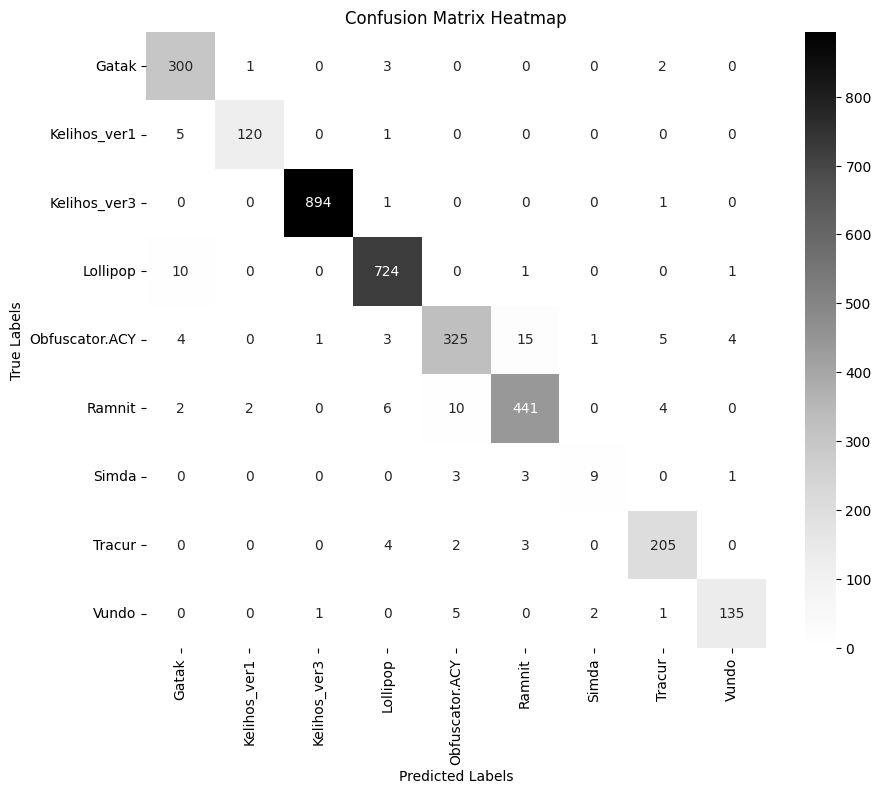

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(all_labels, all_predictions)

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greys', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix Heatmap')
    plt.show()

class_names = list(dataset.label_map.keys())
plot_confusion_matrix(cm, class_names)

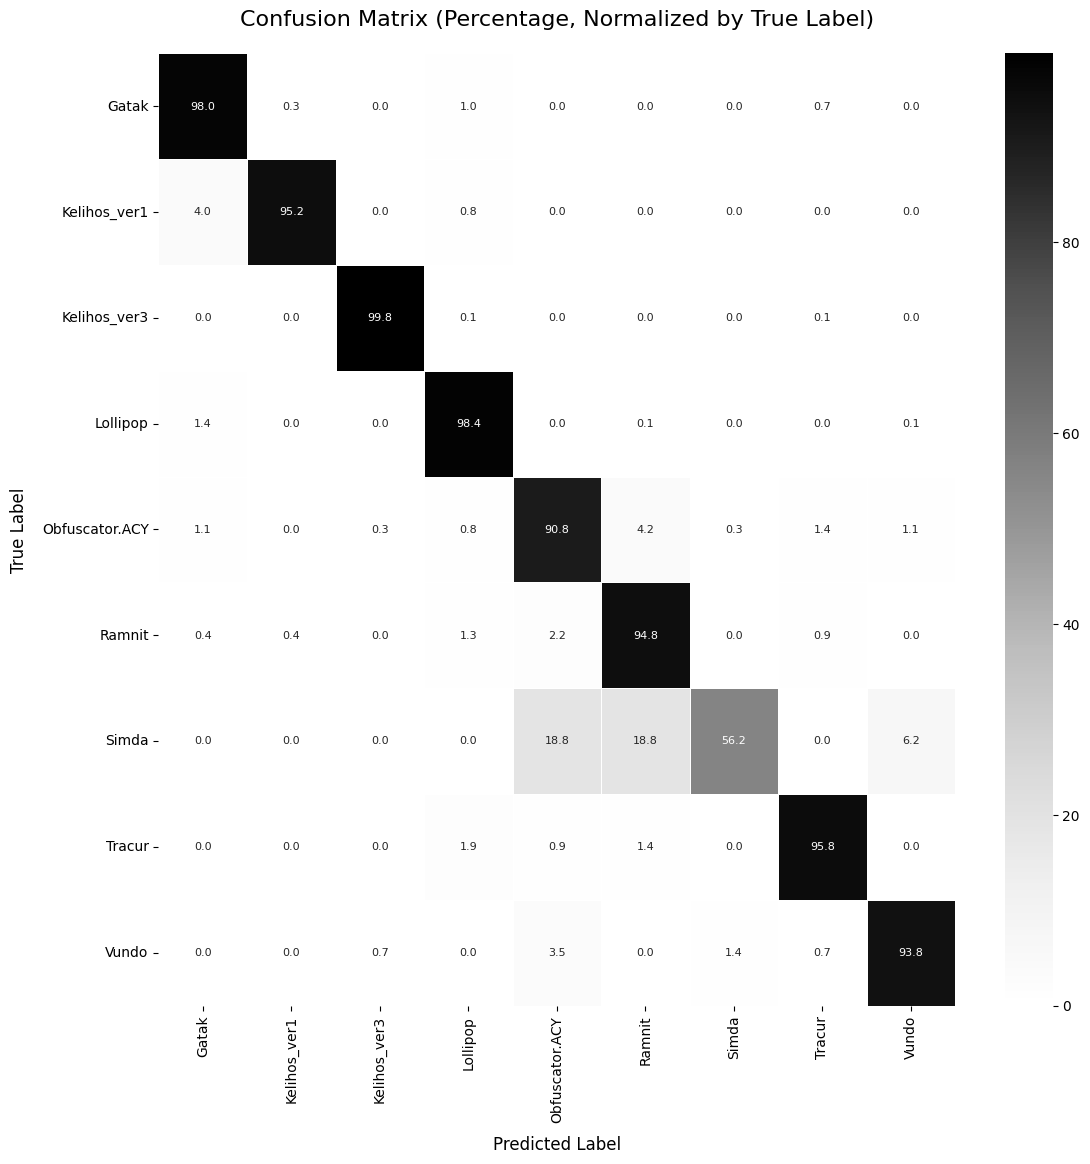

In [56]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(all_labels, all_predictions)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100 

class_names = list(dataset.label_map.keys())

fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(cm_percentage, 
            annot=True, 
            fmt=".1f", 
            cmap="Greys", 
            xticklabels=class_names, 
            yticklabels=class_names, 
            cbar=True, 
            linewidths=0.5,
            linecolor='white',
            annot_kws={"size": 8})

plt.title("Confusion Matrix (Percentage, Normalized by True Label)", fontsize=16, pad=20)
plt.xlabel("Predicted Label", fontsize=12, labelpad=10)
plt.ylabel("True Label", fontsize=12, labelpad=10)
plt.xticks(rotation=90, fontsize=10) 
plt.yticks(rotation=0, fontsize=10)

plt.tight_layout(pad=2.0)

plt.show()

In [51]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

print("提取 CNN 特徵")
train_features, train_labels = extract_features(model, train_loader, device)
test_features, test_labels = extract_features(model, test_loader, device)

print("開始訓練 SVM 分類器")
train_features_flat = train_features.reshape(train_features.shape[0], -1)
test_features_flat = test_features.reshape(test_features.shape[0], -1)
svm_classifier = make_pipeline(StandardScaler(), SVC(kernel='linear'))
svm_classifier.fit(train_features_flat, train_labels)

print("評估 SVM 分類器")
predictions = svm_classifier.predict(test_features_flat)
accuracy = accuracy_score(test_labels, predictions)
precision = precision_score(test_labels, predictions, average='weighted')
recall = recall_score(test_labels, predictions, average='weighted')
f1 = f1_score(test_labels, predictions, average='weighted')

print(f"SVM 測試準確率: {accuracy:.4f}")
print(f"SVM 精確率: {precision:.4f}")
print(f"SVM 召回率: {recall:.4f}")
print(f"SVM F1 分數: {f1:.4f}")

提取 CNN 特徵


提取特徵: 100%|██████████| 102/102 [00:00<00:00, 1773.46it/s]


開始訓練 SVM 分類器
評估 SVM 分類器
SVM 測試準確率: 0.9687
SVM 精確率: 0.9684
SVM 召回率: 0.9687
SVM F1 分數: 0.9683


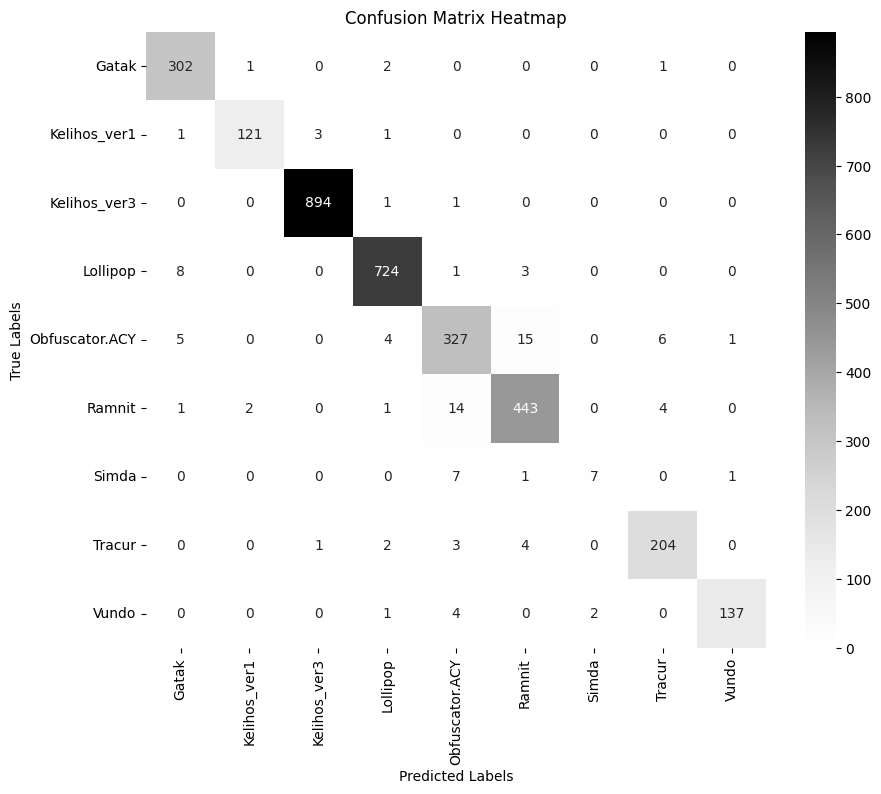

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(test_labels, predictions)

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greys', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix Heatmap')
    plt.show()

class_names = list(dataset.label_map.keys())
plot_confusion_matrix(cm, class_names)

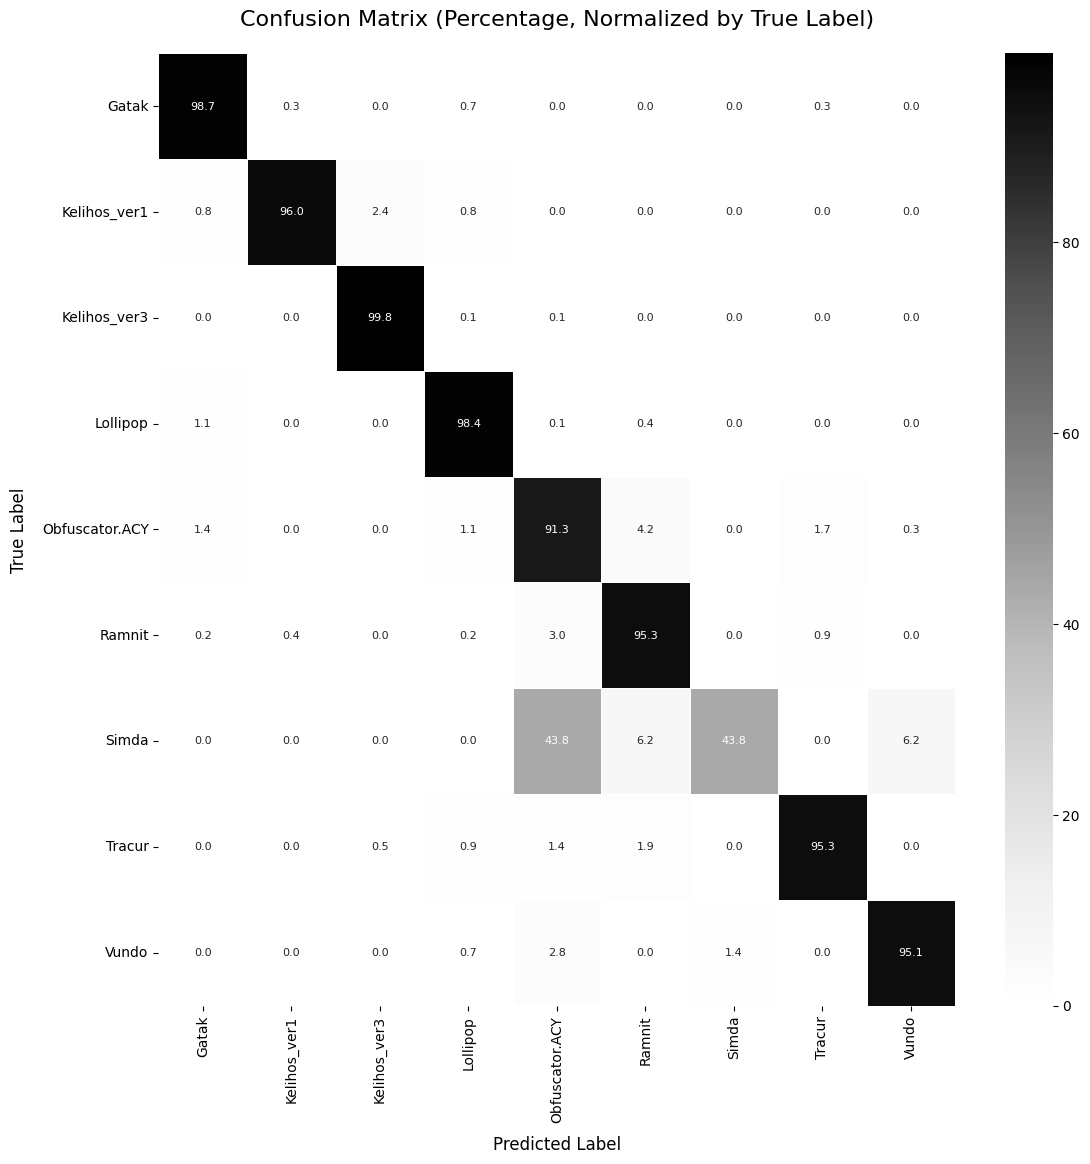

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(test_labels, predictions)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100 

class_names = list(dataset.label_map.keys())

fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(cm_percentage, 
            annot=True, 
            fmt=".1f", 
            cmap="Greys", 
            xticklabels=class_names, 
            yticklabels=class_names, 
            cbar=True, 
            linewidths=0.5,
            linecolor='white',
            annot_kws={"size": 8}) 

plt.title("Confusion Matrix (Percentage, Normalized by True Label)", fontsize=16, pad=20)
plt.xlabel("Predicted Label", fontsize=12, labelpad=10)
plt.ylabel("True Label", fontsize=12, labelpad=10)
plt.xticks(rotation=90, fontsize=10) 
plt.yticks(rotation=0, fontsize=10)

plt.tight_layout(pad=2.0)

plt.show()